# Descrição

A categoria "Dimensões" foi criada com o intuito de proporcionar uma melhor organização e categorização dos indicadores, facilitando a análise e o entendimento dos diversos aspectos abordados. Essa estrutura foi dividida em três grandes temas: Desenvolvimento Social, Desenvolvimento Econômico Integrado e Desenvolvimento Urbano Sustentável.

Cada um desses temas aborda áreas essenciais para o desenvolvimento e o bem-estar da sociedade. O tema Desenvolvimento Social reúne indicadores relacionados às ações e estratégias voltadas para a melhoria da qualidade de vida das populações, com foco em questões como saúde, educação, assistência social e segurança. Já o Desenvolvimento Econômico Integrado concentra-se em aspectos ligados ao crescimento das cidades, infraestrutura, mobilidade urbana, e planejamento territorial, buscando otimizar os espaços urbanos para atender as necessidades de uma população crescente. Por fim, o tema Desenvolvimento Urbano Sustentável aborda a adaptação das cidades e comunidades aos impactos das mudanças climáticas, bem como a promoção de práticas sustentáveis para garantir a preservação do meio ambiente e o uso responsável dos recursos naturais.

Com essa organização, os indicadores se tornam mais acessíveis e facilitam a análise das diferentes dimensões que impactam o desenvolvimento social, econômico e ambiental, promovendo uma visão integrada e mais eficaz para as tomadas de decisão.

# Celulas Com Dependecias Globais

## imports Gerais

In [1]:
from io import BytesIO
import tempfile
import zipfile
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
import requests
from tqdm import tqdm
from bs4 import BeautifulSoup
from pathlib import Path
import concurrent.futures
from glob import glob
import geopandas as gpd
from shapely import wkt, Point
import pyproj
from IPython.display import clear_output
import unicodedata
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
import numpy as np
from io import StringIO
import json
import re

## Lib para download

In [2]:
!pip install odfpy
!pip install datasus-dbc
!pip install basedosdados==2.0.0b16
clear_output()

## Constantes Globais

> `billing_project_id` deve ser preenchida com seu projeto do Google Cloud. Mais informações de como criar um o que é uma projeto Google Cloud ▶ [Como criar projeto Google Cloud][access_data_bq]

[access_data_bq]: https://basedosdados.org/docs/access_data_bq

In [3]:
billing_project_id = "br-fbsp-absp" # Define o nome do projeto Google que está vinculado ao email do colab

## Funçoes Globais

In [4]:

def slugify(s: str,
            remove_space: bool=False) -> str:
  s = s.strip().lower()
  s = unicodedata.normalize("NFD", s)
  s = s.encode("ascii", "ignore")
  s = s.decode("utf-8")
  if remove_space:
    s = re.sub(r'[\s_-]+', '', s)
  return s


def download_and_zip_extraction(url: str) -> None:
    """
    Baixa um arquivo do FTP e retorna seu conteúdo em memória.

    Parâmetros:
    url (str): URL do arquivo a ser baixado.

    Retorna:
    Arquivo será baixado e extraido na pasta "data/input"
    """

    headers = {
      "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:136.0) Gecko/20100101 Firefox/136.0",
      "Accept": "text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8",
      "Accept-Language": "pt-BR,pt;q=0.8,en-US;q=0.5,en;q=0.3",
    }

    base_path = Path("data")
    path_input = base_path / "input"

    response = requests.get(url, headers=headers, stream=True)
    response.raise_for_status()

    save_path = path_input / url.split('/')[-1]

    path_input.mkdir(parents=True, exist_ok=True)

    with open(save_path, "wb") as fd:
        for chunk in response.iter_content(chunk_size=128):
            fd.write(chunk)

    with zipfile.ZipFile(save_path) as z:
        z.extractall(path_input)


def overlap_percentage(outer_polygon, inner_polygon) -> float:
    """Calcula a porcentagem de um polígono que se sobrepõe a outro polígono."""
    try:
      outer_polygon = Polygon(outer_polygon)
      inner_polygon = Polygon(inner_polygon)

      ratio = outer_polygon.intersection(inner_polygon).area / inner_polygon.area

      return round(ratio * 100, 2)
    except:
      return np.nan


def get_population_close_to_object(df_with_object: gpd.GeoDataFrame,
                                   columns_object_name: str = '1 km de equipamentos',
                                   columns_with_population: str = 'V0001',
                                   buffer: int = 1000) -> gpd.GeoDataFrame:

  df_object_to_buffer = df_with_object.copy()

  # Transformar longitue e latitude em Point objeto

  df_object_to_buffer['geometry'] = df_object_to_buffer['geometry'].astype(str).apply(wkt.loads)

  geo_df_object_to_buffer = gpd.GeoDataFrame(df_object_to_buffer, geometry='geometry', crs="EPSG:31983")

  target_crs = pyproj.CRS.from_epsg(4326)

  geo_df_object_to_buffer = geo_df_object_to_buffer.to_crs(target_crs)

  geo_df_object_to_buffer = geo_df_object_to_buffer.sjoin(distritos_sp, how='left', predicate='within')

  object_without_buffer = gpd.GeoDataFrame(geo_df_object_to_buffer, geometry="geometry", crs=4326).to_crs(3003)
  object_with_buffer = object_without_buffer.copy()
  object_with_buffer.geometry = object_without_buffer.geometry.buffer(buffer)
  object_with_buffer = object_with_buffer.to_crs(4326)

  df_to_union = object_with_buffer.reset_index()[['geometry']]
  uniao_df = df_to_union.sjoin(df_to_union, how='left', predicate='intersects')
  over_lay_view = uniao_df.dissolve().explode().reset_index(drop=True)

  # Verificação Setores Interceptado

  setores_maps['geometry_to_calculete'] = setores_maps.geometry
  distritos_sp['geometry_to_calculete'] = distritos_sp.geometry

  # Realizar o spatial join
  result = gpd.sjoin(
      over_lay_view,
      setores_maps,
      how='inner',
      predicate='intersects',
      lsuffix='_overlay',
      rsuffix='_setor'
  )

  result.geometry_to_calculete = result.geometry_to_calculete.to_crs(4326)
  result.geometry = result.geometry.to_crs(4326)

  # Calcular porcentagens

  result['area_coberta_corredor'] = result.apply(
      lambda x: overlap_percentage(x.geometry, x.geometry_to_calculete) ,axis=1
  )

  df_populacao_distrital_porcent = result.copy()
  df_populacao_distrital_porcent[columns_with_population] = df_populacao_distrital_porcent[columns_with_population].astype(int)

  object_final_porcent = df_populacao_distrital_porcent.groupby(['NM_DIST', 'CD_SETOR', columns_with_population], as_index=False).area_coberta_corredor.sum()
  object_final_porcent[f'Pessoas {columns_object_name}'] = (object_final_porcent['area_coberta_corredor'] / 100) * object_final_porcent[columns_with_population]
  object_final_porcent[f'Pessoas {columns_object_name}'] = object_final_porcent[f'Pessoas {columns_object_name}'].round(3)

  object_final_porcent = object_final_porcent.groupby('NM_DIST')[f'Pessoas {columns_object_name}'].sum().to_frame(f'Pessoas {columns_object_name}')

  total_populacao_porcent = setores_maps.groupby('NM_DIST')[columns_with_population].sum().to_frame('Total População')

  object_final_porcent = pd.concat([object_final_porcent, total_populacao_porcent], axis=1)
  object_final_porcent[f'% da população distrital a até {columns_object_name}'] = ((object_final_porcent[f'Pessoas {columns_object_name}'] / object_final_porcent['Total População']) * 100).round(3)
  object_final_porcent.fillna(0, inplace=True)

  return object_final_porcent

# Verificar IP

> Alguns sites tem restriçoes de IP. Recomendo sempre verificar se o IP da sessão é do Estados Unidos.

In [5]:
r = requests.get('https://api.myip.com/')
r.text

'{"ip":"34.82.176.213","country":"United States","cc":"US"}'

# [Censo][censo-2022]

Indicadores:

- % de pessoas de 65 anos ou mais - Censo 2022
- % Pessoa responsável pelo domicílio, Sexo feminino, 15 anos ou mais, Morador não sabe ler e escrever - Censo 2022
- Proporção de pessoas responsáveis de 12 a 24 anos - Censo 2022
- Proporção de mulheres reponsáveis com menos de 15 a 29 anos - Censo 2022
- Proporção de pessoas responsáveis não alfabetizadas 15 anos ou mais - Censo 2022
- Proporção que vive em domicílios urbanos com o serviço de coleta de lixo - Censo 2022


[censo-2022]: https://www.ibge.gov.br/estatisticas/sociais/trabalho/22827-censo-demografico-2022.html?=&t=downloads


## Funçoes

In [6]:
class Indicador:

  def __init__(self,
               nome_indicador: str,
               numerador: str,
               denominador: str,
               base: pd.DataFrame) -> None:

     self.nome_indicador = nome_indicador
     self.numerador = numerador
     self.denominador = denominador
     self.base = base

  def form_value_by_sum(self,
                        *args,
                        denominador: bool = False) -> None:

    valores = list(args)

    value_to_form = self.denominador if denominador else self.numerador

    self.base[valores] = self.base[valores].astype(float)
    self.base[value_to_form] = self.base[valores].sum(axis=1)


  def form_indicador(self, multiplicador: int = 100) ->  pd.DataFrame:

    columns_str_to_int = [self.numerador, self.denominador]

    self.base[columns_str_to_int] = self.base[columns_str_to_int].astype(float)

    self.base.set_index(self.base.columns[0], inplace=True)

    self.base = (
        (self.base[self.numerador] / self.base[self.denominador]) * multiplicador
        ).round(3).to_frame(self.nome_indicador)

    return self.base

def get_sp_distrito_from_csv(path_csv: str) -> pd.DataFrame:

  name_file = path_csv.split('/')[-1]

  temp_df = pd.read_csv(path_csv, encoding='iso-8859-1', sep=";", dtype=str)

  df_sp_distritos = temp_df[temp_df.CD_DIST.str.contains("3550308")]

  return df_sp_distritos

def get_sp_setor_from_csv(path_csv: str, ids_seto: list) -> pd.DataFrame:

  name_file = path_csv.split('/')[-1]

  temp_df = pd.read_csv(path_csv, encoding='iso-8859-1', sep=";", dtype=str)

  temp_df.columns = temp_df.columns.str.upper()

  df_sp_distritos = temp_df[temp_df.CD_SETOR.isin(ids_seto)]

  return df_sp_distritos

def excel_sheet_to_df( path_dicionario: str, sheet_name: str) -> pd.DataFrame:

  temp_df_sheet = pd.read_excel(path_dicionario, sheet_name=sheet_name)

  temp_df_sheet = temp_df_sheet[['Variável', 'Descrição']]

  return temp_df_sheet

## Download

In [7]:
url_agregados_por_distrito_csv = 'http://ftp.ibge.gov.br/Censos/Censo_Demografico_2022/Agregados_por_Setores_Censitarios/Agregados_por_Distrito_csv/'
url_sp_distrito_geo = 'http://ftp.ibge.gov.br/Censos/Censo_Demografico_2022/Agregados_por_Setores_Censitarios/malha_com_atributos/distritos/shp/UF/SP/SP_distritos_CD2022.zip'
url_dicionario_de_dados = 'http://ftp.ibge.gov.br/Censos/Censo_Demografico_2022/Agregados_por_Setores_Censitarios/dicionario_de_dados_agregados_por_setores_censitarios_20250417.xlsx'

response = requests.get(url_agregados_por_distrito_csv)

soup = BeautifulSoup(response.text)

links_agregados_por_distrito_csv = [url_agregados_por_distrito_csv + a.get('href') for a in soup.select('td a') if a.get('href').count('zip')] # Coleta o link dos Arquivos

links_agregados_por_distrito_csv.extend([url_sp_distrito_geo, url_dicionario_de_dados]) # Adicionando tabela Distrito Geografico e Dicionario a lista de download

with concurrent.futures.ThreadPoolExecutor() as executor:
  executor.map(download_and_zip_extraction, links_agregados_por_distrito_csv)



## Preparar DataFrame - [Censo 2022][censo-2022]

[censo-2022]: https://www.ibge.gov.br/estatisticas/sociais/trabalho/22827-censo-demografico-2022.html?=&t=downloads

In [8]:
# Define tabela com as GeoGrafias
geo_df_sp = gpd.read_file('/content/data/input/SP_distritos_CD2022.shp', columns=['CD_DIST', 'NM_DIST', 'geometry'])
geo_df_sp = geo_df_sp[geo_df_sp.CD_DIST.str.contains("3550308")]

# Carrega o Dicionario e Prepara ele para o Rename
path_dicionario = '/content/data/input/dicionario_de_dados_agregados_por_setores_censitarios_20250417.xlsx'
sheet_names = ['Dicionário Básico', 'Dicionário não PCT', 'Dicionário PCT - Indígenas', 'Dicionário PCT - Quilombolas']

df_dicionario = pd.concat([excel_sheet_to_df(path_dicionario, sheet_name) for sheet_name in sheet_names])

dicionario_to_rename = dict(zip(df_dicionario.Variável, df_dicionario.Descrição))

# Carrega e trata tabela final

regex_glob = '/content/data/input/Agregados_por_distritos*.csv'

csv_files = glob(regex_glob)

temp_dfs = [get_sp_distrito_from_csv(csv_path) for csv_path in csv_files]

temp_dfs.append(geo_df_sp) # Adicionando tabela Distrito Geografico

first_temp_df = temp_dfs.pop(0) # Seleciona primeira tabela e remove ela da lista

for temp_df in temp_dfs:

  temp_df.drop('NM_DIST', axis=1, inplace=True)

  first_temp_df = pd.merge(
      first_temp_df,
      temp_df,
      how="left",
      on="CD_DIST"
  )

first_temp_df.columns = first_temp_df.columns.str.upper() # Coloca todas as colunas como Upper para manipulação de nomes

# Tratar ordem e nome das colunas
columns_to_sorted = first_temp_df.columns[first_temp_df.columns.str.startswith('V')].sort_values().tolist()
first_columns = first_temp_df.columns[~first_temp_df.columns.str.startswith('V')].tolist()
column_order = first_columns + columns_to_sorted

first_temp_df = first_temp_df[column_order]

In [9]:
# Selecionando coluna do indicador de 'Total de pessoas' e o nome do distrito.
populacao_censo_2022 = first_temp_df[['NM_DIST', 'V0001']]
populacao_censo_2022.index = populacao_censo_2022.NM_DIST
populacao_censo_2022 = populacao_censo_2022['V0001'].astype(int)

## Indicadores - [Censo 2022][censo-2022]

[censo-2022]: https://www.ibge.gov.br/estatisticas/sociais/trabalho/22827-censo-demografico-2022.html?=&t=downloads

### % de pessoas de 65 anos ou mais - Censo 2022
Formula:

$\text{%} = \frac{\text{Total de Pessoas De 65 Mais}}{\text{Total De Pessoas}} \times 100$

Indicadores resultante desse codigo:
- % de pessoas de 65 anos ou mais - Censo 2022





In [10]:
# >>_% de pessoas de 65 anos ou mais - Censo 2022_<<

# V0001: Total de pessoas
# V00654: 65 a 69 anos
# V00655: 70 a 79 anos
# V00656: 80 anos ou mais

# Importante que a primeira coluna seja a com fome dos distritos

temp_df = first_temp_df[['NM_DIST', 'V0001', 'V00654','V00655','V00656']].copy()

pessoas_65_censo_2022 = Indicador(
    nome_indicador='% de pessoas de 65 anos ou mais - Censo 2022',
    numerador='total de pessoas de 65 anos ou mais',
    denominador='V0001',
    base=temp_df
)
pessoas_65_censo_2022.form_value_by_sum('V00654','V00655','V00656')

pessoas_65_censo_2022 = pessoas_65_censo_2022.form_indicador()

### % Pessoa responsável pelo domicílio, Sexo feminino, 15 anos ou mais, Morador não sabe ler e escrever

$\text{% Pessoa responsável pelo domicílio, Sexo feminino, 15 anos ou mais, Morador não sabe ler e escrever} = \frac{\text{ Pessoa responsável pelo domicílio, Sexo feminino, 15 anos ou mais, Morador não sabe ler e escrever}}{\text{Pessoa responsável pelo domicílio, Sexo feminino}} \times 100$

Indicadores resultante desse codigo:
- % Pessoa responsável pelo domicílio, Sexo feminino, 15 anos ou mais, Morador não sabe ler e escrever - Censo 2022

In [11]:
# >>_% Pessoa responsável pelo domicílio, Sexo feminino, 15 anos ou mais, Morador não sabe ler e escrever - Censo 2022_<<

# V00989: Pessoa responsável pelo domicílio, Sexo feminino, 15 anos ou mais, Morador não sabe ler e escrever
# V01063: Pessoa responsável pelo domicílio, Sexo feminino


nome_indicador = '% Pessoa responsável pelo domicílio, Sexo feminino, 15 anos ou mais, Morador não sabe ler e escrever - Censo 2022'

temp_df = first_temp_df[['NM_DIST', 'V00989', 'V01063']].copy()

responsavel_feminino_ler_escrever = Indicador(
    nome_indicador=nome_indicador,
    numerador='V00989',
    denominador='V01063',
    base=temp_df
)

responsavel_feminino_ler_escrever = responsavel_feminino_ler_escrever.form_indicador()

### Proporção de pessoas responsáveis de 12 a 24 anos

A fórmula :


$\text{Proporção de pessoas responsáveis de 12 a 24 anos} = \frac{\text{ pessoas responsáveis de 12
 a 24 anos}}{\text{Pessoas Responsáveis}} \times 100$


 Indicadores resultante desse codigo:
- Proporção de pessoas responsáveis de 12 a 24 anos - Censo 2022



In [12]:
# >>_Proporção de pessoas responsáveis de 12 a 24 anos - Censo 2022_<<


# V01042: Pessoa responsável pelo domicílio
# V0001: Total de pessoas
# V01064: Pessoa responsável pelo domicílio, 12 a 17 anos
# V01065: Pessoa responsável pelo domicílio, 18 a 24 anos


nome_indicador = 'Proporção de pessoas responsáveis de 12 a 24 anos - Censo 2022'

temp_df = first_temp_df[['NM_DIST', 'V01042', 'V01064', 'V01065']].copy()

pessoas_responsaveis_10_24 = Indicador(
    nome_indicador=nome_indicador,
    numerador='Pessoa responsável pelo domicílio, 12 a 24 anos',
    denominador='V01042',
    base=temp_df
)

pessoas_responsaveis_10_24.form_value_by_sum('V01064', 'V01065')
pessoas_responsaveis_10_24 = pessoas_responsaveis_10_24.form_indicador()

### Proporção de mulheres reponsáveis com menos de 15 a 29 anos

A fórmula :


$\text{Proporção de mulheres reponsáveis com menos de 15 a 29 anos} = \frac{\text{ mulheres reponsáveis com menos de 15 a 29 anos}}{\text{Total de pessoas}} \times 100$


 Indicadores resultante desse codigo:
- Proporção de mulheres reponsáveis com menos de 15 a 29 anos - Censo 2022



In [13]:
# >>_Proporção de mulheres reponsáveis com menos de 15 a 29 anos - Censo 2022_<<


# V0001: Total de pessoas
# V01063: Pessoa responsável pelo domicílio, Sexo feminino
# V00978: Pessoa responsável pelo domicílio, Sexo feminino, 15 a 29 anos, Morador sabe ler e escrever
# V00979: Pessoa responsável pelo domicílio, Sexo feminino, 15 a 29 anos, Morador não sabe ler e escrever

# V01042 para fazer a divisão

nome_indicador = 'Proporção de mulheres reponsáveis com menos de 15 a 29 anos - Censo 2022'

temp_df = first_temp_df[['NM_DIST', 'V01042', 'V00978', 'V00979']].copy()

mulheres_reponsaveis_menor_29 = Indicador(
    nome_indicador=nome_indicador,
    numerador='Pessoa responsável pelo domicílio, Sexo feminino, 15 a 29 anos',
    denominador='V01042',
    base=temp_df
)

mulheres_reponsaveis_menor_29.form_value_by_sum('V00978', 'V00979')
mulheres_reponsaveis_menor_29 = mulheres_reponsaveis_menor_29.form_indicador()

### Proporção de pessoas responsáveis não alfabetizadas 15 anos ou mais

A fórmula :


$\text{Proporção de pessoas responsáveis não alfabetizadas 15 anos ou mais} = \frac{\text{pessoas responsáveis não alfabetizadas 15 anos ou mais}}{\text{pessoas responsáveis 15 anos ou mais}} \times 100$


 Indicadores resultante desse codigo:
- Proporção de pessoas responsáveis não alfabetizadas 15 anos ou mais - Censo 2022


In [14]:
# >>_Proporção de pessoas responsáveis não alfabetizadas 15 anos ou mais - Censo 2022_<<


# V00984: Pessoa responsável pelo domicílio, 15 anos ou mais, Morador sabe ler e escrever
# V00985: Pessoa responsável pelo domicílio, 15 anos ou mais, Morador não sabe ler e escrever

nome_indicador = 'Proporção de pessoas responsáveis não alfabetizadas 15 anos ou mais - Censo 2022'

temp_df = first_temp_df[['NM_DIST', 'V00984', 'V00985']].copy()

responsaveis_nao_alfabetizadas_15 = Indicador(
    nome_indicador=nome_indicador,
    numerador='V00985',
    denominador='Pessoa responsável pelo domicílio, 15 anos ou mais',
    base=temp_df
)

responsaveis_nao_alfabetizadas_15.form_value_by_sum("V00984", "V00985", denominador=True)
responsaveis_nao_alfabetizadas_15 = responsaveis_nao_alfabetizadas_15.form_indicador()

### % da população que vive em domicílios urbanos com o serviço de coleta de lixo

A fórmula :

$\text{% da população que vive em domicílios urbanos com o serviço de coleta de lixo} = \frac{\text{população que vive em domicílios urbanos com o serviço de coleta de lixo}}{\text{Total de pessoas}} \times 100$

 Indicadores resultante desse codigo:
- Proporção que vive em domicílios urbanos com o serviço de coleta de lixo - Censo 2022


In [15]:
# >>_Proporção que vive em domicílios urbanos com o serviço de coleta de lixo - Censo 2022_<<


# V0007: Total de pessoas

nome_indicador = 'Proporção que vive em domicílios urbanos com o serviço de coleta de lixo - Censo 2022'

temp_df = first_temp_df[['NM_DIST', 'V0007', 'V00397', 'V00398']].copy()

coleta_lixo = Indicador(
    nome_indicador=nome_indicador,
    numerador='coleta_lixo',
    denominador='V0007',
    base=temp_df
)

coleta_lixo.form_value_by_sum('V00397', 'V00398')
coleta_lixo = coleta_lixo.form_indicador()

# Datasus ( [SIM 2022][ms_sim])

- Mortalidade materna - SIM 2022
- Mortalidade até 1 ano de idade - SIM 2022
- % Óbitos Evitáveis - SIM 2022


[sinasc]: https://basedosdados.org/dataset/48ccef51-8207-40ee-af5b-134c8ac3fb8c?table=80359f9a-8189-4693-bdf7-ebf7be0d2fff

[ms_sim]: https://basedosdados.org/dataset/5beeec93-cbf3-43f6-9eea-9bee6a0d1683?table=dea823a5-cad7-4014-b77c-4aa33b3b0541


## Querys e constantes

Caso você não tenha um projeto google configurado.

Verifique a documentação: [primeiros-passos][primeiros-passos]

[primeiros-passos]: https://basedosdados.github.io/sdk/access_data_bq/#primeiros-passos

In [16]:
query_ms_sim = """
SELECT
  *
FROM `basedosdados.br_ms_sim.microdados` AS dados
where ano = 2022 and id_municipio_ocorrencia = '3550308' and codigo_estabelecimento is not null
"""

## Download [CNES][cnes] Estabelecimentos e [Censo][censo] 2020 geometry

[cnes]: https://dados.gov.br/dados/conjuntos-dados/cnes-cadastro-nacional-de-estabelecimentos-de-saude
[censo]: http://ftp.ibge.gov.br/Censos/Censo_Demografico_2022/Agregados_por_Setores_Censitarios/malha_com_atributos/distritos/shp/UF/SP

In [17]:
url = 'https://s3.sa-east-1.amazonaws.com/ckan.saude.gov.br/CNES/cnes_estabelecimentos.zip'
url_sp_distrito_geo = 'http://ftp.ibge.gov.br/Censos/Censo_Demografico_2022/Agregados_por_Setores_Censitarios/malha_com_atributos/distritos/shp/UF/SP/SP_distritos_CD2022.zip'

urls = [url, url_sp_distrito_geo]

with concurrent.futures.ThreadPoolExecutor() as executor:
  executor.map(download_and_zip_extraction, urls)

## Ler [CNES][cnes] estabelecimentos

[cnes]: https://dados.gov.br/dados/conjuntos-dados/cnes-cadastro-nacional-de-estabelecimentos-de-saude

In [18]:
cnes_estabelecimentos = pd.read_csv('/content/data/input/cnes_estabelecimentos.csv', dtype=str, sep=';',
                                    encoding='latin-1', usecols=['CO_CNES', 'CO_UNIDADE', 'CO_IBGE', 'NU_LATITUDE', 'NU_LONGITUDE'])

cnes_estabelecimentos_sp = cnes_estabelecimentos[cnes_estabelecimentos.CO_IBGE == '355030']

# Transformar longitue e latitude em Point objeto
cnes_estabelecimentos_sp['point'] = cnes_estabelecimentos_sp.apply(lambda row: Point(row.NU_LONGITUDE, row.NU_LATITUDE), axis=1)

cnes_estabelecimentos_sp_geo_df = gpd.GeoDataFrame(cnes_estabelecimentos_sp, geometry='point')

cnes_estabelecimentos_sp_geo_df.crs = 'EPSG:4674' # igular CRS

<ipython-input-18-57d3f635c143>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cnes_estabelecimentos_sp['point'] = cnes_estabelecimentos_sp.apply(lambda row: Point(row.NU_LONGITUDE, row.NU_LATITUDE), axis=1)


## Ler geometry do [Censo 2022][censo]

[censo]: http://ftp.ibge.gov.br/Censos/Censo_Demografico_2022/Agregados_por_Setores_Censitarios/malha_com_atributos/distritos/shp/UF/SP

In [19]:
geo_df_sp = gpd.read_file('/content/data/input/SP_distritos_CD2022.shp', columns=['CD_DIST', 'NM_DIST', 'geometry'])
geo_df_sp = geo_df_sp[geo_df_sp.CD_DIST.str.contains("3550308")]

## Juntas [CENSO][censo] Geometry com Point de [CNES][cnes]

[cnes]: https://dados.gov.br/dados/conjuntos-dados/cnes-cadastro-nacional-de-estabelecimentos-de-saude
[censo]: http://ftp.ibge.gov.br/Censos/Censo_Demografico_2022/Agregados_por_Setores_Censitarios/malha_com_atributos/distritos/shp/UF/SP

In [20]:
cnes_sp_distrito_geo_df = geo_df_sp.sjoin(cnes_estabelecimentos_sp_geo_df, how='left', predicate='contains')

## Puxar dados [ms_sim][ms_sim] Microdados

[ms_sim]: https://basedosdados.org/dataset/5beeec93-cbf3-43f6-9eea-9bee6a0d1683?table=dea823a5-cad7-4014-b77c-4aa33b3b0541

In [21]:
import basedosdados as bd

df_ms_sim = bd.read_sql(
      query_ms_sim,
      billing_project_id=billing_project_id,
  )

df_ms_sim.codigo_estabelecimento = df_ms_sim.codigo_estabelecimento.str.rstrip('.0') # Limpando zero a esquerda

Downloading: 100%|██████████|


## Juntar [MS_SIM][ms_sim] com [CNES][cnes] com distritos

[ms_sim]: https://basedosdados.org/dataset/5beeec93-cbf3-43f6-9eea-9bee6a0d1683?table=dea823a5-cad7-4014-b77c-4aa33b3b0541
[cnes]: https://dados.gov.br/dados/conjuntos-dados/cnes-cadastro-nacional-de-estabelecimentos-de-saude

In [22]:
df_ms_sim_with_distritos =  df_ms_sim.merge(cnes_sp_distrito_geo_df, how='left', left_on='codigo_estabelecimento', right_on='CO_CNES')

## Indicadores vindo de [MS_SIM][ms_sim]

[ms_sim]: https://basedosdados.org/dataset/5beeec93-cbf3-43f6-9eea-9bee6a0d1683?table=dea823a5-cad7-4014-b77c-4aa33b3b0541

### Mortalidade materna

Seguinte fórmula:

$\text{
Mortalidade materna} = \frac{\text{Número de óbitos maternos}}{\text{Número de óbitos}} \times 1000$

Indicadores resultante desse codigo:
- Mortalidade materna - SIM 2022

In [23]:
# >>_Mortalidade materna - SIM 2022_<<


indicador_name = 'Mortalidade materna - SIM 2022'
selected = (df_ms_sim_with_distritos.sexo == '2') & (df_ms_sim_with_distritos.obito_gravidez.isin(['3.0', '2.0', '1.0']))
df_ms_sim_with_mortalidade_materna = df_ms_sim_with_distritos[selected]
df_ms_sim_with_mortalidade_materna = df_ms_sim_with_mortalidade_materna.groupby('NM_DIST').data_obito.count().to_frame('morte_maternas')

total_mortes = df_ms_sim_with_distritos.groupby('NM_DIST').data_obito.count().to_frame('mortes_totais')

df_ms_sim_with_mortalidade_materna = pd.concat([total_mortes, df_ms_sim_with_mortalidade_materna], axis=1)
df_ms_sim_with_mortalidade_materna.fillna(0, inplace=True)

df_ms_sim_with_mortalidade_materna = ((df_ms_sim_with_mortalidade_materna.morte_maternas / df_ms_sim_with_mortalidade_materna.mortes_totais) * 1000).round(3).to_frame(indicador_name)


### Mortalidade até 1 ano de idade | Mortalidade infantil (óbitos por 1.000 nascidos vivos)

Seguinte fórmula:

$\text{
Mortalidade infantil (óbitos por 1.000 nascidos vivos)} = \frac{\text{mortes_infantil}}{\text{mortes_totais}} \times 1000$

Indicadores resultante desse codigo:
- Mortalidade até 1 ano de idade - SIM 2022



In [24]:
# >>_Mortalidade infantil (óbitos por 1.000 nascidos vivos) - SIM 2022_<<

indicador_name = 'Mortalidade infantil (óbitos por 1.000 nascidos vivos) - SIM 2022'

selected = (df_ms_sim_with_distritos.idade <= 1)
df_ms_sim_mortalidade_one_year = df_ms_sim_with_distritos[selected]
df_ms_sim_mortalidade_one_year = df_ms_sim_mortalidade_one_year.groupby('NM_DIST').data_obito.count().to_frame('mortes_infantil')

total_mortes = df_ms_sim_with_distritos.groupby('NM_DIST').data_obito.count().to_frame('mortes_totais')

df_ms_sim_mortalidade_one_year = pd.concat([total_mortes, df_ms_sim_mortalidade_one_year], axis=1)
df_ms_sim_mortalidade_one_year.fillna(0, inplace=True)

df_ms_sim_mortalidade_one_year = ((df_ms_sim_mortalidade_one_year.mortes_infantil / df_ms_sim_mortalidade_one_year.mortes_totais) * 1000).round(3).to_frame(indicador_name)

### Óbitos Evitáveis

Seguinte fórmula:

$\text{
% Óbitos Evitáveis - SIM 2022} = \frac{\text{Óbitos evitáveis no distrito}}{\text{Total de óbitos}} \times 100$

Indicadores resultante desse codigo:
- % Óbitos Evitáveis - SIM 2022


In [25]:
cids = ['A02','A04','A08','A09','A15','A16','A17','A18','A19','A22','A26','A27','A31','A39','A41','A44','A46','A48','A49','A77','A81','A86','A87','A90','A91','A92','A94','A98','A99','B00','B02','B16','B17','B18','B19','B20','B21','B22','B23','B24','B25','B33','B34','B37','B44','B45','B54','B57','B58','B59','B65','B69','B77','B87','B90','B94','C00','C01','C02','C03','C04','C05','C06','C07','C08','C09','C10','C11','C12','C13','C14','C15','C16','C17','C18','C19','C20','C21','C22','C23','C24','C25','C26','C30','C31','C32','C33','C34','C37','C38','C39','C40','C41','C43','C44','C45','C47','C48','C49','C50','C51','C52','C53','C54','C55','C56','C57','C58','C60','C61','C62','C64','C65','C66','C67','C68','C69','C70','C71','C72','C73','C74','C75','C76','C77','C78','C79','C80','C81','C82','C83','C84','C85','C88','C90','C91','C92','C93','C94','C95','C96','C97','D00','D01','D02','D13','D15','D18','D25','D26','D32','D33','D35','D36','D37','D38','D39','D40','D41','D42','D43','D44','D45','D46','D47','D48','D53','D56','D57','D58','D59','D60','D61','D62','D64','D65','D68','D69','D70','D71','D72','D73','D75','D76','D82','D84','D86','E03','E05','E07','E10','E11','E12','E14','E15','E16','E20','E21','E23','E24','E27','E41','E43','E46','E51','E66','E72','E74','E75','E76','E78','E83','E84','E85','E86','E87','E88','F01','F03','F05','F10','F14','F17','F19','F20','F31','F32','F44','F50','F71','F79','F84','G00','G03','G04','G06','G09','G10','G11','G12','G20','G23','G30','G31','G35','G36','G37','G40','G41','G45','G61','G62','G70','G71','G72','G80','G82','G83','G90','G91','G92','G93','G95','G96','G98','H60','H66','H70','I01','I02','I05','I06','I07','I08','I09','I10','I11','I12','I13','I20','I21','I24','I25','I26','I27','I28','I30','I31','I33','I34','I35','I38','I40','I42','I44','I46','I47','I48','I49','I50','I51','I60','I61','I62','I63','I64','I67','I69','I70','I71','I72','I73','I74','I77','I80','I81','I82','I83','I85','I86','I87','I89','I95','I99','J01','J02','J03','J06','J10','J11','J12','J15','J16','J18','J21','J22','J32','J35','J36','J38','J39','J40','J42','J43','J44','J45','J46','J47','J61','J62','J63','J64','J65','J67','J68','J69','J80','J81','J84','J85','J86','J90','J93','J94','J96','J98','K08','K13','K20','K22','K25','K26','K27','K28','K29','K31','K35','K37','K38','K40','K41','K42','K43','K44','K46','K50','K51','K52','K55','K56','K57','K59','K62','K63','K65','K66','K70','K71','K72','K73','K74','K75','K76','K80','K81','K82','K83','K85','K86','K90','K92','L02','L03','L08','L10','L13','L27','L51','L53','L88','L89','L95','L97','L98','M00','M05','M06','M16','M17','M19','M25','M30','M31','M32','M33','M34','M35','M45','M46','M47','M48','M50','M51','M60','M62','M72','M84','M86','M87','M89','N00','N03','N04','N10','N11','N12','N13','N15','N17','N18','N19','N20','N21','N26','N28','N30','N31','N32','N34','N36','N39','N40','N41','N42','N45','N48','N49','N61','N70','N73','N76','N81','N83','N85','N92','O00','O05','O06','O14','O15','O21','O26','O34','O41','O45','O46','O62','O71','O72','O75','O90','O95','O96','O98','O99','P20','P21','P27','P36','Q01','Q02','Q03','Q04','Q05','Q07','Q20','Q21','Q22','Q24','Q27','Q28','Q30','Q33','Q34','Q43','Q44','Q61','Q63','Q64','Q78','Q81','Q85','Q87','Q90','Q91','Q93','Q99','R04','R09','R10','R16','R19','R53','R54','R56','R57','R58','R68','R90','R96','R98','R99','V02','V03','V04','V05','V09','V12','V13','V14','V18','V19','V20','V22','V23','V24','V27','V28','V29','V42','V43','V44','V47','V48','V49','V54','V64','V67','V68','V69','V74','V85','V87','V89','V91','V95','W01','W06','W07','W10','W12','W13','W17','W18','W19','W20','W21','W22','W25','W31','W34','W36','W39','W44','W49','W54','W67','W68','W69','W70','W73','W74','W76','W78','W79','W80','W84','W85','W87','W89','X09','X18','X36','X42','X59','X61','X64','X67','X68','X69','X70','X72','X74','X78','X79','X80','X81','X82','X84','X91','X93','X94','X95','X96','X97','X99','Y00','Y01','Y03','Y04','Y09','Y11','Y12','Y13','Y16','Y18','Y19','Y20','Y21','Y22','Y24','Y26','Y27','Y28','Y29','Y30','Y32','Y33','Y34','Y35','Y40','Y44','Y45','Y46','Y48','Y49','Y51','Y57','Y71','Y83','Y84','Y85','Y89']

In [26]:
def is_obito_evitavel(atestado: str) -> bool:

  palavras = []
  partes = atestado.split('/')
  for parte in partes:
      palavras.extend(parte.split())

  # Verificamos cada palavra
  for palavra in palavras:
    for cid in cids:
      if palavra == cid:
        return True

  return False

In [27]:
# >>_% Óbitos Evitáveis - SIM 2022_<<


indicador_name = '% Óbitos Evitáveis - SIM 2022'


df_ms_sim_with_distritos_obito_evitavel = df_ms_sim_with_distritos.copy()
df_ms_sim_with_distritos_obito_evitavel['obito_evitavel'] = df_ms_sim_with_distritos_obito_evitavel.atestado.apply(is_obito_evitavel)
df_ms_sim_with_distritos_obito_evitavel = df_ms_sim_with_distritos_obito_evitavel[df_ms_sim_with_distritos_obito_evitavel.obito_evitavel == True]
df_ms_sim_with_distritos_obito_evitavel = df_ms_sim_with_distritos_obito_evitavel.groupby('NM_DIST').ano.size().to_frame('Óbitos Evitáveis - SIM 2022')

df_ms_sim_with_distritos_obitos_totais = df_ms_sim_with_distritos.copy()
df_ms_sim_with_distritos_obitos_totais = df_ms_sim_with_distritos_obitos_totais.groupby('NM_DIST').ano.size().to_frame('Total de óbitos - SIM 2022')

indicador_obito_evitaveis = pd.concat([df_ms_sim_with_distritos_obitos_totais, df_ms_sim_with_distritos_obito_evitavel], axis=1)
indicador_obito_evitaveis.fillna(0, inplace=True)
indicador_obito_evitaveis = ((indicador_obito_evitaveis['Óbitos Evitáveis - SIM 2022'] / indicador_obito_evitaveis['Total de óbitos - SIM 2022']) * 100).round(3).to_frame(indicador_name)

# Indicadores vindo de [INEP Censo Escolar 2023][inep_escola]

- Taxa de matrículas de crianças pardas - INEP 2023/Censo 2022
- Taxa de matrículas de crianças pretas - INEP 2023/Censo 2022
- Quantidade de equipamentos educacionais por número de alunos matriculados - INEP 2023
- Taxa de matrículas na pre-escola e creche - INEP 2023/Censo 2022

[inep_escola]: https://basedosdados.org/dataset/dae21af4-4b6a-42f4-b94a-4c2061ea9de5?table=15e428cb-cce2-41f8-aec5-066d685b5bd5


## Querys e constantes

Caso você não tenha um projeto google configurado.

Verifique a documentação: [primeiros-passos][primeiros-passos]

[primeiros-passos]: https://basedosdados.github.io/sdk/access_data_bq/#primeiros-passos

In [28]:
# Camadas de Distritos extraida do GEOSAMPA pelo projeto SLUI
url_slui_dev = 'http://geoserver.slui.dev/geoserver/slui/ows?service=WFS&version=1.0.0&request=GetFeature&typeName=slui%3Adistrito_municipal&maxFeatures=100&outputFormat=CSV'

# Query para pegar os colegios do datalake BD
query = """
with dados_2023 as (
  SELECT
    *
FROM `basedosdados.br_inep_censo_escolar.escola`
where ano=2023 and sigla_uf="SP" and id_municipio="3550308"
),
localiza as (
  SELECT
    *
FROM `basedosdados.br_bd_diretorios_brasil.escola`
), tabela_log_lat as (
  select ano, dados_2023.sigla_uf, dados_2023.id_municipio, dados_2023.id_escola, endereco,
  quantidade_matricula_fundamental_integral,
  quantidade_matricula_fundamental,
  quantidade_matricula_educacao_basica,
  quantidade_matricula_parda,
  quantidade_matricula_preta,
  quantidade_matricula_branca,
  quantidade_matricula_amarela,
  quantidade_matricula_indigena,
  quantidade_matricula_infantil_creche,
  quantidade_matricula_infantil_pre_escola,
  safe_cast(latitude as float64) as latitude,
  safe_cast(longitude as float64) as longitude,
  from dados_2023
  left join localiza ON dados_2023.id_escola = localiza.id_escola
)

select *, ST_GEOGPOINT(longitude, latitude) as point from tabela_log_lat
"""

## Puxar dados [INEP Censo Escolar 2023][inep_escola]


[inep_escola]: https://basedosdados.org/dataset/dae21af4-4b6a-42f4-b94a-4c2061ea9de5?table=15e428cb-cce2-41f8-aec5-066d685b5bd5

In [29]:
import basedosdados as bd

df_escolas = bd.read_sql(
      query,
      billing_project_id=billing_project_id,
  )

Downloading: 100%|██████████|


## Juntar [INEP Censo Escolar 2023][inep_escola] e geometry do [GeoSampa][geoSampa]

[inep_escola]: https://basedosdados.org/dataset/dae21af4-4b6a-42f4-b94a-4c2061ea9de5?table=15e428cb-cce2-41f8-aec5-066d685b5bd5
[geoSampa]: https://geosampa.prefeitura.sp.gov.br/PaginasPublicas/_SBC.aspx

In [30]:
# Fazer GeoDataFrame dos distritos
distrito_municipal = pd.read_csv(url_slui_dev) # Pegar CSV
distrito_municipal['geometry'] = distrito_municipal['geometry'].apply(wkt.loads)
geopd_distrito_municipal = gpd.GeoDataFrame(distrito_municipal, geometry='geometry', crs="EPSG:31983")

# Transformar de EPSG:31983 para EPSG:4326
target_crs = pyproj.CRS.from_epsg(4326)
geopd_distrito_municipal = geopd_distrito_municipal.to_crs(target_crs)


# Transformar Tabela Escola para o um GeoDataFrame
df_escolas.point = df_escolas.point.apply(wkt.loads)
geo_df_escolas = gpd.GeoDataFrame(df_escolas, geometry='point', crs="EPSG:4326")

escolas_distritos = geopd_distrito_municipal.sjoin(geo_df_escolas, how='left', predicate='contains')


## Indicadores vindo de [INEP Censo Escolar 2023][inep_escola]


[inep_escola]: https://basedosdados.org/dataset/dae21af4-4b6a-42f4-b94a-4c2061ea9de5?table=15e428cb-cce2-41f8-aec5-066d685b5bd5



### Taxa de matrículas de crianças por raça e cor (pessoas pardas matriculadas / total de pessoas pardas em idade escolar no distrito)

Seguinte fórmula:

$\text{Taxa de matrículas de crianças pardas} = \frac{\text{Quantidade Matriculas Parda}}{\text{0 a 29 anos, Cor ou raça é parda}} \times 100$

Indicadores resultante desse codigo:
- Taxa de matrículas de crianças pardas - INEP 2023/Censo 2022


> Censo 2022 só disponibiliza duas faixa que podem ser consideradas de idade escola 0 a 14 e 15 a 29. Usei apenas a 0 a 14, porém acabou tendo mais matriculas do que população parda.

In [31]:
# >>_Taxa de matrículas de crianças pardas - INEP 2023/Censo 2022_<<


# V01375: 0 a 14 anos, Cor ou raça é parda
# V01380: 15 a 29 anos, Cor ou raça é parda

# Colunas que vão ser transformadas em INT

columns_str_to_int: list[str] = ['V01375', 'V01380']

indicador_name = 'Taxa de matrículas de crianças pardas - INEP 2023/Censo 2022'

pardos_idade_escolar = first_temp_df[['NM_DIST', 'V01375', 'V01380']].copy()
pardos_idade_escolar.index = pardos_idade_escolar.NM_DIST
pardos_idade_escolar[columns_str_to_int] = pardos_idade_escolar[columns_str_to_int].astype(int)
pardos_idade_escolar = pardos_idade_escolar.V01375

matriculas_pardas = escolas_distritos.groupby('nm_distrito_municipal').quantidade_matricula_parda.sum()

for df in [matriculas_pardas, pardos_idade_escolar]:
  df.index = [slugify(temp_index) for temp_index in df.index]

pardos_idade_escolar = pd.concat([matriculas_pardas, pardos_idade_escolar], axis=1)

pardos_idade_escolar = ((pardos_idade_escolar['quantidade_matricula_parda'] / pardos_idade_escolar['V01375']) * 100).round(3).to_frame(indicador_name)

pardos_idade_escolar.replace([np.inf, -np.inf], 0, inplace=True)

### Taxa de matrículas de crianças por raça e cor (pessoas pretas matriculadas / total de pessoas pretas em idade escolar no distrito)

Seguinte fórmula:

$\text{Taxa de matrículas de crianças preta} = \frac{\text{Quantidade Matriculas preta}}{\text{0 a 29 anos, Cor ou raça é preta}} \times 100$

Indicadores resultante desse codigo:

- Taxa de matrículas de crianças pretas - INEP 2023/Censo 2022



In [32]:
# >>_Taxa de matrículas de crianças pretas - INEP 2023/Censo 2022_<<


# V01373: 0 a 14 anos, Cor ou raça é preta
# V01378: 15 a 29 anos, Cor ou raça é preta

# Colunas que vão ser transformadas em INT
columns_str_to_int: list[str] = ['V01373', 'V01380']

indicador_name = 'Taxa de matrículas de crianças pretas - INEP 2023/Censo 2022'

pretos_idade_escolar = first_temp_df[['NM_DIST', 'V01373', 'V01380']].copy()
pretos_idade_escolar.index = pretos_idade_escolar.NM_DIST
pretos_idade_escolar[columns_str_to_int] = pretos_idade_escolar[columns_str_to_int].astype(int)
pretos_idade_escolar = pretos_idade_escolar.V01373

matriculas_pretas = escolas_distritos.groupby('nm_distrito_municipal').quantidade_matricula_preta.sum()

for df in [matriculas_pretas, pretos_idade_escolar]:
  df.index = [slugify(temp_index) for temp_index in df.index]

pretos_idade_escolar = pd.concat([matriculas_pretas, pretos_idade_escolar], axis=1)


pretos_idade_escolar = ((pretos_idade_escolar['quantidade_matricula_preta'] / pretos_idade_escolar['V01373']) * 100).round(3).to_frame(indicador_name)

pretos_idade_escolar.replace([np.inf, -np.inf], 0, inplace=True)

### Quantidade de equipamentos educacionais por número de alunos matriculados

In [33]:
# >>_Quantidade de equipamentos educacionais por número de alunos matriculados - INEP 2023_<<


nome_indicador = 'Quantidade de equipamentos educacionais por número de alunos matriculados - INEP 2023'
quantidade_matricula_educacao_basica = escolas_distritos.groupby('nm_distrito_municipal').quantidade_matricula_educacao_basica.sum()
quantidade_escolas = escolas_distritos.groupby('nm_distrito_municipal').id.size().to_frame("Quantatidade de escolas")
indicador_numero_escolas = pd.concat([quantidade_escolas, quantidade_matricula_educacao_basica], axis=1)
indicador_numero_escolas[nome_indicador] = indicador_numero_escolas['Quantatidade de escolas']/indicador_numero_escolas['quantidade_matricula_educacao_basica']
indicador_numero_escolas = indicador_numero_escolas[nome_indicador]

### % de crianças de 0 a 5 anos que não frequentam a escola

In [34]:
# >>_Taxa de matrículas na pre-escola e creche - INEP 2023/Censo 2022_<<


# V01031: 0 a 4 anos

matriculas_pre_escola_creche = escolas_distritos[['nm_distrito_municipal', 'quantidade_matricula_infantil_creche', 'quantidade_matricula_infantil_pre_escola']].copy()
matriculas_pre_escola_creche['creche_pre_escola'] = matriculas_pre_escola_creche.quantidade_matricula_infantil_creche + matriculas_pre_escola_creche.quantidade_matricula_infantil_pre_escola

# Censo
columns_str_to_int: list[str] = ['V01031']

popolucao_zero_quadro = first_temp_df[['NM_DIST', 'V01031']].copy()
popolucao_zero_quadro.index = popolucao_zero_quadro.NM_DIST
popolucao_zero_quadro[columns_str_to_int] = popolucao_zero_quadro[columns_str_to_int].astype(int)

matriculas_pre_escola_creche = matriculas_pre_escola_creche.groupby('nm_distrito_municipal').creche_pre_escola.sum()

# Juntar
for df in [matriculas_pre_escola_creche, popolucao_zero_quadro]:
  df.index = [slugify(temp_index) for temp_index in df.index]

indicador_matriculas_pre_escola_creche = pd.concat([matriculas_pre_escola_creche, popolucao_zero_quadro], axis=1)

nome_indicador = 'Taxa de matrículas na pre-escola e creche - INEP 2023/Censo 2022'

indicador_matriculas_pre_escola_creche[nome_indicador] = (indicador_matriculas_pre_escola_creche['creche_pre_escola'] / indicador_matriculas_pre_escola_creche['V01031']).round(3)
indicador_matriculas_pre_escola_creche[nome_indicador] = indicador_matriculas_pre_escola_creche[nome_indicador] * 100
indicador_matriculas_pre_escola_creche.replace([np.inf, -np.inf], 0, inplace=True)
indicador_matriculas_pre_escola_creche.set_index('NM_DIST', inplace=True)
indicador_matriculas_pre_escola_creche = indicador_matriculas_pre_escola_creche[nome_indicador]

# Indicadores Espaciais

Indicadores:
- [x] % da população distrital a até 1 km de uma UBS -> [Codigo][indicadores_12]
- [x] % da população distrital a até 5 km de um Hospital -> [Codigo][indicadores_13]

<!-- % da população distrital a até 1 km de uma UBS -->
[indicadores_12]: https://colab.research.google.com/drive/14jIloiip7s8xnTffYS55Q0lF8Etwz5W5#scrollTo=cBf37L5ein3R

<!-- % da população distrital a até 5 km de um Hospital -->
[indicadores_13]: https://colab.research.google.com/drive/14jIloiip7s8xnTffYS55Q0lF8Etwz5W5#scrollTo=zuqhT1AXfgcL

## Download

In [35]:
url_agregados_por_distrito_csv = 'http://ftp.ibge.gov.br/Censos/Censo_Demografico_2022/Agregados_por_Setores_Censitarios/Agregados_por_Setor_csv/'
url_sp_distrito_geo_setores = 'http://ftp.ibge.gov.br/Censos/Censo_Demografico_2022/Agregados_por_Setores_Censitarios/malha_com_atributos/setores/shp/UF/SP/SP_setores_CD2022.zip'
url_sp_distrito_geo = 'http://ftp.ibge.gov.br/Censos/Censo_Demografico_2022/Agregados_por_Setores_Censitarios/malha_com_atributos/distritos/shp/UF/SP/SP_distritos_CD2022.zip'
url_dicionario_de_dados = 'http://ftp.ibge.gov.br/Censos/Censo_Demografico_2022/Agregados_por_Setores_Censitarios/dicionario_de_dados_agregados_por_setores_censitarios.xlsx'
url_cnes = 'https://s3.sa-east-1.amazonaws.com/ckan.saude.gov.br/CNES/cnes_estabelecimentos.zip'
geosampa_saude = 'https://download.geosampa.prefeitura.sp.gov.br/PaginasPublicas/downloadArquivo.aspx?orig=DownloadCamadas&arq=03_Equipamentos%5C%5CSa%FAde_INTER%5C%5CShapefile%5C%5CSIRGAS_SHP_abrangenciaunidadebasicasaude&arqTipo=Shapefile'

response = requests.get(url_agregados_por_distrito_csv)

soup = BeautifulSoup(response.text)

links_agregados_por_distrito_csv = [url_agregados_por_distrito_csv + a.get('href') for a in soup.select('td a') if a.get('href').count('zip')] # Coleta o link dos Arquivos

links_agregados_por_distrito_csv.extend([geosampa_saude, url_cnes, url_sp_distrito_geo_setores, url_sp_distrito_geo, url_dicionario_de_dados]) # Adicionando tabela Distrito Geografico e Dicionario a lista de download

with concurrent.futures.ThreadPoolExecutor() as executor:
  executor.map(download_and_zip_extraction, links_agregados_por_distrito_csv)



## Censo 2022 Setores

In [36]:
# Define tabela com as GeoGrafias
geo_df_sp = gpd.read_file('/content/data/input/SP_setores_CD2022.shp', columns=['CD_SETOR', 'CD_DIST', 'NM_DIST', 'geometry'])
geo_df_sp = geo_df_sp[geo_df_sp.CD_DIST.str.contains("3550308")]


ids_seto_sp = geo_df_sp.CD_SETOR.values.tolist()
# Carrega o Dicionario e Prepara ele para o Rename
path_dicionario = '/content/data/input/dicionario_de_dados_agregados_por_setores_censitarios_20250417.xlsx'
sheet_names = ['Dicionário Básico', 'Dicionário não PCT', 'Dicionário PCT - Indígenas', 'Dicionário PCT - Quilombolas']

df_dicionario = pd.concat([excel_sheet_to_df(path_dicionario, sheet_name) for sheet_name in sheet_names])

dicionario_to_rename = dict(zip(df_dicionario.Variável, df_dicionario.Descrição))


# Carrega e trata tabela final

regex_glob = '/content/data/input/Agregados_por_distritos*.csv'

csv_files = [
    '/content/data/input/Agregados_por_setores_basico_BR_20250417.csv',
    '/content/data/input/Agregados_por_setores_cor_ou_raca_BR.csv'
]

temp_dfs = [get_sp_setor_from_csv(csv_path, ids_seto_sp) for csv_path in csv_files]

temp_dfs.append(geo_df_sp) # Adicionando tabela Distrito Geografico

first_temp_df_setores = temp_dfs.pop(0) # Seleciona primeira tabela e remove ela da lista

for temp_df in temp_dfs:

  try:
    temp_df.drop('NM_DIST', axis=1, inplace=True)

  except:
    pass
  first_temp_df_setores = pd.merge(
      first_temp_df_setores,
      temp_df,
      how="left",
      on="CD_SETOR"
  )

first_temp_df_setores.columns = first_temp_df_setores.columns.str.upper() # Coloca todas as colunas como Upper para manipulação de nomes

# Tratar ordem e nome das colunas
columns_to_sorted = first_temp_df_setores.columns[first_temp_df_setores.columns.str.startswith('V')].sort_values().tolist()
first_columns = first_temp_df_setores.columns[~first_temp_df_setores.columns.str.startswith('V')].tolist()
column_order = first_columns + columns_to_sorted

first_temp_df_setores = first_temp_df_setores[column_order]

first_temp_df_setores.V0001 = first_temp_df_setores.V0001.astype(int)

setores_maps = gpd.GeoDataFrame(first_temp_df_setores, geometry='GEOMETRY', crs=4326)

setores_maps.fillna(0, inplace=True)
setores_maps.replace('X', '0', inplace=True)
setores_maps[['V01318', 'V01320']] = setores_maps[['V01318', 'V01320']].astype(int)
setores_maps['pretos_pardos'] = setores_maps['V01318'] + setores_maps['V01320']

## GEOMETRY Distrito

In [37]:
distritos_sp = gpd.read_file('/content/data/input/SP_distritos_CD2022.shp', columns=['CD_DIST', 'NM_DIST', 'geometry'])
distritos_sp = distritos_sp[distritos_sp.CD_DIST.str.contains("3550308")]
distritos_sp = distritos_sp.to_crs(4326)

## Ler [CNES][cnes] estabelecimentos - Indicador UBS

> Tipos de unicadade foi retirado da API: https://apidadosabertos.saude.gov.br/cnes/tipounidades

[cnes]: https://dados.gov.br/dados/conjuntos-dados/cnes-cadastro-nacional-de-estabelecimentos-de-saude

In [38]:
cnes_estabelecimentos = pd.read_csv('/content/data/input/cnes_estabelecimentos.csv', dtype=str, sep=';',
                                    encoding='latin-1', usecols=['CO_CNES', 'CO_UNIDADE', 'CO_IBGE', 'TP_UNIDADE', 'NU_LATITUDE', 'NU_LONGITUDE'])

filter = (cnes_estabelecimentos.CO_IBGE == '355030') & (cnes_estabelecimentos.TP_UNIDADE == '2')
cnes_estabelecimentos_sp = cnes_estabelecimentos[filter].copy()

# Transformar longitue e latitude em Point objeto
cnes_estabelecimentos_sp['point'] = cnes_estabelecimentos_sp.apply(lambda row: Point(row.NU_LONGITUDE, row.NU_LATITUDE), axis=1)

cnes_estabelecimentos_sp_geo_df = gpd.GeoDataFrame(cnes_estabelecimentos_sp, geometry='point', crs=4326)

cnes_sp_distrito_geo_df = distritos_sp.sjoin(cnes_estabelecimentos_sp_geo_df, how='left', predicate='contains')
cnes_sp_distrito_geo_df['point'] = cnes_sp_distrito_geo_df.apply(lambda row: Point(row.NU_LONGITUDE, row.NU_LATITUDE), axis=1)

### Aplicar buffer

In [39]:
cnes_to_buffer = cnes_sp_distrito_geo_df.drop('geometry', axis=1)
cnes_without_buffer = gpd.GeoDataFrame(cnes_to_buffer, geometry="point", crs=4326).to_crs(3003)
cnes_with_buffer = cnes_without_buffer.copy()
cnes_with_buffer.point = cnes_without_buffer.point.buffer(1000)
cnes_with_buffer = cnes_with_buffer.to_crs(4326)

### dissolve dos buffer das UBS

In [40]:
df_to_union = cnes_with_buffer.reset_index()[['point']]
uniao_df = df_to_union.sjoin(df_to_union, how='left', predicate='intersects')
over_lay_view = uniao_df.dissolve().explode().reset_index(drop=True)

### Criar Indicadores com porcentagem das areas

In [41]:
# Verificação Setores Interceptado

populacao_distrital: list = []
porcentagem_coberturas: list = []
for row in over_lay_view.itertuples():
  for row_setores in setores_maps.itertuples():
    if row.point.intersects(row_setores.GEOMETRY):
      populacao_distrital.append(row_setores)
      porcentagem_coberturas.append(overlap_percentage(row.point, row_setores.GEOMETRY))

### % da população distrital a até 1 km de uma UBS
Seguinte fórmula:

$\text{
% da população distrital a até 1 km de uma UBS} = \frac{\text{Pessoas dentro de 1km da UBS}}{\text{Total População}} \times 100$

Indicadores resultante desse codigo:
- % da população distrital a até 1 km de um UBS


In [42]:
# >>_% da população distrital a até 1 km de uma UBS - Censo 2022|CNES 2025_<<

indicador_name = '% da população distrital a até 1 km de uma UBS - Censo 2022|CNES 2025'

df_populacao_distrital_porcent = pd.DataFrame(populacao_distrital)
df_populacao_distrital_porcent['area_coberta_ubs'] = porcentagem_coberturas
df_populacao_distrital_porcent.V0001 = df_populacao_distrital_porcent.V0001.astype(int)

indicador_populacao_distrital_final_porcent = df_populacao_distrital_porcent.groupby(['NM_DIST', 'CD_SETOR', 'V0001'], as_index=False).area_coberta_ubs.sum()
indicador_populacao_distrital_final_porcent['Pessoas dentro de 1km da UBS'] = (indicador_populacao_distrital_final_porcent['area_coberta_ubs'] / 100) * indicador_populacao_distrital_final_porcent.V0001
indicador_populacao_distrital_final_porcent['Pessoas dentro de 1km da UBS'] = indicador_populacao_distrital_final_porcent['Pessoas dentro de 1km da UBS'].round(3)

indicador_populacao_distrital_final_porcent = indicador_populacao_distrital_final_porcent.groupby('NM_DIST')['Pessoas dentro de 1km da UBS'].sum().to_frame('Pessoas dentro de 1km da UBS')

total_populacao_porcent = setores_maps.groupby('NM_DIST').V0001.sum().to_frame('Total População')

indicador_populacao_distrital_final_porcent = pd.concat([indicador_populacao_distrital_final_porcent, total_populacao_porcent], axis=1)
indicador_populacao_distrital_final_porcent = ((indicador_populacao_distrital_final_porcent['Pessoas dentro de 1km da UBS'] / indicador_populacao_distrital_final_porcent['Total População']) * 100).round(3).to_frame(indicador_name)


## Ler [CNES][cnes] estabelecimentos - Indicador Hospitais

> Tipos de unicadade foi retirado da API: https://apidadosabertos.saude.gov.br/cnes/tipounidades

[cnes]: https://dados.gov.br/dados/conjuntos-dados/cnes-cadastro-nacional-de-estabelecimentos-de-saude



In [43]:
hospitais_cnes_estabelecimentos = pd.read_csv('/content/data/input/cnes_estabelecimentos.csv', dtype=str, sep=';',
                                    encoding='latin-1', usecols=['CO_CNES', 'CO_UNIDADE', 'CO_IBGE', 'TP_UNIDADE', 'NU_LATITUDE', 'NU_LONGITUDE'])

hospitais_filter = (hospitais_cnes_estabelecimentos.CO_IBGE == '355030') & (hospitais_cnes_estabelecimentos.TP_UNIDADE.isin(['62', '5', '7']))
hospitais_cnes_estabelecimentos_sp = hospitais_cnes_estabelecimentos[hospitais_filter]

# Transformar longitue e latitude em Point objeto
hospitais_cnes_estabelecimentos_sp['point'] = hospitais_cnes_estabelecimentos_sp.apply(lambda row: Point(row.NU_LONGITUDE, row.NU_LATITUDE), axis=1)

hospitais_cnes_estabelecimentos_sp_geo_df = gpd.GeoDataFrame(hospitais_cnes_estabelecimentos_sp, geometry='point', crs=4326)

hospitais_cnes_sp_distrito_geo_df = distritos_sp.sjoin(hospitais_cnes_estabelecimentos_sp_geo_df, how='left', predicate='contains')
hospitais_cnes_sp_distrito_geo_df['point'] = hospitais_cnes_sp_distrito_geo_df.apply(lambda row: Point(row.NU_LONGITUDE, row.NU_LATITUDE), axis=1)


### Aplicar buffer

In [44]:
hospitais_cnes_to_buffer = hospitais_cnes_sp_distrito_geo_df.drop('geometry', axis=1)
hospitais_cnes_without_buffer = gpd.GeoDataFrame(hospitais_cnes_to_buffer, geometry="point", crs=4326).to_crs(3003)
hospitais_cnes_with_buffer = hospitais_cnes_without_buffer.copy()
hospitais_cnes_with_buffer.point = hospitais_cnes_with_buffer.point.buffer(5000) # 5 Quilometros
hospitais_cnes_with_buffer = hospitais_cnes_with_buffer.to_crs(4326)

### dissolve dos buffer das Hospitais

In [45]:
hospitais_df_to_union = hospitais_cnes_with_buffer.reset_index()[['point']]
hospitais_uniao_df = hospitais_df_to_union.sjoin(hospitais_df_to_union, how='left', predicate='intersects')
hospitais_over_lay_view = hospitais_uniao_df.dissolve().explode().reset_index(drop=True)

### Visualizar buffer

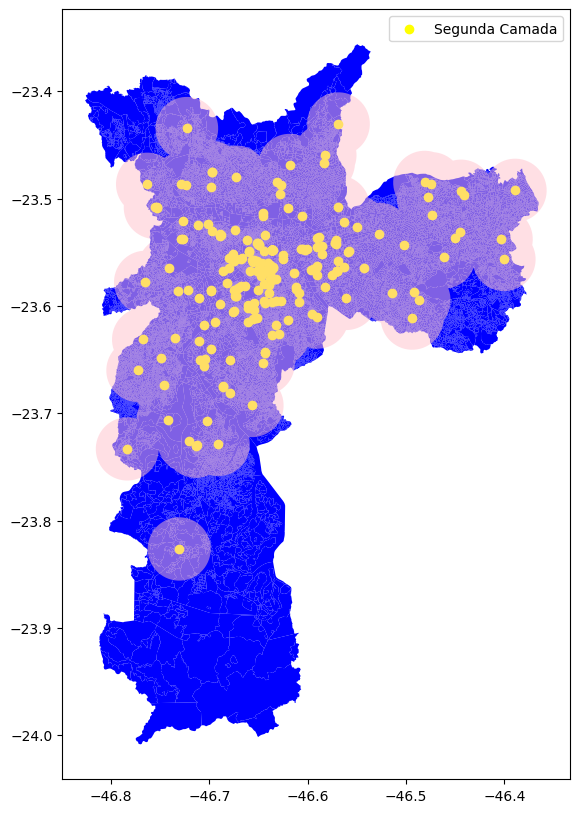

In [46]:
gdf2 = setores_maps.copy()
gdf5 = hospitais_cnes_to_buffer.copy()
gdf6 = hospitais_cnes_with_buffer.copy()
over_lay_view_plot = hospitais_over_lay_view.copy()
fig, ax = plt.subplots(figsize=(10, 10))

gdf2.GEOMETRY.plot(ax=ax, color='blue', alpha=1, label='Primeira Camada')
gdf5.point.plot(ax=ax, color='yellow', alpha=1, label='Segunda Camada')
# gdf6.point.plot(ax=ax, color='pink', alpha=0.5, label='Terceira Camada')
over_lay_view_plot.plot(ax=ax, color='pink', alpha=0.5, label='Terceira Camada')
plt.legend()
plt.show()

### Criar Indicadores com porcentagem das areas

In [47]:
# Verificação Setores Interceptado

hospitais_populacao_distrital: list = []
hospitais_porcentagem_coberturas: list = []
for row in hospitais_over_lay_view.itertuples():
  for row_setores in setores_maps.itertuples():
    if row.point.intersects(row_setores.GEOMETRY):
      hospitais_populacao_distrital.append(row_setores)
      hospitais_porcentagem_coberturas.append(overlap_percentage(row.point, row_setores.GEOMETRY))

### % da população distrital a até 5 km de um Hospital

Seguinte fórmula:

$\text{
% da população distrital a até 5 km de um Hospital} = \frac{\text{Pessoas dentro de 5km da Hospital}}{\text{Total População}} \times 100$

Indicadores resultante desse codigo:
- % da população distrital a até 5 km de um Hospital


In [48]:
# >>_% da população distrital a até 5 km de um Hospital - Censo 2022|CNES 2025_<<


nome_indicador = '% da população distrital a até 5 km de um Hospital - Censo 2022|CNES 2025'

hospitais_df_populacao_distrital_porcent = pd.DataFrame(hospitais_populacao_distrital)
hospitais_df_populacao_distrital_porcent['area_coberta_hospital'] = hospitais_porcentagem_coberturas
hospitais_df_populacao_distrital_porcent.V0001 = hospitais_df_populacao_distrital_porcent.V0001.astype(int)

hospitais_indicador_populacao_distrital_final_porcent = hospitais_df_populacao_distrital_porcent.groupby(['NM_DIST', 'CD_SETOR', 'V0001'], as_index=False).area_coberta_hospital.sum()
hospitais_indicador_populacao_distrital_final_porcent[nome_indicador] = (hospitais_indicador_populacao_distrital_final_porcent['area_coberta_hospital'] / 100) * hospitais_indicador_populacao_distrital_final_porcent.V0001
hospitais_indicador_populacao_distrital_final_porcent[nome_indicador] = hospitais_indicador_populacao_distrital_final_porcent[nome_indicador].round(3)

hospitais_indicador_populacao_distrital_final_porcent = hospitais_indicador_populacao_distrital_final_porcent.groupby('NM_DIST')[nome_indicador].sum().to_frame(nome_indicador)

hospitais_total_populacao_porcent = setores_maps.groupby('NM_DIST').V0001.sum().to_frame('Total População')

hospitais_indicador_populacao_distrital_final_porcent = pd.concat([hospitais_indicador_populacao_distrital_final_porcent, hospitais_total_populacao_porcent], axis=1)
hospitais_indicador_populacao_distrital_final_porcent = ((hospitais_indicador_populacao_distrital_final_porcent[nome_indicador] / hospitais_indicador_populacao_distrital_final_porcent['Total População']) * 100).round(3).to_frame(nome_indicador)

# ObservaSampa

- Taxa de distorção da idade-ano para o ano no Ensino Fundamental nos anos iniciais (%) - ObservaSampa 2023
- Taxa de distorção da idade-ano para o ano no Ensino Fundamental nos anos finais (%) - ObservaSampa 2023


## Taxa de distorção da idade-ano para o ano no Ensino Fundamental nos anos iniciais (%)

Indicadores resultante desse codigo:
- Taxa de distorção da idade-ano para o ano no Ensino Fundamental nos anos iniciais (%) - ObservaSampa 2023

In [49]:
# >>_Taxa de distorção da idade-ano para o ano no Ensino Fundamental nos anos iniciais (%) - ObservaSampa 2023_<<


url = 'https://observasampa.prefeitura.sp.gov.br/arquivo.php?cd_indicador=572'
distorcao_ensino_fundamental_iniciais = pd.read_csv(url, sep=';')
selected_distrito = distorcao_ensino_fundamental_iniciais.nivel_regional == 'Distrito'
distorcao_ensino_fundamental_iniciais = distorcao_ensino_fundamental_iniciais[selected_distrito]
distorcao_ensino_fundamental_iniciais.index = distorcao_ensino_fundamental_iniciais['região']
distorcao_ensino_fundamental_iniciais = distorcao_ensino_fundamental_iniciais['2023'].to_frame('Taxa de distorção da idade-ano para o ano no Ensino Fundamental nos anos iniciais (%) - ObservaSampa 2023')

## Taxa de distorção da idade-ano para o ano no Ensino Fundamental nos anos finais (%)

Indicadores resultante desse codigo:
- Taxa de distorção da idade-ano para o ano no Ensino Fundamental nos anos finais (%) - ObservaSampa 2023

In [50]:
# >>_Taxa de distorção da idade-ano para o ano no Ensino Fundamental nos anos finais (%) - ObservaSampa 2023_<<


url = 'https://observasampa.prefeitura.sp.gov.br/arquivo.php?cd_indicador=573'
distorcao_ensino_fundamental_finais = pd.read_csv(url, sep=';')
selected_distrito = distorcao_ensino_fundamental_finais.nivel_regional == 'Distrito'
distorcao_ensino_fundamental_finais = distorcao_ensino_fundamental_finais[selected_distrito]
distorcao_ensino_fundamental_finais.index = distorcao_ensino_fundamental_finais['região']
distorcao_ensino_fundamental_finais = distorcao_ensino_fundamental_finais['2023'].to_frame('Taxa de distorção da idade-ano para o ano no Ensino Fundamental nos anos finais (%) - ObservaSampa 2023')

# [Tabnet DATASUS][tabnet]

Indicadores:

- [x] Proporção de nascidos vivos de mães que fizeram 7 ou mais consultas de pré natal - Tabnet DATASUS 2024 -> [Codigo][indicadores_21]
- [x] Proporção de bebês com baixo peso ao nascer (menos de 2,5 kg) - Tabnet DATASUS 2024 -> [Codigo][indicadores_22]
- [x] Proporção de bebês nascidos vivos de mães adolescentes (10 a 19 anos) - Tabnet DATASUS 2024 -> [Codigo][indicadores_23]

[tabnet]: https://capital.sp.gov.br/web/saude/tabnet/

<!-- Proporção de nascidos vivos de mães que fizeram 7 ou mais consultas de pré natal - Tabnet DATASUS 2024 -->
[indicadores_21]: https://colab.research.google.com/drive/14jIloiip7s8xnTffYS55Q0lF8Etwz5W5#scrollTo=uAGYq3rLwomF&uniqifier=1

<!-- Proporção de bebês com baixo peso ao nascer (menos de 2,5 kg) - Tabnet DATASUS 2024 -->
[indicadores_22]: https://colab.research.google.com/drive/14jIloiip7s8xnTffYS55Q0lF8Etwz5W5#scrollTo=Sfeenf2N7Zfr&uniqifier=1

<!-- Proporção de bebês nascidos vivos de mães adolescentes (10 a 19 anos) - Tabnet DATASUS 2024 -->
[indicadores_23]: https://colab.research.google.com/drive/14jIloiip7s8xnTffYS55Q0lF8Etwz5W5#scrollTo=IlPIvhaDMOGv&uniqifier=1

## Proporção de nascidos vivos de mães que fizeram 7 ou mais consultas de pré natal

Seguinte fórmula:

$\text{
Proporção de nascidos vivos de mães que fizeram 7 ou mais consultas de pré natal} = \frac{\text{nascidos vivos de mães que fizeram 7 ou mais consultas de pré natal}}{\text{Total de Nascidos Vivos}} \times 100$

Indicadores resultante desse codigo:

- Proporção de nascidos vivos de mães que fizeram 7 ou mais consultas de pré natal - Tabnet DATASUS 2024


In [51]:
# >>_Proporção de nascidos vivos de mães que fizeram 7 ou mais consultas de pré natal - Tabnet DATASUS 2024_<<


indicador_name = 'Proporção de nascidos vivos de mães que fizeram 7 ou mais consultas de pré natal - Tabnet DATASUS 2024'

attrs = {'class': 'tabdados'}

columns = ['Distritos', 'Nenhuma', '1 a 3 consultas',
       '4 a 6 consultas', '7 consultas e +', 'Ignorado', 'Total']

columns_final = ['Nascidos vivos de mães que fizeram 7 ou mais consultas de pré natal - Tabnet DATASUS 2024',
                 'Total nascidos vivos - Tabnet DATASUS 2024',
                 f'{indicador_name} - Tabnet DATASUS 2024']


conteudo = 'NV_de_partos_ocorridos_MSP' # NV de partos ocorridos MSP por Consulta pré-natal segundo Distrito Administ. residência Período: 2024
conteudo = 'NV_parturientes_residentes_MSP' # NV parturientes residentes MSP por Consulta pré-natal segundo Distrito Administ. residência Período: 2024

data = f"Linha=Distrito_Administ._resid%EAncia&Coluna=Consulta_pr%E9-natal&Incremento={conteudo}&Arquivos=dnsp24.dbf&pesqmes1=Digite+o+texto+e+ache+f%E1cil&SAno_nascimento=TODAS_AS_CATEGORIAS__&pesqmes2=Digite+o+texto+e+ache+f%E1cil&SM%EAs_nascimento=TODAS_AS_CATEGORIAS__&pesqmes3=Digite+o+texto+e+ache+f%E1cil&SM%EAs%2FAno_nascimento=TODAS_AS_CATEGORIAS__&pesqmes4=Digite+o+texto+e+ache+f%E1cil&SDistrito_Administ._resid%EAncia=TODAS_AS_CATEGORIAS__&pesqmes5=Digite+o+texto+e+ache+f%E1cil&SSubPrefeitura_resid%EAncia=TODAS_AS_CATEGORIAS__&pesqmes6=Digite+o+texto+e+ache+f%E1cil&SSupervis%E3o_T._Sa%FAde_resid%EAncia=TODAS_AS_CATEGORIAS__&SCoord._Reg._Sa%FAde_resid%EAncia=TODAS_AS_CATEGORIAS__&pesqmes8=Digite+o+texto+e+ache+f%E1cil&SMunic%EDpio_resid%EAncia=TODAS_AS_CATEGORIAS__&SMunic_SP_resid_s%2Fn=TODAS_AS_CATEGORIAS__&pesqmes10=Digite+o+texto+e+ache+f%E1cil&SSubPrefeitura_ocorr%EAncia=TODAS_AS_CATEGORIAS__&pesqmes11=Digite+o+texto+e+ache+f%E1cil&SSupervis%E3o_T._Sa%FAde_ocorr%EAncia=TODAS_AS_CATEGORIAS__&SCoord._Reg._Sa%FAde_ocorr%EAncia=TODAS_AS_CATEGORIAS__&pesqmes13=Digite+o+texto+e+ache+f%E1cil&SMunic%EDpio_ocorr%EAncia=TODAS_AS_CATEGORIAS__&SMunic_SP_ocorr_s%2Fn=TODAS_AS_CATEGORIAS__&SLocal_ocorr%EAncia=TODAS_AS_CATEGORIAS__&pesqmes16=Digite+o+texto+e+ache+f%E1cil&SHosp._ocorr%EAncia_munic%EDpio_SP=TODAS_AS_CATEGORIAS__&pesqmes17=Digite+o+texto+e+ache+f%E1cil&SHospital_por_tipo_gest%E3o=TODAS_AS_CATEGORIAS__&SSexo=TODAS_AS_CATEGORIAS__&pesqmes19=Digite+o+texto+e+ache+f%E1cil&SPeso_ao_nascer=TODAS_AS_CATEGORIAS__&SApgar_1%BA_min_faixa=TODAS_AS_CATEGORIAS__&SApgar_5%BA_min_faixa=TODAS_AS_CATEGORIAS__&pesqmes22=Digite+o+texto+e+ache+f%E1cil&SApgar_1%BA_min_detalhado=TODAS_AS_CATEGORIAS__&pesqmes23=Digite+o+texto+e+ache+f%E1cil&SApgar_5%BA_min_detalhado=TODAS_AS_CATEGORIAS__&SPresen%E7a_anomalia_cong%EAnita=TODAS_AS_CATEGORIAS__&pesqmes25=Digite+o+texto+e+ache+f%E1cil&SAnomalia_01_CID_3C=TODAS_AS_CATEGORIAS__&pesqmes26=Digite+o+texto+e+ache+f%E1cil&SAnomalia_02_CID_3C=TODAS_AS_CATEGORIAS__&pesqmes27=Digite+o+texto+e+ache+f%E1cil&SAnomalia_03_CID_3C=TODAS_AS_CATEGORIAS__&pesqmes28=Digite+o+texto+e+ache+f%E1cil&SAnomalia_04_CID_3C=TODAS_AS_CATEGORIAS__&pesqmes29=Digite+o+texto+e+ache+f%E1cil&SAnomalia_05_CID_3C=TODAS_AS_CATEGORIAS__&pesqmes30=Digite+o+texto+e+ache+f%E1cil&SAnomalia_06_CID_3C=TODAS_AS_CATEGORIAS__&pesqmes31=Digite+o+texto+e+ache+f%E1cil&SAnomalia_07_CID_3C=TODAS_AS_CATEGORIAS__&pesqmes32=Digite+o+texto+e+ache+f%E1cil&SAnomalia_08_CID_3C=TODAS_AS_CATEGORIAS__&pesqmes33=Digite+o+texto+e+ache+f%E1cil&SAnomalia_09_CID_3C=TODAS_AS_CATEGORIAS__&pesqmes34=Digite+o+texto+e+ache+f%E1cil&SAnomalia_10_CID_3C=TODAS_AS_CATEGORIAS__&pesqmes35=Digite+o+texto+e+ache+f%E1cil&SAnomalia_11_CID_3C=TODAS_AS_CATEGORIAS__&pesqmes36=Digite+o+texto+e+ache+f%E1cil&SAnomalia_12_CID_3C=TODAS_AS_CATEGORIAS__&SDura%E7%E3o_gesta%E7%E3o=TODAS_AS_CATEGORIAS__&pesqmes38=Digite+o+texto+e+ache+f%E1cil&SIdade_Gestacional*=TODAS_AS_CATEGORIAS__&SIdade_Gestacional_faixa*=TODAS_AS_CATEGORIAS__&SConsulta_pr%E9-natal=TODAS_AS_CATEGORIAS__&pesqmes41=Digite+o+texto+e+ache+f%E1cil&SM%EAs_1%AA_consulta*=TODAS_AS_CATEGORIAS__&STipo_de_gravidez=TODAS_AS_CATEGORIAS__&SApresenta%E7%E3o_fetal*=TODAS_AS_CATEGORIAS__&SIndu%E7%E3o_ao_trabalho_parto*=TODAS_AS_CATEGORIAS__&STipo_de_parto=TODAS_AS_CATEGORIAS__&SCes%E1rea_e_trabalho_parto_%28TP%29*=TODAS_AS_CATEGORIAS__&SGesta%E7%F5es_anteriores*=TODAS_AS_CATEGORIAS__&pesqmes48=Digite+o+texto+e+ache+f%E1cil&SPartos_vaginais_anteriores*=TODAS_AS_CATEGORIAS__&pesqmes49=Digite+o+texto+e+ache+f%E1cil&SPartos_ces%E1reos_anteriores*=TODAS_AS_CATEGORIAS__&pesqmes50=Digite+o+texto+e+ache+f%E1cil&SGrupos_de_Robson*=TODAS_AS_CATEGORIAS__&pesqmes51=Digite+o+texto+e+ache+f%E1cil&SFaixa_et%E1ria_m%E3e=TODAS_AS_CATEGORIAS__&pesqmes52=Digite+o+texto+e+ache+f%E1cil&SNacionalidade_m%E3e_%28pa%EDs%29*=TODAS_AS_CATEGORIAS__&pesqmes53=Digite+o+texto+e+ache+f%E1cil&SNaturalidade_m%E3e_%28estado%29*=TODAS_AS_CATEGORIAS__&pesqmes54=Digite+o+texto+e+ache+f%E1cil&SMunic%EDpio_naturalidade_m%E3e*=TODAS_AS_CATEGORIAS__&SEscolaridade_m%E3e=TODAS_AS_CATEGORIAS__&SRaca%2Fcor_m%E3e_*=TODAS_AS_CATEGORIAS__&SSitua%E7%E3o_conjugal_m%E3e=TODAS_AS_CATEGORIAS__&pesqmes58=Digite+o+texto+e+ache+f%E1cil&SFaixa_et%E1ria_pai*=TODAS_AS_CATEGORIAS__&formato=table&mostre=Mostra"

url = "http://tabnet.saude.prefeitura.sp.gov.br/cgi/tabcgi.exe?secretarias/saude/TABNET/sinasc/nascido.def"

tabnet_post = requests.post(url=url, data=data)

tabnet_pre_natal = pd.read_html(StringIO(tabnet_post.text), attrs=attrs)[0]

tabnet_pre_natal.columns = columns
tabnet_pre_natal = tabnet_pre_natal.iloc[1:-2]
tabnet_pre_natal.index = tabnet_pre_natal.Distritos
tabnet_pre_natal[['7 consultas e +', 'Total']] =  tabnet_pre_natal[['7 consultas e +', 'Total']].map(lambda row: row.replace('.', ''))
tabnet_pre_natal[['7 consultas e +', 'Total']] =  tabnet_pre_natal[['7 consultas e +', 'Total']].astype(int)

tabnet_pre_natal = ((tabnet_pre_natal['7 consultas e +'] / tabnet_pre_natal['Total']) * 100).round(3).to_frame(indicador_name)

## Proporção de bebês com baixo peso ao nascer (menos de 2,5 kg)

Seguinte fórmula:

$\text{
Proporção de bebês com baixo peso ao nascer (menos de 2,5 kg)} = \frac{\text{bebês com baixo peso ao nascer (menos de 2,5 kg)}}{\text{Total de Nascidos Vivos}} \times 100$

Indicadores resultante desse codigo:
- Proporção de bebês com baixo peso ao nascer (menos de 2,5 kg) - Tabnet DATASUS 2024

In [52]:
# >>_Proporção de bebês com baixo peso ao nascer (menos de 2,5 kg) - Tabnet DATASUS 2024_<<



indicador_name = 'Proporção de bebês com baixo peso ao nascer (menos de 2,5 kg) - Tabnet DATASUS 2024'

attrs = {'class': 'tabdados'}

columns = ['Distritos',
          '< 500g',
          '500g a 999g',
          '1000g a 1499g',
           '1500g a 1999g',
           '2000g a 2499g',
           '2500g a 2999g',
           '3000g a 3499g',
           '3500g a 3999g',
           '4000g e +',
           'Total']

conteudo = 'NV_de_partos_ocorridos_MSP' # NV de partos ocorridos MSP por Consulta pré-natal segundo Distrito Administ. residência Período: 2024
conteudo = 'NV_parturientes_residentes_MSP' # NV parturientes residentes MSP por Consulta pré-natal segundo Distrito Administ. residência Período: 2024

coluna = 'Peso_ao_nascer'

data = f"Linha=Distrito_Administ._resid%EAncia&Coluna={coluna}&Incremento={conteudo}&Arquivos=dnsp24.dbf&pesqmes1=Digite+o+texto+e+ache+f%E1cil&SAno_nascimento=TODAS_AS_CATEGORIAS__&pesqmes2=Digite+o+texto+e+ache+f%E1cil&SM%EAs_nascimento=TODAS_AS_CATEGORIAS__&pesqmes3=Digite+o+texto+e+ache+f%E1cil&SM%EAs%2FAno_nascimento=TODAS_AS_CATEGORIAS__&pesqmes4=Digite+o+texto+e+ache+f%E1cil&SDistrito_Administ._resid%EAncia=TODAS_AS_CATEGORIAS__&pesqmes5=Digite+o+texto+e+ache+f%E1cil&SSubPrefeitura_resid%EAncia=TODAS_AS_CATEGORIAS__&pesqmes6=Digite+o+texto+e+ache+f%E1cil&SSupervis%E3o_T._Sa%FAde_resid%EAncia=TODAS_AS_CATEGORIAS__&SCoord._Reg._Sa%FAde_resid%EAncia=TODAS_AS_CATEGORIAS__&pesqmes8=Digite+o+texto+e+ache+f%E1cil&SMunic%EDpio_resid%EAncia=TODAS_AS_CATEGORIAS__&SMunic_SP_resid_s%2Fn=TODAS_AS_CATEGORIAS__&pesqmes10=Digite+o+texto+e+ache+f%E1cil&SSubPrefeitura_ocorr%EAncia=TODAS_AS_CATEGORIAS__&pesqmes11=Digite+o+texto+e+ache+f%E1cil&SSupervis%E3o_T._Sa%FAde_ocorr%EAncia=TODAS_AS_CATEGORIAS__&SCoord._Reg._Sa%FAde_ocorr%EAncia=TODAS_AS_CATEGORIAS__&pesqmes13=Digite+o+texto+e+ache+f%E1cil&SMunic%EDpio_ocorr%EAncia=TODAS_AS_CATEGORIAS__&SMunic_SP_ocorr_s%2Fn=TODAS_AS_CATEGORIAS__&SLocal_ocorr%EAncia=TODAS_AS_CATEGORIAS__&pesqmes16=Digite+o+texto+e+ache+f%E1cil&SHosp._ocorr%EAncia_munic%EDpio_SP=TODAS_AS_CATEGORIAS__&pesqmes17=Digite+o+texto+e+ache+f%E1cil&SHospital_por_tipo_gest%E3o=TODAS_AS_CATEGORIAS__&SSexo=TODAS_AS_CATEGORIAS__&pesqmes19=Digite+o+texto+e+ache+f%E1cil&SPeso_ao_nascer=TODAS_AS_CATEGORIAS__&SApgar_1%BA_min_faixa=TODAS_AS_CATEGORIAS__&SApgar_5%BA_min_faixa=TODAS_AS_CATEGORIAS__&pesqmes22=Digite+o+texto+e+ache+f%E1cil&SApgar_1%BA_min_detalhado=TODAS_AS_CATEGORIAS__&pesqmes23=Digite+o+texto+e+ache+f%E1cil&SApgar_5%BA_min_detalhado=TODAS_AS_CATEGORIAS__&SPresen%E7a_anomalia_cong%EAnita=TODAS_AS_CATEGORIAS__&pesqmes25=Digite+o+texto+e+ache+f%E1cil&SAnomalia_01_CID_3C=TODAS_AS_CATEGORIAS__&pesqmes26=Digite+o+texto+e+ache+f%E1cil&SAnomalia_02_CID_3C=TODAS_AS_CATEGORIAS__&pesqmes27=Digite+o+texto+e+ache+f%E1cil&SAnomalia_03_CID_3C=TODAS_AS_CATEGORIAS__&pesqmes28=Digite+o+texto+e+ache+f%E1cil&SAnomalia_04_CID_3C=TODAS_AS_CATEGORIAS__&pesqmes29=Digite+o+texto+e+ache+f%E1cil&SAnomalia_05_CID_3C=TODAS_AS_CATEGORIAS__&pesqmes30=Digite+o+texto+e+ache+f%E1cil&SAnomalia_06_CID_3C=TODAS_AS_CATEGORIAS__&pesqmes31=Digite+o+texto+e+ache+f%E1cil&SAnomalia_07_CID_3C=TODAS_AS_CATEGORIAS__&pesqmes32=Digite+o+texto+e+ache+f%E1cil&SAnomalia_08_CID_3C=TODAS_AS_CATEGORIAS__&pesqmes33=Digite+o+texto+e+ache+f%E1cil&SAnomalia_09_CID_3C=TODAS_AS_CATEGORIAS__&pesqmes34=Digite+o+texto+e+ache+f%E1cil&SAnomalia_10_CID_3C=TODAS_AS_CATEGORIAS__&pesqmes35=Digite+o+texto+e+ache+f%E1cil&SAnomalia_11_CID_3C=TODAS_AS_CATEGORIAS__&pesqmes36=Digite+o+texto+e+ache+f%E1cil&SAnomalia_12_CID_3C=TODAS_AS_CATEGORIAS__&SDura%E7%E3o_gesta%E7%E3o=TODAS_AS_CATEGORIAS__&pesqmes38=Digite+o+texto+e+ache+f%E1cil&SIdade_Gestacional*=TODAS_AS_CATEGORIAS__&SIdade_Gestacional_faixa*=TODAS_AS_CATEGORIAS__&SConsulta_pr%E9-natal=TODAS_AS_CATEGORIAS__&pesqmes41=Digite+o+texto+e+ache+f%E1cil&SM%EAs_1%AA_consulta*=TODAS_AS_CATEGORIAS__&STipo_de_gravidez=TODAS_AS_CATEGORIAS__&SApresenta%E7%E3o_fetal*=TODAS_AS_CATEGORIAS__&SIndu%E7%E3o_ao_trabalho_parto*=TODAS_AS_CATEGORIAS__&STipo_de_parto=TODAS_AS_CATEGORIAS__&SCes%E1rea_e_trabalho_parto_%28TP%29*=TODAS_AS_CATEGORIAS__&SGesta%E7%F5es_anteriores*=TODAS_AS_CATEGORIAS__&pesqmes48=Digite+o+texto+e+ache+f%E1cil&SPartos_vaginais_anteriores*=TODAS_AS_CATEGORIAS__&pesqmes49=Digite+o+texto+e+ache+f%E1cil&SPartos_ces%E1reos_anteriores*=TODAS_AS_CATEGORIAS__&pesqmes50=Digite+o+texto+e+ache+f%E1cil&SGrupos_de_Robson*=TODAS_AS_CATEGORIAS__&pesqmes51=Digite+o+texto+e+ache+f%E1cil&SFaixa_et%E1ria_m%E3e=TODAS_AS_CATEGORIAS__&pesqmes52=Digite+o+texto+e+ache+f%E1cil&SNacionalidade_m%E3e_%28pa%EDs%29*=TODAS_AS_CATEGORIAS__&pesqmes53=Digite+o+texto+e+ache+f%E1cil&SNaturalidade_m%E3e_%28estado%29*=TODAS_AS_CATEGORIAS__&pesqmes54=Digite+o+texto+e+ache+f%E1cil&SMunic%EDpio_naturalidade_m%E3e*=TODAS_AS_CATEGORIAS__&SEscolaridade_m%E3e=TODAS_AS_CATEGORIAS__&SRaca%2Fcor_m%E3e_*=TODAS_AS_CATEGORIAS__&SSitua%E7%E3o_conjugal_m%E3e=TODAS_AS_CATEGORIAS__&pesqmes58=Digite+o+texto+e+ache+f%E1cil&SFaixa_et%E1ria_pai*=TODAS_AS_CATEGORIAS__&formato=table&mostre=Mostra"

url = "http://tabnet.saude.prefeitura.sp.gov.br/cgi/tabcgi.exe?secretarias/saude/TABNET/sinasc/nascido.def"

tabnet_post = requests.post(url=url, data=data)

tabnet_baixo_peso = pd.read_html(StringIO(tabnet_post.text), attrs=attrs)[0]

tabnet_baixo_peso = tabnet_baixo_peso.iloc[1:-2, :-1]
tabnet_baixo_peso.columns = columns
tabnet_baixo_peso.index = tabnet_baixo_peso.Distritos
tabnet_baixo_peso.drop('Distritos', inplace=True, axis=1)

tabnet_baixo_peso = tabnet_baixo_peso.map(lambda row: row.replace('-', '0'))
tabnet_baixo_peso = tabnet_baixo_peso.map(lambda row: row.replace('.', ''))
tabnet_baixo_peso = tabnet_baixo_peso.astype(int)

tabnet_baixo_peso["Bebês com baixo peso ao nascer (menos de 2,5 kg) - Tabnet DATASUS 2024"] = tabnet_baixo_peso.iloc[:, :5].sum(axis=1)
tabnet_baixo_peso = ((tabnet_baixo_peso['Bebês com baixo peso ao nascer (menos de 2,5 kg) - Tabnet DATASUS 2024'] / tabnet_baixo_peso['Total']) * 100).round(3).to_frame(indicador_name)

## Proporção de bebês nascidos vivos de mães adolescentes (10 a 19 anos)

Seguinte fórmula:

$\text{
Proporção de bebês nascidos vivos de mães adolescentes (10 a 19 anos)} = \frac{\text{Nascidos vivos de mães adolescentes (10 a 19 anos)}}{\text{Total de Nascidos Vivos}} \times 100$

Indicadores resultante desse codigo:
- Bebês nascidos vivos de mães adolescentes (10 a 19 anos) - Tabnet DATASUS 2024


In [53]:
# >>_Proporção de bebês nascidos vivos de mães adolescentes (10 a 19 anos) - Tabnet DATASUS 2024_<<



indicador_name = 'Proporção de bebês nascidos vivos de mães adolescentes (10 a 19 anos) - Tabnet DATASUS 2024'

attrs = {'class': 'tabdados'}

columns = ['Distritos', '10 a 14', '15 a 19', '20 a 24', '25 a 29', '30 a 34', '35 a 39', '40 a 44', '45 a 49', '50 a 54', '55 a 59', '60 e mais', 'Total']

conteudo = 'NV_de_partos_ocorridos_MSP' # NV de partos ocorridos MSP por Consulta pré-natal segundo Distrito Administ. residência Período: 2024
conteudo = 'NV_parturientes_residentes_MSP' # NV parturientes residentes MSP por Consulta pré-natal segundo Distrito Administ. residência Período: 2024

coluna = 'Faixa_et%E1ria_m%E3e'

data = f"Linha=Distrito_Administ._resid%EAncia&Coluna={coluna}&Incremento={conteudo}&Arquivos=dnsp24.dbf&pesqmes1=Digite+o+texto+e+ache+f%E1cil&SAno_nascimento=TODAS_AS_CATEGORIAS__&pesqmes2=Digite+o+texto+e+ache+f%E1cil&SM%EAs_nascimento=TODAS_AS_CATEGORIAS__&pesqmes3=Digite+o+texto+e+ache+f%E1cil&SM%EAs%2FAno_nascimento=TODAS_AS_CATEGORIAS__&pesqmes4=Digite+o+texto+e+ache+f%E1cil&SDistrito_Administ._resid%EAncia=TODAS_AS_CATEGORIAS__&pesqmes5=Digite+o+texto+e+ache+f%E1cil&SSubPrefeitura_resid%EAncia=TODAS_AS_CATEGORIAS__&pesqmes6=Digite+o+texto+e+ache+f%E1cil&SSupervis%E3o_T._Sa%FAde_resid%EAncia=TODAS_AS_CATEGORIAS__&SCoord._Reg._Sa%FAde_resid%EAncia=TODAS_AS_CATEGORIAS__&pesqmes8=Digite+o+texto+e+ache+f%E1cil&SMunic%EDpio_resid%EAncia=TODAS_AS_CATEGORIAS__&SMunic_SP_resid_s%2Fn=TODAS_AS_CATEGORIAS__&pesqmes10=Digite+o+texto+e+ache+f%E1cil&SSubPrefeitura_ocorr%EAncia=TODAS_AS_CATEGORIAS__&pesqmes11=Digite+o+texto+e+ache+f%E1cil&SSupervis%E3o_T._Sa%FAde_ocorr%EAncia=TODAS_AS_CATEGORIAS__&SCoord._Reg._Sa%FAde_ocorr%EAncia=TODAS_AS_CATEGORIAS__&pesqmes13=Digite+o+texto+e+ache+f%E1cil&SMunic%EDpio_ocorr%EAncia=TODAS_AS_CATEGORIAS__&SMunic_SP_ocorr_s%2Fn=TODAS_AS_CATEGORIAS__&SLocal_ocorr%EAncia=TODAS_AS_CATEGORIAS__&pesqmes16=Digite+o+texto+e+ache+f%E1cil&SHosp._ocorr%EAncia_munic%EDpio_SP=TODAS_AS_CATEGORIAS__&pesqmes17=Digite+o+texto+e+ache+f%E1cil&SHospital_por_tipo_gest%E3o=TODAS_AS_CATEGORIAS__&SSexo=TODAS_AS_CATEGORIAS__&pesqmes19=Digite+o+texto+e+ache+f%E1cil&SPeso_ao_nascer=TODAS_AS_CATEGORIAS__&SApgar_1%BA_min_faixa=TODAS_AS_CATEGORIAS__&SApgar_5%BA_min_faixa=TODAS_AS_CATEGORIAS__&pesqmes22=Digite+o+texto+e+ache+f%E1cil&SApgar_1%BA_min_detalhado=TODAS_AS_CATEGORIAS__&pesqmes23=Digite+o+texto+e+ache+f%E1cil&SApgar_5%BA_min_detalhado=TODAS_AS_CATEGORIAS__&SPresen%E7a_anomalia_cong%EAnita=TODAS_AS_CATEGORIAS__&pesqmes25=Digite+o+texto+e+ache+f%E1cil&SAnomalia_01_CID_3C=TODAS_AS_CATEGORIAS__&pesqmes26=Digite+o+texto+e+ache+f%E1cil&SAnomalia_02_CID_3C=TODAS_AS_CATEGORIAS__&pesqmes27=Digite+o+texto+e+ache+f%E1cil&SAnomalia_03_CID_3C=TODAS_AS_CATEGORIAS__&pesqmes28=Digite+o+texto+e+ache+f%E1cil&SAnomalia_04_CID_3C=TODAS_AS_CATEGORIAS__&pesqmes29=Digite+o+texto+e+ache+f%E1cil&SAnomalia_05_CID_3C=TODAS_AS_CATEGORIAS__&pesqmes30=Digite+o+texto+e+ache+f%E1cil&SAnomalia_06_CID_3C=TODAS_AS_CATEGORIAS__&pesqmes31=Digite+o+texto+e+ache+f%E1cil&SAnomalia_07_CID_3C=TODAS_AS_CATEGORIAS__&pesqmes32=Digite+o+texto+e+ache+f%E1cil&SAnomalia_08_CID_3C=TODAS_AS_CATEGORIAS__&pesqmes33=Digite+o+texto+e+ache+f%E1cil&SAnomalia_09_CID_3C=TODAS_AS_CATEGORIAS__&pesqmes34=Digite+o+texto+e+ache+f%E1cil&SAnomalia_10_CID_3C=TODAS_AS_CATEGORIAS__&pesqmes35=Digite+o+texto+e+ache+f%E1cil&SAnomalia_11_CID_3C=TODAS_AS_CATEGORIAS__&pesqmes36=Digite+o+texto+e+ache+f%E1cil&SAnomalia_12_CID_3C=TODAS_AS_CATEGORIAS__&SDura%E7%E3o_gesta%E7%E3o=TODAS_AS_CATEGORIAS__&pesqmes38=Digite+o+texto+e+ache+f%E1cil&SIdade_Gestacional*=TODAS_AS_CATEGORIAS__&SIdade_Gestacional_faixa*=TODAS_AS_CATEGORIAS__&SConsulta_pr%E9-natal=TODAS_AS_CATEGORIAS__&pesqmes41=Digite+o+texto+e+ache+f%E1cil&SM%EAs_1%AA_consulta*=TODAS_AS_CATEGORIAS__&STipo_de_gravidez=TODAS_AS_CATEGORIAS__&SApresenta%E7%E3o_fetal*=TODAS_AS_CATEGORIAS__&SIndu%E7%E3o_ao_trabalho_parto*=TODAS_AS_CATEGORIAS__&STipo_de_parto=TODAS_AS_CATEGORIAS__&SCes%E1rea_e_trabalho_parto_%28TP%29*=TODAS_AS_CATEGORIAS__&SGesta%E7%F5es_anteriores*=TODAS_AS_CATEGORIAS__&pesqmes48=Digite+o+texto+e+ache+f%E1cil&SPartos_vaginais_anteriores*=TODAS_AS_CATEGORIAS__&pesqmes49=Digite+o+texto+e+ache+f%E1cil&SPartos_ces%E1reos_anteriores*=TODAS_AS_CATEGORIAS__&pesqmes50=Digite+o+texto+e+ache+f%E1cil&SGrupos_de_Robson*=TODAS_AS_CATEGORIAS__&pesqmes51=Digite+o+texto+e+ache+f%E1cil&SFaixa_et%E1ria_m%E3e=TODAS_AS_CATEGORIAS__&pesqmes52=Digite+o+texto+e+ache+f%E1cil&SNacionalidade_m%E3e_%28pa%EDs%29*=TODAS_AS_CATEGORIAS__&pesqmes53=Digite+o+texto+e+ache+f%E1cil&SNaturalidade_m%E3e_%28estado%29*=TODAS_AS_CATEGORIAS__&pesqmes54=Digite+o+texto+e+ache+f%E1cil&SMunic%EDpio_naturalidade_m%E3e*=TODAS_AS_CATEGORIAS__&SEscolaridade_m%E3e=TODAS_AS_CATEGORIAS__&SRaca%2Fcor_m%E3e_*=TODAS_AS_CATEGORIAS__&SSitua%E7%E3o_conjugal_m%E3e=TODAS_AS_CATEGORIAS__&pesqmes58=Digite+o+texto+e+ache+f%E1cil&SFaixa_et%E1ria_pai*=TODAS_AS_CATEGORIAS__&formato=table&mostre=Mostra"

url = "http://tabnet.saude.prefeitura.sp.gov.br/cgi/tabcgi.exe?secretarias/saude/TABNET/sinasc/nascido.def"

tabnet_post = requests.post(url=url, data=data)

tabnet_maes_adolescentes = pd.read_html(StringIO(tabnet_post.text), attrs=attrs)[0]

tabnet_maes_adolescentes = tabnet_maes_adolescentes.iloc[1:-2, :-2]
tabnet_maes_adolescentes.columns = columns
tabnet_maes_adolescentes.index = tabnet_maes_adolescentes.Distritos
tabnet_maes_adolescentes.drop('Distritos', inplace=True, axis=1)

tabnet_maes_adolescentes = tabnet_maes_adolescentes.map(lambda row: row.replace('-', '0'))
tabnet_maes_adolescentes = tabnet_maes_adolescentes.map(lambda row: row.replace('.', ''))
tabnet_maes_adolescentes = tabnet_maes_adolescentes.astype(int)

tabnet_maes_adolescentes["Bebês nascidos vivos de mães adolescentes (10 a 19 anos) - Tabnet DATASUS 2024"] = tabnet_maes_adolescentes.iloc[:, :2].sum(axis=1)
tabnet_maes_adolescentes = ((tabnet_maes_adolescentes['Bebês nascidos vivos de mães adolescentes (10 a 19 anos) - Tabnet DATASUS 2024'] / tabnet_maes_adolescentes['Total']) * 100).round(3).to_frame(indicador_name)

## Anos Potenciais de Vida Perdidos (APVP)

In [54]:
# >>_Anos Potenciais de Vida Perdidos(APVP) - Tabnet 2020_<<


indicador_name = 'Anos Potenciais de Vida Perdidos(APVP) - Tabnet 2020'

attrs = {'class': 'tabdados'}

columns = ['Distritos', indicador_name]

data = f"Linha=Subpref%2FDist_Adm_resid%EAncia&Coluna=--N%E3o-Ativa--&Incremento=APVP_at%E9_70a&Arquivos=apvp20.dbf&pesqmes1=Digite+o+texto+e+ache+f%E1cil&SCausas_espec%EDficas=TODAS_AS_CATEGORIAS__&pesqmes2=Digite+o+texto+e+ache+f%E1cil&SCausa_%28Cap_CID10%29=TODAS_AS_CATEGORIAS__&SSexo=TODAS_AS_CATEGORIAS__&SRa%E7a%2FCor=TODAS_AS_CATEGORIAS__&pesqmes5=Digite+o+texto+e+ache+f%E1cil&SDist_Adm_Resid=TODAS_AS_CATEGORIAS__&pesqmes6=Digite+o+texto+e+ache+f%E1cil&SSubprefeitura_resid=TODAS_AS_CATEGORIAS__&pesqmes7=Digite+o+texto+e+ache+f%E1cil&SSuperv_T%E9c_Sa%FAde_%28STS%29_resid=TODAS_AS_CATEGORIAS__&SCoord_Reg_Sa%FAde_%28CRS%29_resid=TODAS_AS_CATEGORIAS__&SLocal_Ocorr%EAncia=TODAS_AS_CATEGORIAS__&formato=table&mostre=Mostra"

url = "http://tabnet.saude.prefeitura.sp.gov.br/cgi/tabcgi.exe?secretarias/saude/TABNET/apvp/apvp.def"

tabnet_post = requests.post(url=url, data=data)

vida_perdidos  = pd.read_html(StringIO(tabnet_post.text), attrs=attrs, thousands='.', decimal=',')[0]

vida_perdidos = vida_perdidos.iloc[1:-2, :2]
vida_perdidos.columns = columns

vida_perdidos = vida_perdidos[~vida_perdidos.Distritos.str.contains('/')]
vida_perdidos = vida_perdidos[~vida_perdidos.Distritos.str.contains('\\* ')]

vida_perdidos.set_index('Distritos', inplace=True)


# [Secretaria Municipal de Assistência e Desenvolvimento Social - Censo de População de Rua][desenvolvimento_social]


[desenvolvimento_social]: https://capital.sp.gov.br/web/assistencia_social/w/observatorio_socioassistencial/pesquisas/364984

Indicadores resultante desse codigo:
- Incidência distrital da presença da população de rua na cidade de São Paulo - Censo de População de Rua 2021 -> [Codigo][indicadores_25]

<!-- Incidência distrital da presença da população de rua na cidade de São Paulo - Censo de População de Rua 2021 -->
[indicadores_25]: https://colab.research.google.com/drive/14jIloiip7s8xnTffYS55Q0lF8Etwz5W5#scrollTo=syJ5oEww15YV

## Incidência distrital da presença da população de rua na cidade de São Paulo (número absoluto)

In [55]:
# >>_Incidência distrital da presença da população de rua na cidade de São Paulo - Censo de População de Rua 2021_<<


url = 'https://www.prefeitura.sp.gov.br/cidade/secretarias/upload/assistencia_social/Lorenzo/A_Censo%20-%20Base%20de%20dados%20-%20Entrega_ods.ods'
populacao_rua = pd.read_excel(url, engine="odf")
indicaodor_populacao_rua = populacao_rua.groupby('Distrito').ID.count().to_frame('Incidência distrital da presença da população de rua na cidade de São Paulo - Censo de População de Rua 2021')

# Secretaria da Segurança Pública

Indicadores resultante desse codigo:
- Taxa de homicídio por 100 mil hab - Secretaria da Segurança Pública 2024
- Taxa de crimes de oportunidade por 100 mil hab - Secretaria da Segurança Pública 2024


In [56]:
def get_data_distrito_ssp(link: str, departamento: str) -> list:

  dados_response = requests.get(link, verify=False)
  data_distrito: dict = json.loads(dados_response.text)

  one_distrito: list[dict] = [ano for ano in data_distrito['data'] if ano['ano'] == 2024][0] # Seleciona o ano

  dados: list[dict] =  [{
                         'delito': delito['delito']['delito'],
                         'departamento': departamento,
                         'total': delito['total']} for delito in one_distrito['listaDados']]

  return dados

In [57]:
geo_sampa_delegacias = gpd.read_file('/content/SIRGAS_SHP_TEMA_-_SEGURANCA_POLICIA_CIVIL.shp')
geo_sampa_delegacias = geo_sampa_delegacias[(geo_sampa_delegacias.eq_nome.str.contains('º'))].copy()
geo_sampa_delegacias['departamento'] = geo_sampa_delegacias.eq_nome.apply(lambda row: f'{row.split("º")[0]} DP')

In [58]:
distritos_sp = gpd.read_file('/content/data/input/SP_distritos_CD2022.shp')
distritos_sp = distritos_sp[distritos_sp.CD_DIST.str.contains("3550308")]
distritos_sp = distritos_sp.to_crs(4326)

In [59]:
geo_sampa_delegacias['geometry'] = geo_sampa_delegacias['geometry'].astype(str).apply(wkt.loads)

geo_sampa_delegacias_geo_df = gpd.GeoDataFrame(geo_sampa_delegacias, geometry='geometry', crs="EPSG:31983")

target_crs = pyproj.CRS.from_epsg(4326)
geo_sampa_delegacias_geo_df = geo_sampa_delegacias_geo_df.to_crs(target_crs)

geo_sampa_delegacias_geo_df = geo_sampa_delegacias_geo_df.sjoin(distritos_sp, how='left', predicate='within')

In [61]:
url = 'https://www.ssp.sp.gov.br/v1/Distritos/RecuperaDistritos'
url_ssp_distritos = 'https://www.ssp.sp.gov.br/v1/OcorrenciasMensais/RecuperaDadosMensaisAgrupados?ano=0&grupoDelito=6&tipoGrupo=DISTRITO&idGrupo={id_distrito}'

reponse_ssp = requests.get(url, verify=False)
json_ssp = json.loads(reponse_ssp.text)

df_ssp = pd.DataFrame(json_ssp['data'], dtype=str)

mark_ssp = (df_ssp.idMunicipio == '565') & (df_ssp.sigla.str.contains('DP -'))

df_ssp_distritos = df_ssp[mark_ssp].copy()

df_ssp_distritos['link'] = df_ssp_distritos.idDistrito.apply(lambda row: url_ssp_distritos.format(id_distrito=row))
df_ssp_distritos['departamento'] = df_ssp_distritos.sigla.apply(lambda sigla: sigla.split(' - ')[0].strip('0'))

In [62]:
with concurrent.futures.ThreadPoolExecutor() as executor:
  dados_ssp = executor.map(get_data_distrito_ssp, df_ssp_distritos.link, df_ssp_distritos.departamento)
  dados_ssp = [row for result in dados_ssp for row in result]

## Taxa de homicídio por 100 mil hab - Secretaria da Segurança Pública 2024

Seguinte fórmula:

$\text{
Taxa de homicídio por 100 mil hab} = \frac{\text{Homicídios no distrito}}{\text{População no distrito}} \times 100000$


In [63]:
# >>_Taxa de homicídio por 100 mil hab - Secretaria da Segurança Pública 2024_<<


columns_homicidios = [
    'HOMICÍDIO DOLOSO (2)',
    'HOMICÍDIO CULPOSO POR ACIDENTE DE TRÂNSITO',
    'HOMICÍDIO CULPOSO OUTROS'
]

indicador_name = 'Taxa de homicídio por 100 mil hab - Secretaria da Segurança Pública 2024'
columns_to_int: list[str] = ['V0001', 'homicidios']

ocorrencias = pd.DataFrame(dados_ssp)
indicador_ocorrencias = pd.merge(ocorrencias, geo_sampa_delegacias_geo_df, right_on='departamento', left_on='departamento')

mark_indicador_ocorrencias = indicador_ocorrencias.delito.isin(columns_homicidios)
indicador_homicidios = indicador_ocorrencias[mark_indicador_ocorrencias].groupby('NM_DIST').total.sum().to_frame('homicidios')

dfs_indicadores = [populacao_censo_2022, indicador_homicidios]

indicador_homicidios = pd.concat(dfs_indicadores, axis=1)

indicador_homicidios.fillna(0, inplace=True)

indicador_homicidios[columns_to_int] = indicador_homicidios[columns_to_int].astype(int)

indicador_homicidios = ((indicador_homicidios['homicidios'] / indicador_homicidios['V0001']) * 100000).round(3).to_frame(indicador_name)

## Taxa de crimes de oportunidade por 100 mil hab - Secretaria da Segurança Pública 2024

Seguinte fórmula:

$\text{
Taxa de crimes de oportunidade por 100 mil hab} = \frac{\text{crimes de oportunidade no distrito}}{\text{População no distrito}} \times 100000$


In [64]:
# >>_Taxa de crimes de oportunidade por 100 mil hab - Secretaria da Segurança Pública 2024_<<


columns_crimes_oportunidade = [
    'TOTAL DE ROUBO - OUTROS (1)',
    'ROUBO DE VEÍCULO',
    'FURTO - OUTROS',
    'FURTO DE VEÍCULO'
]

indicador_name = 'Taxa de crimes de oportunidade por 100 mil hab - Secretaria da Segurança Pública 2024'
columns_to_int: list[str] = ['V0001', 'crimes_oportunidade']

ocorrencias = pd.DataFrame(dados_ssp)
indicador_ocorrencias = pd.merge(ocorrencias, geo_sampa_delegacias_geo_df, right_on='departamento', left_on='departamento')

mark_indicador_ocorrencias = indicador_ocorrencias.delito.isin(columns_crimes_oportunidade)
indicador_crimes_oportunidade = indicador_ocorrencias[mark_indicador_ocorrencias].groupby('NM_DIST').total.sum().to_frame('crimes_oportunidade')

dfs_indicadores = [populacao_censo_2022, indicador_crimes_oportunidade]

indicador_crimes_oportunidade = pd.concat(dfs_indicadores, axis=1)

indicador_crimes_oportunidade.fillna(0, inplace=True)

indicador_crimes_oportunidade[columns_to_int] = indicador_crimes_oportunidade[columns_to_int].astype(int)

indicador_crimes_oportunidade = ((indicador_crimes_oportunidade['crimes_oportunidade'] / indicador_crimes_oportunidade['V0001']) * 100000).round(3).to_frame(indicador_name)

# [Origem Destino][origem_destino]

[origem_destino]: https://transparencia.metrosp.com.br/dataset/pesquisa-origem-e-destino-2023-anexos

> Download demora de 5 - 8 minutos

Indicadores resultante desse codigo:
- % de 18 a 22 anos com médio completo - Origem Destino 2023 -> [Codigo][indicadores_28]

<!-- % de 18 a 22 anos com médio completo - Origem Destino 2023 -->
[indicadores_28]: https://colab.research.google.com/drive/14jIloiip7s8xnTffYS55Q0lF8Etwz5W5#scrollTo=plOBATJm6v8t

### Download

In [65]:
url_download = 'https://transparencia.metrosp.com.br/sites/default/files/Site_190225_PesquisaOD2023.zip'

download_and_zip_extraction(url_download)

In [66]:
# Lendo Arquivos

df_od = gpd.read_file('/content/data/input/Site_190225/Banco2023_divulgacao_190225.dbf')

# Lendo as zonas

od_zonas = gpd.read_file('/content/data/input/Site_190225/002_Site Metro Mapas_190225/Shape/Zonas_2023.shp')
od_zonas = od_zonas[od_zonas.NumeroMuni == 36].copy()

## '% de 18 a 22 anos com médio completo - Origem Destino 2023

Seguinte fórmula:

$\text{
% de 18 a 20 anos com médio completo} = \frac{\text{População de 18 a 22 anos com médio completo no distrito}}{\text{População de 18 a 22 anos no distrito}} \times 100$

### Filtrar por Municipio de São Paulo, idade e escolaridade

In [67]:
df_od = gpd.read_file('/content/data/input/Site_190225/Banco2023_divulgacao_190225.dbf')
mark_od = (df_od.GRAU_INS == 4) & (df_od.IDADE >= 18) & (df_od.IDADE <= 22) & (df_od.MUNI_DOM == 36) & ((df_od.F_PESS == 1))
indicador_od = df_od[mark_od].copy()
indicador_od = indicador_od[['ZONA', 'MUNI_DOM', 'IDADE', 'GRAU_INS', 'FE_PESS']]

### Pegar Zona com seus distritos

In [68]:
indicador_od = pd.merge(indicador_od, od_zonas, right_on='NumeroZona', left_on='ZONA')
indicador_od = indicador_od.groupby('NomeDistri').FE_PESS.sum().to_frame('Medio completo de 18 a 22 anos')

### População Origem Destino

In [69]:
od_populucao = pd.read_excel('/content/data/input/Site_190225/Tabelas_Site_OD2023_REV_190225.xlsx', sheet_name='Tab2', header=7, skiprows=[8], skipfooter=4)
od_populucao = od_populucao[['Residência', '18 a 22']].copy()

od_populucao_distritos = pd.merge(od_zonas, od_populucao, right_on='Residência', left_on='NumeroZona')
od_populucao_distritos['18 a 22'] = od_populucao_distritos['18 a 22'].replace('-', '0.0').astype(float)

od_populucao_distritos = od_populucao_distritos.groupby('NomeDistri')['18 a 22'].sum()

### Juntar população e indicador

In [70]:
indicador_od_medio = pd.concat([od_populucao_distritos, indicador_od], axis=1)

### Calculo final do indicador

In [71]:
# >>_% de 18 a 22 anos com médio completo - Origem Destino 2023_<<

indicador_name = '% de 18 a 22 anos com médio completo - Origem Destino 2023'

indicador_od_medio = ((indicador_od_medio['Medio completo de 18 a 22 anos'] / indicador_od_medio['18 a 22']) * 100).round(3).to_frame(indicador_name)

# Datasus

[origem_destino]: https://transparencia.metrosp.com.br/dataset/pesquisa-origem-e-destino-2023-anexos

Indicadores resultante desse codigo:
- [x] Número de registro de agravos de notificação de violência contra a mulher por 100 mil mulheres - SINAN 2023 -> [Codigo][indicadores_30]
- [x] Número de registro de agravos de notificação de violência contra a pretos por 100 mil pessoas pretas - SINAN 2023 -> [Codigo][indicadores_31]

<!-- Número de registro de agravos de notificação de violência contra a mulher por 100 mil mulheres - SINAN 2023 -->
[indicadores_30]: https://colab.research.google.com/drive/14jIloiip7s8xnTffYS55Q0lF8Etwz5W5#scrollTo=s_wgCAfRBO0Z

<!-- Número de registro de agravos de notificação de violência contra a pretos por 100 mil pessoas pretas - SINAN 2023 -->
[indicadores_31]: https://colab.research.google.com/drive/14jIloiip7s8xnTffYS55Q0lF8Etwz5W5#scrollTo=fV8UxE8lcTb-

### Download Sinan

In [72]:
import ftplib
from pathlib import Path
import os

# https://datasus.saude.gov.br/mortalidade-desde-1996-pela-cid-10/

def conectar_ftp(host='ftp.datasus.gov.br', usuario='', senha=''):
    """
    Conecta ao servidor FTP do DATASUS
    """
    try:
        # Criar conexão FTP
        ftp = ftplib.FTP(host)

        # Configurar codificação UTF-8
        ftp.encoding = 'utf-8'

        # Fazer login (anônimo se não fornecidas credenciais)
        ftp.login(user=usuario, passwd=senha)

        print(f"Conexão estabelecida com sucesso!")
        return ftp
    except Exception as e:
        print(f"Erro ao conectar: {e}")
        return None

def listar_arquivos(ftp, diretorio='/'):
    """
    Lista os arquivos em um diretório específico
    """
    try:
        ftp.cwd(diretorio)
        return ftp.nlst()
    except Exception as e:
        print(f"Erro ao listar arquivos: {e}")
        return []

def baixar_arquivo(ftp, nome_arquivo, caminho_local='.'):
    """
    Baixa um arquivo do FTP para um diretório local
    """
    try:
        # Criar caminho local se não existir
        Path(caminho_local).mkdir(parents=True, exist_ok=True)

        # Caminho completo do arquivo local
        caminho_completo = os.path.join(caminho_local, nome_arquivo)

        # Baixar o arquivo
        with open(caminho_completo, 'wb') as arquivo:
            ftp.retrbinary(f'RETR {nome_arquivo}', arquivo.write)

        print(f"Arquivo {nome_arquivo} baixado com sucesso!")
        return True
    except Exception as e:
        print(f"Erro ao baixar arquivo: {e}")
        return False

def fechar_conexao(ftp):
    """
    Fecha a conexão FTP
    """
    try:
        ftp.quit()
        print("Conexão FTP fechada com sucesso!")
    except:
        print("Erro ao fechar conexão FTP")

# Exemplo de uso (comentado para não executar operações reais)
print("=== Exemplo de uso do cliente FTP DATASUS ===")
print("\n1. Conectar ao servidor:")
ftp = conectar_ftp()

print("\n2. Listar arquivos em um diretório:")
arquivos = listar_arquivos(ftp, 'dissemin/publicos/SINAN/DADOS/PRELIM/')
print("Arquivos encontrados:", arquivos)

print("\n3. Baixar um arquivo específico:")
baixar_arquivo(ftp, 'VIOLBR24.dbc', './downloads')

print("\n4. Fechar a conexão:")
fechar_conexao(ftp)

print("\nObservações importantes:")
print("- O servidor FTP do DATASUS é ftp.datasus.gov.br")


=== Exemplo de uso do cliente FTP DATASUS ===

1. Conectar ao servidor:
Conexão estabelecida com sucesso!

2. Listar arquivos em um diretório:
Arquivos encontrados: ['ACBIBR20.dbc', 'ACBIBR21.dbc', 'ACBIBR22.dbc', 'ACBIBR23.dbc', 'ACBIBR24.dbc', 'ACBIBR25.dbc', 'ACGRBR20.dbc', 'ACGRBR21.dbc', 'ACGRBR22.dbc', 'ACGRBR23.dbc', 'ACGRBR24.dbc', 'ACGRBR25.dbc', 'AIDABR07.dbc', 'AIDABR08.dbc', 'AIDABR09.dbc', 'AIDABR10.dbc', 'AIDABR11.dbc', 'AIDABR12.dbc', 'AIDABR13.dbc', 'AIDABR14.dbc', 'AIDABR15.dbc', 'AIDABR16.dbc', 'AIDABR17.dbc', 'AIDABR18.dbc', 'AIDABR19.dbc', 'AIDABR20.dbc', 'AIDABR21.dbc', 'AIDABR22.dbc', 'AIDABR23.dbc', 'AIDABR24.dbc', 'AIDCBR07.dbc', 'AIDCBR08.dbc', 'AIDCBR09.dbc', 'AIDCBR10.dbc', 'AIDCBR11.dbc', 'AIDCBR12.dbc', 'AIDCBR13.dbc', 'AIDCBR14.dbc', 'AIDCBR15.dbc', 'AIDCBR16.dbc', 'AIDCBR17.dbc', 'AIDCBR18.dbc', 'AIDCBR19.dbc', 'AIDCBR20.dbc', 'AIDCBR21.dbc', 'AIDCBR22.dbc', 'AIDCBR23.dbc', 'AIDCBR24.dbc', 'ANIMBR20.dbc', 'ANIMBR21.dbc', 'ANIMBR22.dbc', 'ANIMBR23.dbc', 'A

In [73]:
import datasus_dbc

datasus_dbc.decompress("/content/downloads/VIOLBR24.dbc", "/content/downloads/VIOLBR24.dbf")

# 2. Ler arquivo .dbf com geopandas

violencia = gpd.read_file("/content/downloads/VIOLBR24.dbf")

## Número de registro de agravos de notificação de violência contra a mulher (todas as violências) / 100 mil mulheres

Seguinte fórmula:

$\text{
Número de registro de agravos de notificação de violência contra a mulher} = \frac{\text{Registros de violência contra a mulher no distrito}}{\text{População feminina}} \times 100000$


In [74]:
# >>_Número de registro de agravos de notificação de violência contra a mulher por 100 mil mulheres - SINAN 2024_<<


numerador = 'Número de registro de agravos de notificação de violência contra a mulher - SINAN 2024'

columns_to_int: list[str] = [numerador, 'V01008']
indicador_name = 'Número de registro de agravos de notificação de violência contra a mulher por 100 mil mulheres - SINAN 2024'

violencia_sp = violencia[violencia.ID_MUNICIP == '355030']

violencia_mulheres = violencia_sp[violencia.CS_SEXO == 'F']
violencia_mulheres = violencia_mulheres.merge(cnes_sp_distrito_geo_df, how='left', left_on='ID_UNIDADE', right_on='CO_CNES')
violencia_mulheres = violencia_mulheres.groupby('NM_DIST').TP_NOT.size().to_frame(numerador)

populacao_mulher_censo_2022 = first_temp_df[['NM_DIST', 'V01008']]
populacao_mulher_censo_2022.index = populacao_mulher_censo_2022.NM_DIST
populacao_mulher_censo_2022 = populacao_mulher_censo_2022['V01008']


indicador_violencia_mulheres = pd.concat([violencia_mulheres, populacao_mulher_censo_2022], axis=1)
indicador_violencia_mulheres.fillna(0, inplace=True)
indicador_violencia_mulheres[columns_to_int] = indicador_violencia_mulheres[columns_to_int].astype(int)
indicador_violencia_mulheres = ((indicador_violencia_mulheres[numerador] / indicador_violencia_mulheres['V01008']) * 100000).round(3).to_frame(indicador_name)

## Número de registro de agravos de notificação de violência contra pessoas negras (todas as violências) / 100 mil pessoas negras






In [75]:
# >>_Número de registro de agravos de notificação de violência contra pessoas negras por 100 mil pessoas negras - SINAN 2024_<<


numerador = 'Número de registro de agravos de notificação de violência contra pretos - SINAN 2024'

indicador_name = 'Número de registro de agravos de notificação de violência contra pessoas negras por 100 mil pessoas negras - SINAN 2024'

violencia_sp = violencia[violencia.ID_MUNICIP == '355030']

violencia_pretos = violencia_sp[violencia.CS_RACA.isin(['2', '4'])]
violencia_pretos = violencia_pretos.merge(cnes_sp_distrito_geo_df, how='left', left_on='ID_UNIDADE', right_on='CO_CNES')
violencia_pretos = violencia_pretos.groupby('NM_DIST').TP_NOT.size().to_frame(numerador)

populacao_negros_censo_2022 = first_temp_df[['NM_DIST', 'V01318', 'V01320']]
populacao_negros_censo_2022.index = populacao_negros_censo_2022.NM_DIST
populacao_negros_censo_2022[['V01318', 'V01320']] = populacao_negros_censo_2022[['V01318', 'V01320']].astype(int)
populacao_negros_censo_2022['negros'] = populacao_negros_censo_2022.V01318 + populacao_negros_censo_2022.V01320
populacao_negros_censo_2022 = populacao_negros_censo_2022['negros']

indicador_violencia_pretos = pd.concat([violencia_pretos, populacao_negros_censo_2022], axis=1)
indicador_violencia_pretos.fillna(0, inplace=True)
indicador_violencia_pretos[numerador] = indicador_violencia_pretos[numerador].astype(int)
indicador_violencia_pretos = ((indicador_violencia_pretos[numerador] / indicador_violencia_pretos['negros']) * 100000).round(3).to_frame(indicador_name)

# Indicadores ainda não classificados

## Óbitos no trânsito por 100 mil habitantes

Indicadores resultante desse codigo:

- Óbitos no trânsito por 100 mil habitantes - Censo 2022|Infosiga 2024

In [76]:
# Selecionando coluna do indicador de 'Total de pessoas' e o nome do distrito.
populacao_censo_2022 = first_temp_df[['NM_DIST', 'V0001']]
populacao_censo_2022.index = populacao_censo_2022.NM_DIST
populacao_censo_2022 = populacao_censo_2022['V0001'].astype(int)

In [77]:
geo_df_sp = gpd.read_file('/content/data/input/SP_distritos_CD2022.shp', columns=['CD_DIST', 'NM_DIST', 'geometry'])
geo_df_sp = geo_df_sp[geo_df_sp.CD_DIST.str.contains("3550308")]

In [78]:
# Fonte https://www.infosiga.sp.gov.br/#referencia

url_infosiga_dados_abertos_antigos = 'https://www.infosiga.sp.gov.br/rest/painel/download/5'
url_infosiga_dados_abertos = 'https://www.infosiga.sp.gov.br/rest/painel/download/4'

download_and_zip_extraction(url_infosiga_dados_abertos)

In [79]:
# Ler arquivo

df_obito_transito = pd.read_csv('/content/data/input/pessoas_2022-2025.csv', encoding='iso-8859-1', sep=';', dtype=str)
df_sinistro_transito = pd.read_csv('/content/data/input/sinistros_2022-2025.csv', encoding='iso-8859-1', sep=';', dtype=str)

In [80]:
# Fazer merge dos dados de obitos e sinistro para consegui a localização dos obitos

df_obito_transito_sp = df_obito_transito[df_obito_transito.municipio == 'SAO PAULO'].copy()
df_sinistro_transito_sp = df_sinistro_transito[df_sinistro_transito.municipio == 'SAO PAULO'].copy()

df_indicador_obito_transito = pd.merge(df_obito_transito_sp, df_sinistro_transito_sp, how='left', right_on='id_sinistro', left_on='id_sinistro')

mark = (df_indicador_obito_transito.gravidade_lesao == 'FATAL') & (df_indicador_obito_transito.ano_obito == '2024')
df_indicador_obito_transito = df_indicador_obito_transito[mark]

In [81]:
columns_selected = ['gravidade_lesao', 'data_obito', 'latitude', 'longitude']

df_indicador_obito_transito = df_indicador_obito_transito[columns_selected].copy() # Selecionar apenas colunas

df_indicador_obito_transito = df_indicador_obito_transito[df_indicador_obito_transito.latitude.notna()].copy() # Eliminar linhas que não conseguimos a localização

df_indicador_obito_transito.latitude = df_indicador_obito_transito.latitude.apply(lambda row: row.replace(',', '.'))

df_indicador_obito_transito.longitude = df_indicador_obito_transito.longitude.apply(lambda row: row.replace(',', '.'))

In [82]:
df_indicador_obito_transito['point'] = df_indicador_obito_transito.apply(lambda row: Point(row.longitude, row.latitude), axis=1)

df_indicador_obito_transito = gpd.GeoDataFrame(df_indicador_obito_transito, geometry='point')

df_indicador_obito_transito.crs = 'EPSG:4674' # igular CRS

In [83]:
# >>_Óbitos no trânsito por 100 mil habitantes - Censo 2022|Infosiga 2024_<<


df_indicador_obito_transito = df_indicador_obito_transito.sjoin(geo_df_sp, how='left', predicate='within') # join para pegar os distritos

df_indicador_obito_transito = df_indicador_obito_transito.groupby('NM_DIST').gravidade_lesao.size().to_frame('obitos_transito')


indicador_name = 'Óbitos no trânsito por 100 mil habitantes - Censo 2022|Infosiga 2024'

df_indicador_obito_transito = pd.concat([df_indicador_obito_transito, populacao_censo_2022], axis=1)

df_indicador_obito_transito.fillna(0, inplace=True)

df_indicador_obito_transito = ((df_indicador_obito_transito.obitos_transito / df_indicador_obito_transito.V0001) * 100000).round(3).to_frame(indicador_name)

## % Oferta de emprego formal por distrito (empregos / habitante)

Indicadores resultante desse codigo:

- % Oferta de emprego formal por distrito - RAIS 2021

In [84]:
query_oferta_emprego = """
with dicionario_distritos as (
  SELECT * FROM `basedosdados.br_me_rais.dicionario`
    WHERE nome_coluna = 'distritos_sp'AND id_tabela = 'microdados_vinculos'
),
tabela as
(
  SELECT
  distritos_sp,
  count(*) as empregos,
  FROM `basedosdados.br_me_rais.microdados_vinculos`
  where ano=2021 and distritos_sp is not null and vinculo_ativo_3112='1'
  group by distritos_sp
)
select
dicionario_distritos.valor as distrito,
empregos
from tabela
left join dicionario_distritos on tabela.distritos_sp = dicionario_distritos.chave
order by empregos desc
"""

In [85]:
colunas_rename = {'ITAIM BIBI': 'Itaim Bibi',
 'S DOMINGOS': 'São Domingos',
 'LAJEADO': 'Lajeado',
 'SAUDE': 'Saúde',
 'E MATARAZZO': 'Ermelino Matarazzo',
 'PINHEIROS': 'Pinheiros',
 'SE': 'Sé',
 'JAGUARA': 'Jaguara',
 'JABAQUARA': 'Jabaquara',
 'BELEM': 'Belém',
 'REPUBLICA': 'República',
 'ITAQUERA': 'Itaquera',
 'S AMARO': 'Santo Amaro',
 'JD PAULISTA': 'Jardim Paulista',
 'B VISTA': 'Bela Vista',
 'PIRITUBA': 'Pirituba',
 'VL MARIANA': 'Vila Mariana',
 'B FUNDA': 'Barra Funda',
 'MORUMBI': 'Morumbi',
 'SAPOPEMBA': 'Sapopemba',
 'VL GUILHERM': 'Vila Guilherme',
 'BUTANTA': 'Butantã',
 'AT PINHEIRO': 'Alto de Pinheiros',
 'LIBERDADE': 'Liberdade',
 'CPO GRANDE': 'Campo Grande',
 'VL LEOPOLDI': 'Vila Leopoldina',
 'ANHANGUERA': 'Anhanguera',
 'LAPA': 'Lapa',
 'CONSOLACAO': 'Consolação',
 'C VERDE': 'Casa Verde',
 'MOEMA': 'Moema',
 'JAGUARE': 'Jaguaré',
 'B RETIRO': 'Bom Retiro',
 'PTE RASA': 'Ponte Rasa',
 'CAMBUCI': 'Cambuci',
 'S LUIS': 'Jardim São Luís',
 'PRQ CARMO': 'Parque do Carmo',
 'PERDIZES': 'Perdizes',
 'SACOMA': 'Sacomã',
 'SOCORRO': 'Socorro',
 'IPIRANGA': 'Ipiranga',
 'CPO BELO': 'Campo Belo',
 'JARAGUA': 'Jaraguá',
 'S CECILIA': 'Santa Cecília',
 'MANDAQUI': 'Mandaqui',
 'C ADEMAR': 'Cidade Ademar',
 'VL MARIA': 'Vila Maria',
 'VL ANDRADE': 'Vila Andrade',
 'VL JACUI': 'Vila Jacuí',
 'CURSINO': 'Cursino',
 'LIMAO': 'Limão',
 'JD HELENA': 'Jardim Helena',
 'VL PRUDENTE': 'Vila Prudente',
 'SANTANA': 'Santana',
 'TATUAPE': 'Tatuapé',
 'PARELHEIROS': 'Parelheiros',
 'S RAFAEL': 'São Rafael',
 'J BONIFACIO': 'José Bonifácio',
 'S MATEUS': 'São Mateus',
 'A RASA': 'Água Rasa',
 'BRAS': 'Brás',
 'TUCURUVI': 'Tucuruvi',
 'R TAVARES': 'Raposo Tavares',
 'VL MEDEIROS': 'Vila Medeiros',
 'C TIRADENTE': 'Cidade Tiradentes',
 'ARICANDUVA': 'Aricanduva',
 'MOOCA': 'Mooca',
 'N CACHOEIRI': 'Cachoeirinha',
 'VL SONIA': 'Vila Sônia',
 'VL CURUCA': 'Vila Curuçá',
 'C DUTRA': 'Cidade Dutra',
 'FREGUESIA D': 'Freguesia do Ó',
 'GRAJAU': 'Grajaú',
 'PENHA': 'Penha',
 'CANGAIBA': 'Cangaiba',
 'S LUCAS': 'São Lucas',
 'PARI': 'Pari',
 'TREMEMBE': 'Tremembé',
 'R PEQUENO': 'Rio Pequeno',
 'VL FORMOSA': 'Vila Formosa',
 'JACANA': 'Jaçanã',
 'MARSILAC': 'Marsilac',
 'JD ANGELA': 'Jardim Ângela',
 'PERUS': 'Perus',
 'S MIGUEL': 'São Miguel',
 'CARRAO': 'Carrão',
 'CPO LIMPO': 'Campo Limpo',
 'ITAIM PAULI': 'Itaim Paulista',
 'IGUATEMI': 'Iguatemi',
 'C REDONDO': 'Capão Redondo',
 'GUAIANAZES': 'Guaianases',
 'VL MATILDE': 'Vila Matilde',
 'C LIDER': 'Cidade Lider',
 'BRASILANDIA': 'Brasilândia',
 'A ALVIM': 'Artur Alvim',
 'PEDREIRA': 'Pedreira'}

In [86]:
# >>_% Oferta de emprego formal por distrito - RAIS 2021_<<


import basedosdados as bd

oferta_emprego = bd.read_sql(query_oferta_emprego, billing_project_id=billing_project_id)

oferta_emprego.distrito = oferta_emprego.distrito.replace(colunas_rename)
oferta_emprego.index = oferta_emprego.distrito
oferta_emprego = oferta_emprego.empregos

# Selecionando coluna do indicador de 'Total de pessoas' e o nome do distrito.
populacao_censo_2022 = first_temp_df[['NM_DIST', 'V0001']]
populacao_censo_2022.index = populacao_censo_2022.NM_DIST
populacao_censo_2022 = populacao_censo_2022['V0001'].astype(int)

indicador_emprego_formal = pd.concat([oferta_emprego, populacao_censo_2022], axis=1)

indicador_emprego_formal['% Oferta de emprego formal por distrito - RAIS 2021'] = ((indicador_emprego_formal['empregos'] / indicador_emprego_formal['V0001']) * 100).round(3)

indicador_emprego_formal = indicador_emprego_formal['% Oferta de emprego formal por distrito - RAIS 2021']

Downloading: 100%|██████████|


## % de empregados sem carteira - PEA

Indicadores resultante desse codigo:

- % De Empregados Sem Carteira - Origem Destino 2023

In [87]:
# >>_% De Empregados Sem Carteira - Origem Destino 2023_<<


mark_od = mark_od = (df_od.VINC1.isin([2, 4, 5, 6, 7, 8, 9]))  & (df_od.MUNI_DOM == 36) & (df_od.F_PESS==1) # Filtro

indicador_od_sem_carteira = df_od[mark_od].copy()
indicador_od_sem_carteira = indicador_od_sem_carteira[['ZONA', 'MUNI_DOM', 'IDADE', 'GRAU_INS', 'FE_PESS']]

mark_od = (df_od.CD_ATIVI.isin([1, 2, 3]))  & (df_od.MUNI_DOM == 36) & (df_od.F_PESS==1) # Filtro

indicador_trabalho= df_od[mark_od].copy()
indicador_trabalho = indicador_trabalho[['ZONA', 'MUNI_DOM', 'IDADE', 'GRAU_INS', 'FE_PESS']]

indicador_od_trabalho = pd.merge(indicador_trabalho, od_zonas, right_on='NumeroZona', left_on='ZONA')
indicador_od_trabalho = indicador_od_trabalho.groupby('NomeDistri').FE_PESS.sum().to_frame('Trabalham')

indicador_od_sem_carteira = pd.merge(indicador_od_sem_carteira, od_zonas, right_on='NumeroZona', left_on='ZONA')
indicador_od_sem_carteira = indicador_od_sem_carteira.groupby('NomeDistri').FE_PESS.sum().to_frame('Empregados Sem Carteira')

indicador_od_trabalho_porcao = pd.concat([indicador_od_sem_carteira, indicador_od_trabalho], axis=1)
indicador_od_trabalho_porcao.fillna(0, inplace=True)

indicador_od_trabalho_porcao['% De Empregados Sem Carteira - Origem Destino 2023'] = ((indicador_od_trabalho_porcao['Empregados Sem Carteira'] / indicador_od_trabalho_porcao['Trabalham']) * 100).round(3)
indicador_od_trabalho_porcao = indicador_od_trabalho_porcao['% De Empregados Sem Carteira - Origem Destino 2023']

## % de pessoas com até 30 minutos de viagem casa x trabalho

Indicadores resultante desse codigo:

- % De Pessoas Com Até 30 Minutos De Viagem Casa X Trabalho - Origem Destino 2023

In [88]:
# >>_% De Pessoas Com Até 30 Minutos De Viagem Casa X Trabalho - Origem Destino 2023_<<


mark_od = (df_od.MUNI_DOM == 36) & (df_od.DURACAO <= 30) & (df_od.MOTIVO.isin([1, 2, 3]))

indicador_od_minutos_viagem = df_od[mark_od].copy()
indicador_od_minutos_viagem = indicador_od_minutos_viagem[['ZONA', 'MUNI_DOM', 'IDADE', 'GRAU_INS', 'FE_VIA']]

indicador_od_minutos_viagem = pd.merge(indicador_od_minutos_viagem, od_zonas, right_on='NumeroZona', left_on='ZONA')
indicador_od_minutos_viagem = indicador_od_minutos_viagem.groupby('NomeDistri').FE_VIA.sum().to_frame('até 30 minutos de viagem casa x trabalho')

mark_od = (df_od.CD_ATIVI.isin([1, 2, 3]))  & (df_od.MUNI_DOM == 36)

indicador_trabalho= df_od[mark_od].copy()
indicador_trabalho = indicador_trabalho[['ZONA', 'MUNI_DOM', 'IDADE', 'GRAU_INS', 'FE_VIA']]

indicador_od_trabalho = pd.merge(indicador_trabalho, od_zonas, right_on='NumeroZona', left_on='ZONA')
indicador_od_trabalho = indicador_od_trabalho.groupby('NomeDistri').FE_VIA.sum().to_frame('Trabalham')

indicador_od_minutos_viagem = pd.concat([indicador_od_minutos_viagem, indicador_od_trabalho], axis=1)
indicador_od_minutos_viagem.fillna(0, inplace=True)

nome_indicador = '% de pessoas com até 30 minutos de viagem casa x trabalho - Origem Destino 2023'.title()
indicador_od_minutos_viagem[nome_indicador] = ((indicador_od_minutos_viagem['até 30 minutos de viagem casa x trabalho'] / indicador_od_minutos_viagem['Trabalham']) * 100).round(3)

indicador_od_minutos_viagem = indicador_od_minutos_viagem['% De Pessoas Com Até 30 Minutos De Viagem Casa X Trabalho - Origem Destino 2023']

## % de pessoas com até 30 minutos de viagem casa x educação

Indicadores resultante desse codigo:

- % De Pessoas Com Até 30 Minutos De Viagem Casa X Educação - Origem Destino 2023

In [89]:
# >>_% De Pessoas Com Até 30 Minutos De Viagem Casa X Educação - Origem Destino 2023_<<


mark_od = (df_od.MUNI_DOM == 36) & (df_od.DURACAO <= 30) & (df_od.MOTIVO.isin([4])) & (df_od.ESTUDA != 1)

indicador_od_minutos_viagem_educacao = df_od[mark_od].copy()
indicador_od_minutos_viagem_educacao = indicador_od_minutos_viagem_educacao[['ZONA', 'MUNI_DOM', 'IDADE', 'GRAU_INS', 'FE_VIA']]

indicador_od_minutos_viagem_educacao = pd.merge(indicador_od_minutos_viagem_educacao, od_zonas, right_on='NumeroZona', left_on='ZONA')
indicador_od_minutos_viagem_educacao = indicador_od_minutos_viagem_educacao.groupby('NomeDistri').FE_VIA.sum().to_frame('até 30 minutos de viagem casa x educação')

mark_od = (df_od.MUNI_DOM == 36) & (df_od.ESTUDA != 1)

indicador_estudam= df_od[mark_od].copy()
indicador_estudam = indicador_estudam[['ZONA', 'MUNI_DOM', 'IDADE', 'GRAU_INS', 'FE_PESS', 'FE_VIA']]

indicador_od_estudam = pd.merge(indicador_estudam, od_zonas, right_on='NumeroZona', left_on='ZONA')
indicador_od_estudam = indicador_od_estudam.groupby('NomeDistri').FE_VIA.sum().to_frame('estudam')

indicador_od_minutos_viagem_educacao = pd.concat([indicador_od_minutos_viagem_educacao, indicador_od_estudam], axis=1)
indicador_od_minutos_viagem_educacao.fillna(0, inplace=True)

nome_indicador = '% de pessoas com até 30 minutos de viagem casa x educação - Origem Destino 2023'.title()
indicador_od_minutos_viagem_educacao[nome_indicador] = ((indicador_od_minutos_viagem_educacao['até 30 minutos de viagem casa x educação'] / indicador_od_minutos_viagem_educacao['estudam']) * 100).round(3)
indicador_od_minutos_viagem_educacao = indicador_od_minutos_viagem_educacao[nome_indicador]

## % de pessoas com até 30 minutos de viagem casa x saúde

Indicadores resultante desse codigo:

- % De Pessoas Com Até 30 Minutos De Viagem Casa X Saúde - Origem Destino 2023

In [90]:
# >>_% De Pessoas Com Até 30 Minutos De Viagem Casa X Saúde - Origem Destino 2023_<<


mark_od = (df_od.MUNI_DOM == 36) & (df_od.DURACAO <= 30) & (df_od.MOTIVO.isin([6]))

indicador_od_minutos_viagem_saude = df_od[mark_od].copy()
indicador_od_minutos_viagem_saude = indicador_od_minutos_viagem_saude[['ZONA', 'MUNI_DOM', 'IDADE', 'GRAU_INS', 'FE_VIA']]

indicador_od_minutos_viagem_saude = pd.merge(indicador_od_minutos_viagem_saude, od_zonas, right_on='NumeroZona', left_on='ZONA')
indicador_od_minutos_viagem_saude = indicador_od_minutos_viagem_saude.groupby('NomeDistri').FE_VIA.sum().to_frame('até 30 minutos de viagem casa x saúde')

mark_od = (df_od.MUNI_DOM == 36) & (df_od.F_PESS == 1)

indicador_saude= df_od[mark_od].copy()
indicador_saude = indicador_saude[['ZONA', 'MUNI_DOM', 'IDADE', 'GRAU_INS', 'FE_VIA', 'FE_PESS']]

indicador_od_saude = pd.merge(indicador_saude, od_zonas, right_on='NumeroZona', left_on='ZONA')
indicador_od_saude = indicador_od_saude.groupby('NomeDistri').FE_PESS.sum().to_frame('populacão')

indicador_od_minutos_viagem_saude = pd.concat([indicador_od_minutos_viagem_saude, indicador_od_saude], axis=1)
indicador_od_minutos_viagem_saude.fillna(0, inplace=True)

nome_indicador = '% de pessoas com até 30 minutos de viagem casa x saúde - Origem Destino 2023'.title()
indicador_od_minutos_viagem_saude[nome_indicador] = ((indicador_od_minutos_viagem_saude['até 30 minutos de viagem casa x saúde'] / indicador_od_minutos_viagem_saude['populacão']) * 100).round(3)
indicador_od_minutos_viagem_saude = indicador_od_minutos_viagem_saude[nome_indicador]

## % de população a até 1 km de equipamentos de cultura

Indicadores resultante desse codigo:

- % da população distrital a até 1 km de uma equipamentos de cultura - Censo 2022|GeoSampa 2025

In [91]:
# url_equipamentos_cultura = 'https://geosampa.prefeitura.sp.gov.br/PaginasPublicas/downloadIfr.aspx?orig=DownloadCamadas&arq=03_Equipamentos\\Cultura\\Shapefile\\EQUIPAMENTOS_SHP_TEMA_CULTURA&arqTipo=Shapefile'

# download_and_zip_extraction(url_equipamentos_cultura)


In [92]:
equipamentos_cultura = gpd.read_file('/content/data/input/SIRGAS_SHP_TEMA_CULTURA.shp')

# Transformar longitue e latitude em Point objeto
equipamentos_cultura['geometry'] = equipamentos_cultura['geometry'].astype(str).apply(wkt.loads)

equipamentos_cultura_geo_df = gpd.GeoDataFrame(equipamentos_cultura, geometry='geometry', crs="EPSG:31983")

target_crs = pyproj.CRS.from_epsg(4326)
equipamentos_cultura_geo_df = equipamentos_cultura_geo_df.to_crs(target_crs)

equipamentos_cultura_geo_df = equipamentos_cultura_geo_df.sjoin(distritos_sp, how='left', predicate='within')



In [93]:
equipamentos_cultura_without_buffer = gpd.GeoDataFrame(equipamentos_cultura_geo_df, geometry="geometry", crs=4326).to_crs(3003)
equipamentos_cultura_with_buffer = equipamentos_cultura_without_buffer.copy()
equipamentos_cultura_with_buffer.geometry = equipamentos_cultura_without_buffer.geometry.buffer(1000)
equipamentos_cultura_with_buffer = equipamentos_cultura_with_buffer.to_crs(4326)

df_to_union = equipamentos_cultura_with_buffer.reset_index()[['geometry']]
uniao_df = df_to_union.sjoin(df_to_union, how='left', predicate='intersects')
over_lay_view = uniao_df.dissolve().explode().reset_index(drop=True)

# Verificação Setores Interceptado

populacao_distrital: list = []
porcentagem_coberturas: list = []
for row in over_lay_view.itertuples():
  for row_setores in setores_maps.itertuples():
    if row.geometry.intersects(row_setores.GEOMETRY):
      populacao_distrital.append(row_setores)
      porcentagem_coberturas.append(overlap_percentage(row.geometry, row_setores.GEOMETRY))

In [94]:
# >>_% da população distrital a até 1 km de uma equipamentos de cultura - Censo 2022|GeoSampa 2025_<<


df_populacao_distrital_porcent = pd.DataFrame(populacao_distrital)
df_populacao_distrital_porcent['area_coberta_equipamentos_cultura'] = porcentagem_coberturas
df_populacao_distrital_porcent.V0001 = df_populacao_distrital_porcent.V0001.astype(int)

equipamentos_cultura_final_porcent = df_populacao_distrital_porcent.groupby(['NM_DIST', 'CD_SETOR', 'V0001'], as_index=False).area_coberta_equipamentos_cultura.sum()
equipamentos_cultura_final_porcent['Pessoas 1 km de uma equipamentos de cultura'] = (equipamentos_cultura_final_porcent['area_coberta_equipamentos_cultura'] / 100) * equipamentos_cultura_final_porcent.V0001
equipamentos_cultura_final_porcent['Pessoas 1 km de uma equipamentos de cultura'] = equipamentos_cultura_final_porcent['Pessoas 1 km de uma equipamentos de cultura'].round(3)

equipamentos_cultura_final_porcent = equipamentos_cultura_final_porcent.groupby('NM_DIST')['Pessoas 1 km de uma equipamentos de cultura'].sum().to_frame('Pessoas 1 km de uma equipamentos de cultura')

total_populacao_porcent = setores_maps.groupby('NM_DIST').V0001.sum().to_frame('Total População')

equipamentos_cultura_final_porcent = pd.concat([equipamentos_cultura_final_porcent, total_populacao_porcent], axis=1)
equipamentos_cultura_final_porcent['% da população distrital a até 1 km de uma equipamentos de cultura - Censo 2022|GeoSampa 2025'] = ((equipamentos_cultura_final_porcent['Pessoas 1 km de uma equipamentos de cultura'] / equipamentos_cultura_final_porcent['Total População']) * 100).round(3)
equipamentos_cultura_final_porcent.fillna(0, inplace=True)

equipamentos_cultura_final_porcent = equipamentos_cultura_final_porcent['% da população distrital a até 1 km de uma equipamentos de cultura - Censo 2022|GeoSampa 2025']

## % de pessoas no distrito a até 1 km de uma estação de metrô

Indicadores resultante desse codigo:

- % da população distrital a até 1 km de uma estação de metrô - Censo 2022| GeoSampa 2025

In [95]:
url_estacao_metro = 'https://download.geosampa.prefeitura.sp.gov.br/PaginasPublicas/downloadArquivo.aspx?orig=DownloadCamadas&arq=04_Transporte%5C%5CMetr%F4%20Esta%E7%E3o%5C%5CShapefile%5C%5CSIRGAS_SHP_estacaometro&arqTipo=Shapefile'

download_and_zip_extraction(url_estacao_metro)

In [96]:
# >>_% da população distrital a até 1 km de uma estação de metrô - Censo 2022| GeoSampa 2025_<<


estacao_metros = gpd.read_file('/content/data/input/SIRGAS_SHP_estacaometro/SIRGAS_SHP_estacaometro.shp')

estacao_metros_final_porcent = get_population_close_to_object(estacao_metros,
                               '1 km de uma estação de metrô - Censo 2022| GeoSampa 2025',
                                buffer=1000)

estacao_metros_final_porcent = estacao_metros_final_porcent['% da população distrital a até 1 km de uma estação de metrô - Censo 2022| GeoSampa 2025']

## % pretos+pardos no distrito a até 1 km de uma estação de metrô / % pretos+pardos do distrito

Indicadores resultante desse codigo:

- % da população distrital a até 1 km de uma estação de metrô pretos e pardos - Censo 2022| GeoSampa 2025

In [97]:
# >>_% da população distrital a até 1 km de uma estação de metrô pretos e pardos - Censo 2022| GeoSampa 2025_<<


estacao_metros = gpd.read_file('/content/data/input/SIRGAS_SHP_estacaometro/SIRGAS_SHP_estacaometro.shp')

estacao_metros_final_porcent_pretos_pardos = get_population_close_to_object(estacao_metros,
                               '1 km de uma estação de metrô pretos e pardos - Censo 2022| GeoSampa 2025',
                               'pretos_pardos',
                                buffer=1000)

estacao_metros_final_porcent_pretos_pardos = estacao_metros_final_porcent_pretos_pardos['% da população distrital a até 1 km de uma estação de metrô pretos e pardos - Censo 2022| GeoSampa 2025']

## % de pessoas no distrito a até 1 km metros de um corredor

Indicadores resultante desse codigo:

- % da população distrital a até 1 km de um corredor - Censo 2022|GeoSampa 2025

In [98]:
url_corredor = 'https://download.geosampa.prefeitura.sp.gov.br/PaginasPublicas/downloadArquivo.aspx?orig=DownloadCamadas&arq=04_Transporte%5C%5CCorredores%20de%20%D4nibus%5C%5CShapefile%5C%5CSIRGAS_SHP_corredoronibus&arqTipo=Shapefile'

download_and_zip_extraction(url_corredor)

In [99]:
corredores = gpd.read_file('/content/data/input/SIRGAS_SHP_corredoronibus_line.shp')

# Transformar longitue e latitude em Point objeto
corredores['geometry'] = corredores['geometry'].astype(str).apply(wkt.loads)

corredores_geo_df = gpd.GeoDataFrame(corredores, geometry='geometry', crs="EPSG:31983")

target_crs = pyproj.CRS.from_epsg(4326)
corredores_geo_df = corredores_geo_df.to_crs(target_crs)

corredores_geo_df = corredores_geo_df.sjoin(distritos_sp, how='left', predicate='within')

In [100]:
corredores_without_buffer = gpd.GeoDataFrame(corredores_geo_df, geometry="geometry", crs=4326).to_crs(3003)
corredores_with_buffer = corredores_without_buffer.copy()
corredores_with_buffer.geometry = corredores_without_buffer.geometry.buffer(1000)
corredores_with_buffer = corredores_with_buffer.to_crs(4326)

df_to_union = corredores_with_buffer.reset_index()[['geometry']]
uniao_df = df_to_union.sjoin(df_to_union, how='left', predicate='intersects')
over_lay_view = uniao_df.dissolve().explode().reset_index(drop=True)

# Verificação Setores Interceptado

populacao_distrital: list = []
porcentagem_coberturas: list = []
for row in over_lay_view.itertuples():
  for row_setores in setores_maps.itertuples():
    if row.geometry.intersects(row_setores.GEOMETRY):
      populacao_distrital.append(row_setores)
      porcentagem_coberturas.append(overlap_percentage(row.geometry, row_setores.GEOMETRY))

In [101]:
# >>_% da população distrital a até 1 km de um corredor - Censo 2022|GeoSampa 2025_<<


df_populacao_distrital_porcent = pd.DataFrame(populacao_distrital)
df_populacao_distrital_porcent['area_coberta_corredor'] = porcentagem_coberturas
df_populacao_distrital_porcent.V0001 = df_populacao_distrital_porcent.V0001.astype(int)

corredores_final_porcent = df_populacao_distrital_porcent.groupby(['NM_DIST', 'CD_SETOR', 'V0001'], as_index=False).area_coberta_corredor.sum()
corredores_final_porcent['Pessoas 1 km de um corredor'] = (corredores_final_porcent['area_coberta_corredor'] / 100) * corredores_final_porcent.V0001
corredores_final_porcent['Pessoas 1 km de um corredor'] = corredores_final_porcent['Pessoas 1 km de um corredor'].round(3)

corredores_final_porcent = corredores_final_porcent.groupby('NM_DIST')['Pessoas 1 km de um corredor'].sum().to_frame('Pessoas 1 km de um corredor')

total_populacao_porcent = setores_maps.groupby('NM_DIST').V0001.sum().to_frame('Total População')

corredores_final_porcent = pd.concat([corredores_final_porcent, total_populacao_porcent], axis=1)
corredores_final_porcent['% da população distrital a até 1 km de um corredor - Censo 2022|GeoSampa 2025'] = ((corredores_final_porcent['Pessoas 1 km de um corredor'] / corredores_final_porcent['Total População']) * 100).round(3)
corredores_final_porcent.fillna(0, inplace=True)

corredores_final_porcent = corredores_final_porcent['% da população distrital a até 1 km de um corredor - Censo 2022|GeoSampa 2025']

## Área verde pública por habitante (m²/hab)

Indicadores resultante desse codigo:

- Área verde pública por habitante (m²/hab) - Censo 2022|GeoSampa 2025

Detalhes do calculo ▶ [Documentação Calculo][notebook]

[notebook]: https://github.com/sepep-pmsp/coleta_cebrap/blob/main/notebooks/jupyter/area_verde_publica/treat_data/%5Bcebrap%5Darea_verde_pub_per_capita.ipynb

In [102]:
# >>_Área verde pública por habitante (m²/hab) - Censo 2022|GeoSampa 2025_<<


nome_indicador = 'Área verde pública por habitante (m²/hab) - Censo 2022|GeoSampa 2025'

spreadsheets_verde_publica =  'https://docs.google.com/spreadsheets/d/1weO8p82jLv57MuTmitohe0CHCAlq3-f3/gviz/tq?tqx=out:csv&sheet=Sheet1'

df_verde_publica = pd.read_csv(spreadsheets_verde_publica)

df_verde_publica.index = df_verde_publica.NM_DIST
df_verde_publica[nome_indicador] = df_verde_publica.avp_per_capita.str.replace(',', '.').astype(float).round(3)
df_verde_publica = df_verde_publica[nome_indicador]

## % de domicílios em favelas e comunidades urbanas

Indicadores resultante desse codigo:

- % De Domicílios Em Favelas E Comunidades Urbanas - Censo 2022

In [103]:
url_favelas = 'https://ftp.ibge.gov.br/Censos/Censo_Demografico_2022/Favelas_e_comunidades_urbanas_Resultados_do_universo/arquivos_vetoriais/poligonos_FCUs_shp.zip'

download_and_zip_extraction(url_favelas)

In [104]:
url_setores_favelas = 'https://ftp.ibge.gov.br/Censos/Censo_Demografico_2022/Favelas_e_comunidades_urbanas_Resultados_do_universo/Anexos/FavelaseComunidadesUrbanas2022Setores_20250417.xlsx'
favelas_setores = pd.read_excel(url_setores_favelas, sheet_name='Setores_FCUs', dtype=str)

In [105]:
df_favelas = gpd.read_file('/content/data/input/qg_2022_670_fcu_agreg.shp')

In [106]:
df_favelas_sp = df_favelas[df_favelas.cd_mun == '3550308'].copy()

df_favelas_sp = df_favelas_sp.to_crs(4326)

distritos_sp = distritos_sp.to_crs(4326)

setores_maps['geometry_to_calculete'] = setores_maps.geometry
distritos_sp['geometry_to_calculete'] = distritos_sp.geometry

# Realizar o spatial join
result = gpd.sjoin(
    df_favelas_sp,
    setores_maps,
    how='inner',
    predicate='intersects',
    lsuffix='_overlay',
    rsuffix='_setor'
)

In [107]:
result.geometry_to_calculete = result.geometry_to_calculete.to_crs(4326)
result.geometry = result.geometry.to_crs(4326)

# Calcular porcentagens

result['area_coberta_corredor'] = result.apply(
    lambda x: overlap_percentage(x.geometry, x.geometry_to_calculete) ,axis=1
)

result.fillna(0, inplace=True)

In [108]:
# >>_% De Domicílios Em Favelas E Comunidades Urbanas - Censo 2022_<<

indicador_name = '% De Domicílios Em Favelas E Comunidades Urbanas - Censo 2022'
columns_with_population = 'V0007'
columns_object_name = 'Favelas E Comunidades Urbanas'
df_populacao_distrital_porcent = result.copy()
favelas_object_final_porcent = df_populacao_distrital_porcent.groupby(['NM_DIST', columns_with_population], as_index=False).area_coberta_corredor.sum()

favelas_object_final_porcent[columns_with_population] =  favelas_object_final_porcent[columns_with_population].astype(int)

setores_maps[columns_with_population] =  setores_maps[columns_with_population].astype(int)

favelas_object_final_porcent[f'Pessoas {columns_object_name}'] = (favelas_object_final_porcent['area_coberta_corredor'] / 100) * favelas_object_final_porcent[columns_with_population]
favelas_object_final_porcent[f'Pessoas {columns_object_name}'] = favelas_object_final_porcent[f'Pessoas {columns_object_name}'].round(3)

favelas_object_final_porcent = favelas_object_final_porcent.groupby('NM_DIST')[f'Pessoas {columns_object_name}'].sum().to_frame(f'Pessoas {columns_object_name}')

total_populacao_porcent = setores_maps.groupby('NM_DIST')[columns_with_population].sum().to_frame('Total População')

favelas_object_final_porcent = pd.concat([favelas_object_final_porcent, total_populacao_porcent], axis=1)
favelas_object_final_porcent = ((favelas_object_final_porcent[f'Pessoas {columns_object_name}'] / favelas_object_final_porcent['Total População']) * 100).round(3).to_frame(indicador_name)
favelas_object_final_porcent.fillna(0, inplace=True)

## Habitantes por domicílio

Indicadores resultante desse codigo:

- % Habitantes por domicílio - Censo 2022

In [111]:
# >>_% Habitantes por domicílio - Censo 2022_<<


columns_int: list[int] = ['V0001', 'V0002']

habitantes_domicilio = first_temp_df[['NM_DIST', 'V0001', 'V0002']].copy()

habitantes_domicilio[columns_int] = habitantes_domicilio[columns_int].astype(int)

habitantes_domicilio['% Habitantes por domicílio - Censo 2022'] = (habitantes_domicilio['V0001'] / habitantes_domicilio['V0002']).round(3)

habitantes_domicilio.index = habitantes_domicilio.NM_DIST

habitantes_domicilio = habitantes_domicilio['% Habitantes por domicílio - Censo 2022']

## % dos domicílios em áreas de risco (R3 e R4) / total de domicílios

Indicadores resultante desse codigo:

- % dos domicílios em áreas de risco (R3 e R4) - Censo 2020|GeoSampa 2025

In [112]:
# Transformar longitue e latitude em Point objeto

def get_distrito_from_geo(df_to_get_distrito: gpd.GeoDataFrame,
                          df_with_distritos: gpd.GeoDataFrame) -> gpd.GeoDataFrame:

  df_to_get_distrito['geometry'] = df_to_get_distrito['geometry'].astype(str).apply(wkt.loads)

  df_to_get_distrito_geo_df = gpd.GeoDataFrame(df_to_get_distrito, geometry='geometry', crs="EPSG:31983")

  target_crs = pyproj.CRS.from_epsg(4326)
  df_to_get_distrito_geo_df = df_to_get_distrito_geo_df.to_crs(target_crs)

  df_to_get_distrito_geo_df = df_to_get_distrito_geo_df.sjoin(df_with_distritos, how='left', predicate='within')

  return df_to_get_distrito_geo_df


def processing_indicator(df_to_processing: gpd.GeoDataFrame | pd.DataFrame) -> pd.DataFrame | gpd.GeoDataFrame:

  mark = df_to_processing.tx_grau_ri.str.lower().isin(['r3', 'r4'])

  df_to_processing = df_to_processing[mark].copy()

  df_to_processing.qt_moradia = df_to_processing.qt_moradia.astype(int)

  return df_to_processing.groupby('NM_DIST').qt_moradia.count()


def get_porcent_indicador(df_indicador: pd.DataFrame | gpd.GeoDataFrame,
                          name_numerador: str,
                          name_denominador: str,
                          multiplicador: int = 100) -> pd.Series:

  return ((df_indicador[name_numerador] / df_indicador[name_denominador]) * multiplicador).round(3)


In [113]:
distritos_sp = gpd.read_file('/content/data/input/SP_distritos_CD2022.shp', columns=['CD_DIST', 'NM_DIST', 'geometry'])
distritos_sp = distritos_sp[distritos_sp.CD_DIST.str.contains("3550308")]
distritos_sp = distritos_sp.to_crs(4326)

In [114]:
domicilios_sp = first_temp_df[['NM_DIST', 'V0002']].copy()
domicilios_sp.V0002 = domicilios_sp.V0002.astype(int)
domicilios_sp.index = domicilios_sp.NM_DIST
domicilios_sp = domicilios_sp.V0002

In [115]:
url_camadas = "http://wfs.geosampa.prefeitura.sp.gov.br/geoserver/geoportal/wfs?version=1.0.0" \
            "&request=GetFeature&outputFormat=SHAPE-ZIP" \
           "&typeName=geoportal:{name_feature}"

url_risco_hidrologico,  url_risco_geologico = url_camadas.format(name_feature='risco_hidrologico'), url_camadas.format(name_feature='area_risco_geologico')

df_risco_hidrologico = gpd.read_file(url_risco_hidrologico)
df_risco_geologico = gpd.read_file(url_risco_geologico)

In [116]:
# >>_% dos domicílios em áreas de risco (R3 e R4) - Censo 2020|GeoSampa 2025_<<


nome_indicador = '% dos domicílios em áreas de risco (R3 e R4) - Censo 2020|GeoSampa 2025'

columns_to_selected_geologico = ['tx_grau_de', 'qt_moradia', 'geometry']
columns_to_selected_hidrologico = ['tx_grau_ri', 'qt_moradia', 'geometry']

df_risco_geologico_short = df_risco_geologico[columns_to_selected_geologico].copy()
df_risco_hidrologico_short  = df_risco_hidrologico[columns_to_selected_hidrologico].copy()

df_risco_geologico_short.columns = columns_to_selected_hidrologico # igualar nome das colunas

df_all_riscos = pd.concat([df_risco_geologico_short, df_risco_geologico_short])

df_all_riscos = get_distrito_from_geo(df_all_riscos, distritos_sp)

df_all_riscos = processing_indicator(df_all_riscos)

df_all_riscos = pd.concat([df_all_riscos, domicilios_sp], axis=1)

df_all_riscos.fillna(0, inplace=True)

df_all_riscos[nome_indicador] = get_porcent_indicador(df_all_riscos, 'qt_moradia', 'V0002')

df_all_riscos = df_all_riscos[nome_indicador]

## % de domicílios conectados à rede / total de domicílios do distrito (ICE)

Indicadores resultante desse codigo:

- % De Domicílios Conectados À Rede de água - Censo 2022

In [117]:
# >>_% De Domicílios Conectados À Rede de água - Censo 2022_<<


columns_int: list[int] = ['V00111', 'V0002']

domicilios_conectados = first_temp_df[['NM_DIST', 'V00111', 'V0002']].copy()

domicilios_conectados[columns_int] = domicilios_conectados[columns_int].astype(int)

domicilios_conectados['% De Domicílios Conectados À Rede de água - Censo 2022'] = ((domicilios_conectados['V00111'] / domicilios_conectados['V0002']) * 100).round(3)

domicilios_conectados.index = domicilios_conectados.NM_DIST

domicilios_conectados = domicilios_conectados['% De Domicílios Conectados À Rede de água - Censo 2022']

## % de domicílios conectados à rede de esgoto / total de domicílios do distrito (ICE)

Indicadores resultante desse codigo:

- % De Domicílios Conectados À Rede de esgoto - Censo 2022

In [118]:
# >>_% De Domicílios Conectados À Rede de esgoto - Censo 2022_<<


columns_int: list[int] = ['V00309', 'V0002']

domicilios_conectados_esgoto = first_temp_df[['NM_DIST', 'V00309', 'V0002']].copy()

domicilios_conectados_esgoto[columns_int] = domicilios_conectados_esgoto[columns_int].astype(int)

domicilios_conectados_esgoto['% De Domicílios Conectados À Rede de esgoto - Censo 2022'] = ((domicilios_conectados_esgoto['V00309'] / domicilios_conectados_esgoto['V0002']) * 100).round(3)

domicilios_conectados_esgoto.index = domicilios_conectados_esgoto.NM_DIST

domicilios_conectados_esgoto = domicilios_conectados_esgoto['% De Domicílios Conectados À Rede de esgoto - Censo 2022']

## % de população a até 1 km de equipamentos de esporte em áreas públicas

Indicadores resultante desse codigo:

- % da população distrital a até 1 km de equipamentos de esporte - Censo 2022 | GeoSampa 2025

In [119]:
url_camadas = "http://wfs.geosampa.prefeitura.sp.gov.br/geoserver/geoportal/wfs?version=1.0.0" \
            "&request=GetFeature&outputFormat=SHAPE-ZIP" \
           "&typeName=geoportal:{name_feature}"


portals = [
    'equipamento_esporte_centro_esportivo',
    'equipamento_esporte_estadios',
    'equipamento_esporte_clubes',
    'equipamento_esporte_clubesdacomunidade',
    'equipamento_esporte_outros'
  ]

dfs_equipamentos_esportivos = [gpd.read_file(url_camadas.format(name_feature=portal)) for portal in portals]

In [120]:
df_equipamentos_esportivo = pd.concat(dfs_equipamentos_esportivos)

In [121]:
df_equipamentos_esportivo_to_buffer = df_equipamentos_esportivo.copy()

# Transformar longitue e latitude em Point objeto
df_equipamentos_esportivo_to_buffer['geometry'] = df_equipamentos_esportivo_to_buffer['geometry'].astype(str).apply(wkt.loads)

geo_df_equipamentos_esportivo_to_buffer = gpd.GeoDataFrame(df_equipamentos_esportivo_to_buffer, geometry='geometry', crs="EPSG:31983")

target_crs = pyproj.CRS.from_epsg(4326)

geo_df_equipamentos_esportivo_to_buffer = geo_df_equipamentos_esportivo_to_buffer.to_crs(target_crs)

geo_df_equipamentos_esportivo_to_buffer = geo_df_equipamentos_esportivo_to_buffer.sjoin(distritos_sp, how='left', predicate='within')

In [122]:
equipamentos_esportivo_without_buffer = gpd.GeoDataFrame(geo_df_equipamentos_esportivo_to_buffer, geometry="geometry", crs=4326).to_crs(3003)
equipamentos_esportivo_with_buffer = equipamentos_esportivo_without_buffer.copy()
equipamentos_esportivo_with_buffer.geometry = equipamentos_esportivo_without_buffer.geometry.buffer(1000)
equipamentos_esportivo_with_buffer = equipamentos_esportivo_with_buffer.to_crs(4326)

df_to_union = equipamentos_esportivo_with_buffer.reset_index()[['geometry']]
uniao_df = df_to_union.sjoin(df_to_union, how='left', predicate='intersects')
over_lay_view = uniao_df.dissolve().explode().reset_index(drop=True)

# Verificação Setores Interceptado

populacao_distrital: list = []
porcentagem_coberturas: list = []
for row in over_lay_view.itertuples():
  for row_setores in setores_maps.itertuples():
    if row.geometry.intersects(row_setores.GEOMETRY):
      populacao_distrital.append(row_setores)
      porcentagem_coberturas.append(overlap_percentage(row.geometry, row_setores.GEOMETRY))

In [123]:
# >>_% da população distrital a até 1 km de equipamentos de esporte - Censo 2022 | GeoSampa 2025_<<


df_populacao_distrital_porcent = pd.DataFrame(populacao_distrital)
df_populacao_distrital_porcent['area_coberta_corredor'] = porcentagem_coberturas
df_populacao_distrital_porcent.V0001 = df_populacao_distrital_porcent.V0001.astype(int)

equipamentos_esportivo_final_porcent = df_populacao_distrital_porcent.groupby(['NM_DIST', 'CD_SETOR', 'V0001'], as_index=False).area_coberta_corredor.sum()
equipamentos_esportivo_final_porcent['Pessoas 1 km de equipamentos de esporte'] = (equipamentos_esportivo_final_porcent['area_coberta_corredor'] / 100) * equipamentos_esportivo_final_porcent.V0001
equipamentos_esportivo_final_porcent['Pessoas 1 km de equipamentos de esporte'] = equipamentos_esportivo_final_porcent['Pessoas 1 km de equipamentos de esporte'].round(3)

equipamentos_esportivo_final_porcent = equipamentos_esportivo_final_porcent.groupby('NM_DIST')['Pessoas 1 km de equipamentos de esporte'].sum().to_frame('Pessoas 1 km de equipamentos de esporte')

total_populacao_porcent = setores_maps.groupby('NM_DIST').V0001.sum().to_frame('Total População')

equipamentos_esportivo_final_porcent = pd.concat([equipamentos_esportivo_final_porcent, total_populacao_porcent], axis=1)
equipamentos_esportivo_final_porcent['% da população distrital a até 1 km de equipamentos de esporte - Censo 2022 | GeoSampa 2025'] = ((equipamentos_esportivo_final_porcent['Pessoas 1 km de equipamentos de esporte'] / equipamentos_esportivo_final_porcent['Total População']) * 100).round(3)
equipamentos_esportivo_final_porcent.fillna(0, inplace=True)

equipamentos_esportivo_final_porcent = equipamentos_esportivo_final_porcent['% da população distrital a até 1 km de equipamentos de esporte - Censo 2022 | GeoSampa 2025']

## % pretos+pardos a até 300 metros de uma ciclovia no distrito / % pretos+pardos do distrito

Indicadores resultante desse codigo:

- % da população distrital a até 300 metros de uma ciclovia pretos e pardos - Censo 2022| GeoSampa 2025

### Calculo

In [124]:
url_ciclovia = 'https://download.geosampa.prefeitura.sp.gov.br/PaginasPublicas/downloadArquivo.aspx?orig=DownloadCamadas&arq=04_Transporte\\Rede Cicloviaria\\Shapefile\\SIRGAS_SHP_redecicloviaria&arqTipo=Shapefile'
download_and_zip_extraction(url_ciclovia)

In [125]:
df_ciclovia = gpd.read_file('/content/data/input/SIRGAS_SHP_redecicloviaria.shp')

In [126]:
# >>_% da população distrital a até 300 metros de uma ciclovia pretos e pardos - Censo 2022| GeoSampa 2025_<<


indicador_ciclovia_pretos_pardos = get_population_close_to_object(df_ciclovia,
                               '300 metros de uma ciclovia pretos e pardos - Censo 2022| GeoSampa 2025',
                               'pretos_pardos',
                                buffer=300)

indicador_ciclovia_pretos_pardos = indicador_ciclovia_pretos_pardos['% da população distrital a até 300 metros de uma ciclovia pretos e pardos - Censo 2022| GeoSampa 2025']

## % de pessoas até 300 metros de uma ciclovia no distrito

Indicadores resultante desse codigo:

- % da população distrital a até 300 metros de uma ciclovia - Censo 2022| GeoSampa 2025

In [127]:
# >>_% da população distrital a até 300 metros de uma ciclovia - Censo 2022| GeoSampa 2025_<<

indicador_ciclovia = get_population_close_to_object(df_ciclovia,
                               '300 metros de uma ciclovia - Censo 2022| GeoSampa 2025',
                                buffer=300)

indicador_ciclovia = indicador_ciclovia['% da população distrital a até 300 metros de uma ciclovia - Censo 2022| GeoSampa 2025']

## % pretos+pardos no distrito a até 1 km metros de uma corredor / % pretos+pardos do distrito

Indicadores resultante desse codigo:

- % da população distrital a até 1 km metros de uma corredor pretos e pardos - Censo 2022| GeoSampa 2025

In [128]:
url_corredor = 'https://download.geosampa.prefeitura.sp.gov.br/PaginasPublicas/downloadArquivo.aspx?orig=DownloadCamadas&arq=04_Transporte%5C%5CCorredores%20de%20%D4nibus%5C%5CShapefile%5C%5CSIRGAS_SHP_corredoronibus&arqTipo=Shapefile'

download_and_zip_extraction(url_corredor)

In [129]:
corredores_pretos_pardos = gpd.read_file('/content/data/input/SIRGAS_SHP_corredoronibus_line.shp')

In [130]:
# >>_% da população distrital a até 1 km metros de uma corredor pretos e pardos - Censo 2022| GeoSampa 2025_<<


indicador_corredores_pretos_pardos = get_population_close_to_object(
    corredores_pretos_pardos,
    '1 km metros de uma corredor pretos e pardos - Censo 2022| GeoSampa 2025',
    'pretos_pardos')

indicador_corredores_pretos_pardos = indicador_corredores_pretos_pardos['% da população distrital a até 1 km metros de uma corredor pretos e pardos - Censo 2022| GeoSampa 2025']

## % população que acessa ao menos um ponto de parada da rede de transporte diurna em até 300 m em linha reta

> 5 Minutos em media para acabar a execução

Indicadores resultante desse codigo:

- % da população distrital a até 300 metros de ponto de parada da rede de transporte - Censo 2022| GeoSampa 2025

In [131]:
url_ponto_parada = 'https://download.geosampa.prefeitura.sp.gov.br/PaginasPublicas/downloadArquivo.aspx?orig=DownloadCamadas&arq=04_Transporte%5C%5C%D4nibus%20Ponto%5C%5CShapefile%5C%5CSIRGAS_SHP_pontoonibus&arqTipo=Shapefile'

download_and_zip_extraction(url_ponto_parada)

In [132]:
ponto_parada = gpd.read_file('/content/data/input/SIRGAS_SHP_pontoonibus.shp')

In [133]:
# >>_% da população distrital a até 300 metros de ponto de parada da rede de transporte - Censo 2022| GeoSampa 2025_<<

indicador_ponto_parada = get_population_close_to_object(
    ponto_parada,
    '300 metros de ponto de parada da rede de transporte - Censo 2022| GeoSampa 2025',
    buffer=300)

indicador_ponto_parada = indicador_ponto_parada['% da população distrital a até 300 metros de ponto de parada da rede de transporte - Censo 2022| GeoSampa 2025']

## % dos ocupados com superior completo - 18 anos ou mais

Indicadores resultante desse codigo:

- % Dos Ocupados Com Superior Completo - 18 Anos Ou Mais - Origem Destino 2023

In [134]:
# >>_% Dos Ocupados Com Superior Completo - 18 Anos Ou Mais - Origem Destino 2023_<<


mark_od = (df_od.MUNI_DOM == 36) & (df_od.CD_ATIVI.isin([1, 2, 3])) & (df_od.GRAU_INS.isin([5])) & (df_od.F_PESS==1)

indicadorocupados_superior_completo = df_od[mark_od].copy()
indicadorocupados_superior_completo = indicadorocupados_superior_completo[['ZONA', 'MUNI_DOM', 'IDADE', 'GRAU_INS', 'FE_VIA']]

indicadorocupados_superior_completo = pd.merge(indicadorocupados_superior_completo, od_zonas, right_on='NumeroZona', left_on='ZONA')
indicadorocupados_superior_completo = indicadorocupados_superior_completo.groupby('NomeDistri').FE_VIA.sum().to_frame('Ocupados com superior completo')

mark_od = (df_od.MUNI_DOM == 36) & (df_od.F_PESS == 1) & (df_od.IDADE >= 18)

indicador_trabalho= df_od[mark_od].copy()
indicador_trabalho = indicador_trabalho[['ZONA', 'MUNI_DOM', 'IDADE', 'GRAU_INS', 'FE_VIA']]

indicador_od_populacao_maior = pd.merge(indicador_trabalho, od_zonas, right_on='NumeroZona', left_on='ZONA')
indicador_od_populacao_maior = indicador_od_populacao_maior.groupby('NomeDistri').FE_VIA.sum().to_frame('População com mais de 18')

indicadorocupados_superior_completo = pd.concat([indicadorocupados_superior_completo, indicador_od_populacao_maior], axis=1)
indicadorocupados_superior_completo.fillna(0, inplace=True)

nome_indicador = '% dos ocupados com superior completo - 18 anos ou mais - Origem Destino 2023'.title()
indicadorocupados_superior_completo[nome_indicador] = ((indicadorocupados_superior_completo['Ocupados com superior completo'] / indicadorocupados_superior_completo['População com mais de 18']) * 100).round(3)
indicadorocupados_superior_completo = indicadorocupados_superior_completo[nome_indicador]

## % de domicílios particulares com rendimento nominal mensal de até 1/2 S.M.

Indicadores resultante desse codigo:

- % De Domicílios Particulares Com Rendimento Nominal Mensal De Até 1/2 S.M - Origem Destino 2023

In [135]:
# >>_% De Domicílios Particulares Com Rendimento Nominal Mensal De Até 1/2 S.M - Origem Destino 2023_<<


# MUNI_DOM: Município de Domicílio - 36: São Paulo
# F_DOM: Identifica Primeiro Registro do Domicílio - 1: Primeiro Registro do Domicílio
# TIPO_DOM: Tipo de Domicílio - 1: Particular
# RENDA_FA: Renda Familiar Mensal
# FE_DOM : Fator de Expansão do Domicílio

mark_od = (df_od.MUNI_DOM == 36) & (df_od.F_DOM == 1) & (df_od.TIPO_DOM == 1) & (df_od.RENDA_FA <= 651.00)

indicador_meio_salario_domicilio = df_od[mark_od].copy()
indicador_meio_salario_domicilio = indicador_meio_salario_domicilio[['ZONA', 'MUNI_DOM', 'FE_DOM']]

indicador_meio_salario_domicilio = pd.merge(indicador_meio_salario_domicilio, od_zonas, right_on='NumeroZona', left_on='ZONA')
indicador_meio_salario_domicilio = indicador_meio_salario_domicilio.groupby('NomeDistri').FE_DOM.sum().to_frame('Domicílios particulares com rendimento nominal mensal de até 1/2 S.M')

mark_od = (df_od.MUNI_DOM == 36) & (df_od.F_DOM == 1)

indicador_trabalho = df_od[mark_od].copy()
indicador_trabalho = indicador_trabalho[['ZONA', 'MUNI_DOM', 'FE_DOM']]

indicador_od_domicilios = pd.merge(indicador_trabalho, od_zonas, right_on='NumeroZona', left_on='ZONA')
indicador_od_domicilios = indicador_od_domicilios.groupby('NomeDistri').FE_DOM.sum().to_frame('domicílios')

indicador_meio_salario_domicilio = pd.concat([indicador_meio_salario_domicilio, indicador_od_domicilios], axis=1)
indicador_meio_salario_domicilio.fillna(0, inplace=True)

nome_indicador = '% de domicílios particulares com rendimento nominal mensal de até 1/2 S.M - Origem Destino 2023'.title()
indicador_meio_salario_domicilio[nome_indicador] = ((indicador_meio_salario_domicilio['Domicílios particulares com rendimento nominal mensal de até 1/2 S.M'] / indicador_meio_salario_domicilio['domicílios']) * 100).round(3)
indicador_meio_salario_domicilio = indicador_meio_salario_domicilio[nome_indicador]

## % domicílios particulares com rendimento nominal mensal de até 1/4 S.M.

Indicadores resultante desse codigo:

- % De Domicílios Particulares Com Rendimento Nominal Mensal De Até 1/4 S.M - Origem Destino 2023

In [136]:
# >>_% De Domicílios Particulares Com Rendimento Nominal Mensal De Até 1/4 S.M - Origem Destino 2023_<<


mark_od = (df_od.MUNI_DOM == 36) & (df_od.F_DOM == 1) & (df_od.TIPO_DOM == 1) & (df_od.RENDA_FA <= 325.50)

indicador_um_quarto_salario_domicilio = df_od[mark_od].copy()
indicador_um_quarto_salario_domicilio = indicador_um_quarto_salario_domicilio[['ZONA', 'MUNI_DOM', 'FE_DOM']]

indicador_um_quarto_salario_domicilio = pd.merge(indicador_um_quarto_salario_domicilio, od_zonas, right_on='NumeroZona', left_on='ZONA')
indicador_um_quarto_salario_domicilio = indicador_um_quarto_salario_domicilio.groupby('NomeDistri').FE_DOM.sum().to_frame('Domicílios particulares com rendimento nominal mensal de até 1/4 S.M')

mark_od = (df_od.MUNI_DOM == 36) & (df_od.F_DOM == 1)

indicador_trabalho = df_od[mark_od].copy()
indicador_trabalho = indicador_trabalho[['ZONA', 'MUNI_DOM', 'FE_DOM']]

indicador_od_domicilios = pd.merge(indicador_trabalho, od_zonas, right_on='NumeroZona', left_on='ZONA')
indicador_od_domicilios = indicador_od_domicilios.groupby('NomeDistri').FE_DOM.sum().to_frame('domicílios')

indicador_um_quarto_salario_domicilio = pd.concat([indicador_um_quarto_salario_domicilio, indicador_od_domicilios], axis=1)
indicador_um_quarto_salario_domicilio.fillna(0, inplace=True)

nome_indicador = '% de domicílios particulares com rendimento nominal mensal de até 1/4 S.M - Origem Destino 2023'.title()
indicador_um_quarto_salario_domicilio[nome_indicador] = ((indicador_um_quarto_salario_domicilio['Domicílios particulares com rendimento nominal mensal de até 1/4 S.M'] / indicador_um_quarto_salario_domicilio['domicílios']) * 100).round(3)
indicador_um_quarto_salario_domicilio = indicador_um_quarto_salario_domicilio[nome_indicador]

## Renda domiciliar per capita

Indicadores resultante desse codigo:

- Renda Domiciliar Per Capita - Origem Destino 2023

In [137]:
# >>_Renda Domiciliar Per Capita - Origem Destino 2023_<<


nome_indicador = 'Renda Domiciliar Per Capita - Origem Destino 2023'.title()

mark_od = (df_od.MUNI_DOM == 36) & (df_od.F_PESS == 1)

indicador_renda_domiciliar = df_od[mark_od].copy()

# (indicador_renda_domiciliar.RENDA_FA * indicador_renda_domiciliar.FE_PESS) =  A renda familiar com o peso
indicador_renda_domiciliar['rfpc'] = (indicador_renda_domiciliar.RENDA_FA * indicador_renda_domiciliar.FE_FAM) / (indicador_renda_domiciliar.NO_MORAF * indicador_renda_domiciliar.FE_FAM)

indicador_renda_domiciliar = pd.merge(indicador_renda_domiciliar, od_zonas, right_on='NumeroZona', left_on='ZONA')
indicador_renda_domiciliar = indicador_renda_domiciliar.groupby('NomeDistri').rfpc.mean().to_frame(nome_indicador)

## Incidência distrital de chefe de família mulher sem rendimento

Indicadores resultante desse codigo:

- Incidência Distrital De Chefe De Família Mulher Sem Rendimento - Origem Destino 2023

In [138]:
# >>_Incidência Distrital De Chefe De Família Mulher Sem Rendimento - Origem Destino 2023_<<


# MUNI_DOM: Município de Domicílio - 36: São Paulo
# F_PESS: Identifica Primeiro Registro da Pessoa - 1: Primeiro registro da pessoa
# SEXO: Sexo - 2: Feminino
# SIT_FAM: Situação Familiar - 1: Pessoa Responsável
# CO_REN_I: Condição da Renda Individual - 2: Não Tem Renda
# FE_VIA: Fator de Expansão de Viagem

mark_od = (df_od.MUNI_DOM == 36) & (df_od.F_PESS == 1) & (df_od.SEXO == 2) & (df_od.SIT_FAM == 1) & (df_od.CO_REN_I == 2)

indicador_chefe_familia_mulher_sem_rendimento = df_od[mark_od].copy()
indicador_chefe_familia_mulher_sem_rendimento = indicador_chefe_familia_mulher_sem_rendimento[['ZONA', 'MUNI_DOM', 'FE_DOM', 'FE_VIA']]

indicador_chefe_familia_mulher_sem_rendimento = pd.merge(indicador_chefe_familia_mulher_sem_rendimento, od_zonas, right_on='NumeroZona', left_on='ZONA')
indicador_chefe_familia_mulher_sem_rendimento = indicador_chefe_familia_mulher_sem_rendimento.groupby('NomeDistri').FE_VIA.sum().to_frame('chefes de família mulher sem rendimento')

mark_od = (df_od.MUNI_DOM == 36) & (df_od.F_PESS == 1) & (df_od.SIT_FAM == 1)

indicador_trabalho= df_od[mark_od].copy()
indicador_trabalho = indicador_trabalho[['ZONA', 'MUNI_DOM', 'IDADE', 'GRAU_INS', 'FE_VIA']]

indicador_od_populacao = pd.merge(indicador_trabalho, od_zonas, right_on='NumeroZona', left_on='ZONA')
indicador_od_populacao = indicador_od_populacao.groupby('NomeDistri').FE_VIA.sum().to_frame('chefes de família')


indicador_chefe_familia_mulher_sem_rendimento = pd.concat([indicador_chefe_familia_mulher_sem_rendimento, indicador_od_populacao], axis=1)
indicador_chefe_familia_mulher_sem_rendimento.fillna(0, inplace=True)

nome_indicador = 'Incidência distrital de chefe de família mulher sem rendimento - Origem Destino 2023'.title()
indicador_chefe_familia_mulher_sem_rendimento[nome_indicador] = ((indicador_chefe_familia_mulher_sem_rendimento['chefes de família mulher sem rendimento'] / indicador_chefe_familia_mulher_sem_rendimento['chefes de família']) * 100).round(3)
indicador_chefe_familia_mulher_sem_rendimento = indicador_chefe_familia_mulher_sem_rendimento[nome_indicador]

## Domicílios não próprios (alugado + cedido)

Indicadores resultante desse codigo:

- % De Domicílios Não Próprios (Alugado + Cedido) - Origem Destino 2023

In [139]:
# >>_% De Domicílios Não Próprios (Alugado + Cedido) - Origem Destino 2023_<<


# MUNI_DOM: Município de Domicílio - 36: São Paulo
# F_DOM: Identifica Primeiro Registro do Domicílio - 1: Primeiro Registro do Domicílio
# TIPO_DOM: Tipo de Domicílio - 1: Particular
# FE_DOM : Fator de Expansão do Domicílio

mark_od = (df_od.MUNI_DOM == 36) & (df_od.F_DOM == 1) & (df_od.CONDMORA.isin([1, 3]))

indicador_domicilios_nao_proprios = df_od[mark_od].copy()
indicador_domicilios_nao_proprios = indicador_domicilios_nao_proprios[['ZONA', 'MUNI_DOM', 'FE_DOM']]

indicador_domicilios_nao_proprios = pd.merge(indicador_domicilios_nao_proprios, od_zonas, right_on='NumeroZona', left_on='ZONA')
indicador_domicilios_nao_proprios = indicador_domicilios_nao_proprios.groupby('NomeDistri').FE_DOM.sum().to_frame('Domicílios não próprios (alugado + cedido)')

mark_od = (df_od.MUNI_DOM == 36) & (df_od.F_DOM == 1)

indicador_domicilios = df_od[mark_od].copy()
indicador_domicilios = indicador_domicilios[['ZONA', 'MUNI_DOM', 'FE_DOM']]

indicador_od_domicilios = pd.merge(indicador_domicilios, od_zonas, right_on='NumeroZona', left_on='ZONA')
indicador_od_domicilios = indicador_od_domicilios.groupby('NomeDistri').FE_DOM.sum().to_frame('domicílios')

indicador_domicilios_nao_proprios = pd.concat([indicador_domicilios_nao_proprios, indicador_od_domicilios], axis=1)
indicador_domicilios_nao_proprios.fillna(0, inplace=True)

nome_indicador = '% de Domicílios não próprios (alugado + cedido) - Origem Destino 2023'.title()
indicador_domicilios_nao_proprios[nome_indicador] = ((indicador_domicilios_nao_proprios['Domicílios não próprios (alugado + cedido)'] / indicador_domicilios_nao_proprios['domicílios']) * 100).round(3)
indicador_domicilios_nao_proprios = indicador_domicilios_nao_proprios[nome_indicador]

## % de empregos com nível superior

Indicadores resultante desse codigo:

- % de empregos com nível superior - RAIS 2021


In [140]:
colunas_rename = {'ITAIM BIBI': 'Itaim Bibi',
 'S DOMINGOS': 'São Domingos',
 'LAJEADO': 'Lajeado',
 'SAUDE': 'Saúde',
 'E MATARAZZO': 'Ermelino Matarazzo',
 'PINHEIROS': 'Pinheiros',
 'SE': 'Sé',
 'JAGUARA': 'Jaguara',
 'JABAQUARA': 'Jabaquara',
 'BELEM': 'Belém',
 'REPUBLICA': 'República',
 'ITAQUERA': 'Itaquera',
 'S AMARO': 'Santo Amaro',
 'JD PAULISTA': 'Jardim Paulista',
 'B VISTA': 'Bela Vista',
 'PIRITUBA': 'Pirituba',
 'VL MARIANA': 'Vila Mariana',
 'B FUNDA': 'Barra Funda',
 'MORUMBI': 'Morumbi',
 'SAPOPEMBA': 'Sapopemba',
 'VL GUILHERM': 'Vila Guilherme',
 'BUTANTA': 'Butantã',
 'AT PINHEIRO': 'Alto de Pinheiros',
 'LIBERDADE': 'Liberdade',
 'CPO GRANDE': 'Campo Grande',
 'VL LEOPOLDI': 'Vila Leopoldina',
 'ANHANGUERA': 'Anhanguera',
 'LAPA': 'Lapa',
 'CONSOLACAO': 'Consolação',
 'C VERDE': 'Casa Verde',
 'MOEMA': 'Moema',
 'JAGUARE': 'Jaguaré',
 'B RETIRO': 'Bom Retiro',
 'PTE RASA': 'Ponte Rasa',
 'CAMBUCI': 'Cambuci',
 'S LUIS': 'Jardim São Luís',
 'PRQ CARMO': 'Parque do Carmo',
 'PERDIZES': 'Perdizes',
 'SACOMA': 'Sacomã',
 'SOCORRO': 'Socorro',
 'IPIRANGA': 'Ipiranga',
 'CPO BELO': 'Campo Belo',
 'JARAGUA': 'Jaraguá',
 'S CECILIA': 'Santa Cecília',
 'MANDAQUI': 'Mandaqui',
 'C ADEMAR': 'Cidade Ademar',
 'VL MARIA': 'Vila Maria',
 'VL ANDRADE': 'Vila Andrade',
 'VL JACUI': 'Vila Jacuí',
 'CURSINO': 'Cursino',
 'LIMAO': 'Limão',
 'JD HELENA': 'Jardim Helena',
 'VL PRUDENTE': 'Vila Prudente',
 'SANTANA': 'Santana',
 'TATUAPE': 'Tatuapé',
 'PARELHEIROS': 'Parelheiros',
 'S RAFAEL': 'São Rafael',
 'J BONIFACIO': 'José Bonifácio',
 'S MATEUS': 'São Mateus',
 'A RASA': 'Água Rasa',
 'BRAS': 'Brás',
 'TUCURUVI': 'Tucuruvi',
 'R TAVARES': 'Raposo Tavares',
 'VL MEDEIROS': 'Vila Medeiros',
 'C TIRADENTE': 'Cidade Tiradentes',
 'ARICANDUVA': 'Aricanduva',
 'MOOCA': 'Mooca',
 'N CACHOEIRI': 'Cachoeirinha',
 'VL SONIA': 'Vila Sônia',
 'VL CURUCA': 'Vila Curuçá',
 'C DUTRA': 'Cidade Dutra',
 'FREGUESIA D': 'Freguesia do Ó',
 'GRAJAU': 'Grajaú',
 'PENHA': 'Penha',
 'CANGAIBA': 'Cangaiba',
 'S LUCAS': 'São Lucas',
 'PARI': 'Pari',
 'TREMEMBE': 'Tremembé',
 'R PEQUENO': 'Rio Pequeno',
 'VL FORMOSA': 'Vila Formosa',
 'JACANA': 'Jaçanã',
 'MARSILAC': 'Marsilac',
 'JD ANGELA': 'Jardim Ângela',
 'PERUS': 'Perus',
 'S MIGUEL': 'São Miguel',
 'CARRAO': 'Carrão',
 'CPO LIMPO': 'Campo Limpo',
 'ITAIM PAULI': 'Itaim Paulista',
 'IGUATEMI': 'Iguatemi',
 'C REDONDO': 'Capão Redondo',
 'GUAIANAZES': 'Guaianases',
 'VL MATILDE': 'Vila Matilde',
 'C LIDER': 'Cidade Lider',
 'BRASILANDIA': 'Brasilândia',
 'A ALVIM': 'Artur Alvim',
 'PEDREIRA': 'Pedreira'}

In [141]:
query_escolas = """
with dicionario_distritos as (
  SELECT * FROM `basedosdados.br_me_rais.dicionario`
    WHERE nome_coluna = 'distritos_sp'AND id_tabela = 'microdados_vinculos'
),
dicionario_grau_instrucao as (
  SELECT * FROM `basedosdados.br_me_rais.dicionario`
    WHERE nome_coluna = 'grau_instrucao_apos_2005'AND id_tabela = 'microdados_vinculos'
),
tabela as
(
  SELECT
  distritos_sp,
  grau_instrucao_apos_2005,
  count(*) as total
  FROM `basedosdados.br_me_rais.microdados_vinculos`
  where ano=2021 and distritos_sp is not null and vinculo_ativo_3112='1'
  group by distritos_sp, grau_instrucao_apos_2005
)

select
dicionario_distritos.valor as distrito,
dicionario_grau_instrucao.valor as grau_escolaridade,
total
from tabela
left join dicionario_distritos on tabela.distritos_sp = dicionario_distritos.chave
left join dicionario_grau_instrucao on tabela.grau_instrucao_apos_2005 = dicionario_grau_instrucao.chave
order by total desc
"""

In [142]:
# >>_% de empregos com nível superior - RAIS 2021_<<


import basedosdados as bd


oferta_emprego_by_escolaridade = bd.read_sql(query_escolas, billing_project_id=billing_project_id)

mark = (oferta_emprego_by_escolaridade.grau_escolaridade.isin([
    'SUP. COMP',
    'MESTRADO',
    'DOUTORADO'
]))

oferta_emprego_nivel_superior = oferta_emprego_by_escolaridade[mark].copy()
oferta_emprego_nivel_superior.distrito = oferta_emprego_nivel_superior.distrito.replace(colunas_rename)
oferta_emprego_nivel_superior = oferta_emprego_nivel_superior.groupby('distrito').total.sum().to_frame('empregos')

# Selecionando coluna do indicador de 'Total de pessoas' e o nome do distrito.

todos_empregos = oferta_emprego_by_escolaridade.copy()
todos_empregos.distrito = todos_empregos.distrito.replace(colunas_rename)
todos_empregos = todos_empregos.groupby('distrito').total.sum().to_frame('total_empregos')

indicador_emprego_nivel_superior = pd.concat([oferta_emprego_nivel_superior, todos_empregos], axis=1)

indicador_emprego_nivel_superior['% de empregos com nível superior - RAIS 2021'] = ((indicador_emprego_nivel_superior['empregos'] / indicador_emprego_nivel_superior['total_empregos']) * 100).round(3)

indicador_emprego_nivel_superior = indicador_emprego_nivel_superior['% de empregos com nível superior - RAIS 2021']

Downloading: 100%|██████████|


## % da população a menos de 1 km de parques urbanos e lineares

Indicadores resultante desse codigo:

- % da população a menos de 1 km de parques urbanos e lineares - Censo 2022|GeoSampa 2025

In [143]:
# >>_% da população a menos de 1 km de parques urbanos e lineares - Censo 2022|GeoSampa 2025_<<


nome_indicador = '% da população a menos de 1 km de parques urbanos e lineares - Censo 2022|GeoSampa 2025'

spreadsheets_parques_urbanos_lineares=  'https://docs.google.com/spreadsheets/d/1HMGYbLJNfXQXigmkgPWND9m8iUvwirWA/gviz/tq?tqx=out:csv&sheet=Sheet1'

df_parques_urbanos_lineares= pd.read_csv(spreadsheets_parques_urbanos_lineares)

df_parques_urbanos_lineares.index = df_parques_urbanos_lineares.NM_DIST
df_parques_urbanos_lineares[nome_indicador] = df_parques_urbanos_lineares.pct_pop_recort.str.replace(',', '.').astype(float).round(3)
df_parques_urbanos_lineares= df_parques_urbanos_lineares[nome_indicador]

## Cobertura vegetal per capita (m²/hab)

Indicadores resultante desse codigo:

- Cobertura vegetal per capita (m²/hab) - Censo 2022|GeoSampa 2025

Detalhes do calculo ▶ [Documentação Calculo][notebook]

[notebook]: https://github.com/sepep-pmsp/coleta_cebrap/blob/main/notebooks/jupyter/cobertura_vegetal/treat_data/%5Bcebrap%5Dcobertura_vegetal_per_capita.ipynb

In [144]:
# >>_Cobertura vegetal per capita (m²/hab) - Censo 2022|GeoSampa 2025_<<

nome_indicador = 'Cobertura vegetal per capita (m²/hab) - Censo 2022|GeoSampa 2025'

spreadsheets_cobertura_vegetal=  'https://docs.google.com/spreadsheets/d/19_QHow7O0j85QRRQQu4SE07ZhL0KYqL3/gviz/tq?tqx=out:csv&sheet=Sheet1'

df_cobertura_vegetal= pd.read_csv(spreadsheets_cobertura_vegetal)

df_cobertura_vegetal.index = df_cobertura_vegetal.NM_DIST
df_cobertura_vegetal[nome_indicador] = df_cobertura_vegetal.cob_veg_per_capita.str.replace(',', '.').astype(float).round(3)
df_cobertura_vegetal= df_cobertura_vegetal[nome_indicador]

## Área de inundação no território / total de área do distrito

Indicadores resultante desse codigo:

- Áreas de inundação no território - Censo 2022|GeoSampa 2025

Detalhes do calculo ▶ [Documentação Calculo][notebook]

[notebook]: https://github.com/sepep-pmsp/coleta_cebrap/blob/main/notebooks/jupyter/areas_inundacao/treat_data/%5Bcebrap%5Dinund_por_area.ipynb

In [145]:
# >>_Áreas de inundação no território - Censo 2022|GeoSampa 2025_<<


nome_indicador = 'Áreas de inundação no território - Censo 2022|GeoSampa 2025'

spreadsheets_areas_inundacao=  'https://docs.google.com/spreadsheets/d/1Fqiw4B13SyQkaYPtE8yYzhhDftKJk0zK/gviz/tq?tqx=out:csv&sheet=Sheet1'

df_areas_inundacao= pd.read_csv(spreadsheets_areas_inundacao)

df_areas_inundacao.index = df_areas_inundacao.NM_DIST
df_areas_inundacao[nome_indicador] = df_areas_inundacao.inund_por_area.str.replace(',', '.').astype(float)
df_areas_inundacao = df_areas_inundacao[nome_indicador]

## Área de alagamento / área do distrito

Indicadores resultante desse codigo:

- Áreas de alagamento no território - Censo 2022|GeoSampa 2025

Detalhes do calculo ▶ [Documentação Calculo][notebook_alagamento]

[notebook_alagamento]: https://github.com/sepep-pmsp/coleta_cebrap/blob/main/notebooks/jupyter/areas_alagamento/treat_data/%5Bcebrap%5Dalagamento_por_area.ipynb

In [146]:
# >>_Áreas de alagamento no território - Censo 2022|GeoSampa 2025_<<

nome_indicador = 'Áreas de alagamento no território - Censo 2022|GeoSampa 2025'

spreadsheets_areas_alagamento = 'https://docs.google.com/spreadsheets/d/1mthI67ZGqtZ7_cbmbyN7eASBhoDHMtLT/gviz/tq?tqx=out:csv&sheet=Sheet1'

df_areas_alagamento = pd.read_csv(spreadsheets_areas_alagamento)

df_areas_alagamento.index = df_areas_alagamento.NM_DIST
df_areas_alagamento[nome_indicador] = df_areas_alagamento.inund_por_area.str.replace(',', '.').astype(float)
df_areas_alagamento = df_areas_alagamento[nome_indicador]

# Junta [Censo 2022][censo-2022], [SIM 2022][ms_sim], [SINASC 2023][sinasc], [INEP Censo Escolar 2023][inep_escola] e [Mapa Desigualdade São Paulo 2024][mapadesigualdadesaopaulo2024]

[censo-2022]: https://www.ibge.gov.br/estatisticas/sociais/trabalho/22827-censo-demografico-2022.html?=&t=downloads
[sinasc]: https://basedosdados.org/dataset/48ccef51-8207-40ee-af5b-134c8ac3fb8c?table=80359f9a-8189-4693-bdf7-ebf7be0d2fff
[ms_sim]: https://basedosdados.org/dataset/5beeec93-cbf3-43f6-9eea-9bee6a0d1683?table=dea823a5-cad7-4014-b77c-4aa33b3b0541
[mapadesigualdadesaopaulo2024]: https://institutocidadessustentaveis.shinyapps.io/mapadesigualdadesaopaulo2024/
[inep_escola]: https://basedosdados.org/dataset/dae21af4-4b6a-42f4-b94a-4c2061ea9de5?table=15e428cb-cce2-41f8-aec5-066d685b5bd5


In [147]:
dfs_indicadores: list[pd.DataFrame] = [
    pessoas_65_censo_2022, # % de pessoas de 65 anos ou mais - Censo 2022
    responsavel_feminino_ler_escrever, # % Pessoa responsável pelo domicílio, Sexo feminino, 15 anos ou mais, Morador não sabe ler e escrever - Censo 2022
    pessoas_responsaveis_10_24, # Proporção de pessoas responsáveis de 12 a 24 anos - Censo 2022
    mulheres_reponsaveis_menor_29, # Proporção de mulheres reponsáveis com menos de 15 a 29 anos - Censo 2022
    responsaveis_nao_alfabetizadas_15, # Proporção de pessoas responsáveis não alfabetizadas 15 anos ou mais - Censo 2022
    coleta_lixo, # Proporção que vive em domicílios urbanos com o serviço de coleta de lixo - Censo 2022
    df_ms_sim_with_mortalidade_materna, # df_ms_sim_with_mortalidade_materna
    df_ms_sim_mortalidade_one_year, # Mortalidade infantil (óbitos por 1.000 nascidos vivos) - SIM 2022
    indicador_obito_evitaveis, # % Óbitos Evitáveis - SIM 2022
    pardos_idade_escolar, # Taxa de matrículas de crianças pardas - INEP 2023/Censo 2022
    pretos_idade_escolar, # Taxa de matrículas de crianças pretas - INEP 2023/Censo 2022
    indicador_numero_escolas, # Quantidade de equipamentos educacionais por número de alunos matriculados - INEP 2023
    indicador_matriculas_pre_escola_creche, # Taxa de matrículas na pre-escola e creche - INEP 2023/Censo 2022
    indicador_populacao_distrital_final_porcent, # % da população distrital a até 1 km de uma UBS - Censo 2022|CNES 2025
    hospitais_indicador_populacao_distrital_final_porcent, # % da população distrital a até 5 km de um Hospital - Censo 2022|CNES 2025
    distorcao_ensino_fundamental_iniciais, # Taxa de distorção da idade-ano para o ano no Ensino Fundamental nos anos iniciais (%) - ObservaSampa 2023
    distorcao_ensino_fundamental_finais, # Taxa de distorção da idade-ano para o ano no Ensino Fundamental nos anos finais (%) - ObservaSampa 2023
    tabnet_pre_natal, # Proporção de nascidos vivos de mães que fizeram 7 ou mais consultas de pré natal - Tabnet DATASUS 2024
    tabnet_baixo_peso, # Proporção de bebês com baixo peso ao nascer (menos de 2,5 kg) - Tabnet DATASUS 2024
    tabnet_maes_adolescentes, # Bebês nascidos vivos de mães adolescentes (10 a 19 anos) - Tabnet DATASUS 2024
    vida_perdidos, # Anos Potenciais de Vida Perdidos(APVP) - Tabnet 2020
    indicaodor_populacao_rua, # Incidência distrital da presença da população de rua na cidade de São Paulo - Censo de População de Rua 2021
    indicador_homicidios, # Taxa de homicídio por 100 mil hab - Secretaria da Segurança Pública 2024
    indicador_crimes_oportunidade, # Taxa de crimes de oportunidade por 100 mil hab - Secretaria da Segurança Pública 2024
    indicador_od_medio, # % de 18 a 22 anos com médio completo - Origem Destino 2023
    indicador_violencia_mulheres, # Número de registro de agravos de notificação de violência contra a mulher por 100 mil mulheres - SINAN 2024
    indicador_violencia_pretos, # Número de registro de agravos de notificação de violência contra pessoas negras por 100 mil pessoas negras - SINAN 2024
    df_indicador_obito_transito, # Óbitos no trânsito por 100 mil habitantes - Censo 2022|Infosiga 2024
    indicador_emprego_formal, # % Oferta de emprego formal por distrito - RAIS 2021
    indicador_od_trabalho_porcao, # % De Empregados Sem Carteira - Origem Destino 2023
    indicador_od_minutos_viagem, # % De Pessoas Com Até 30 Minutos De Viagem Casa X Trabalho - Origem Destino 2023
    indicador_od_minutos_viagem_educacao, # % De Pessoas Com Até 30 Minutos De Viagem Casa X Educação - Origem Destino 2023
    indicador_od_minutos_viagem_saude, # % De Pessoas Com Até 30 Minutos De Viagem Casa X Saúde - Origem Destino 2023
    equipamentos_cultura_final_porcent, # % da população distrital a até 1 km de uma equipamentos de cultura - Censo 2022|GeoSampa 2025
    estacao_metros_final_porcent, # % da população distrital a até 1 km de uma estação de metrô - Censo 2022| GeoSampa 2025
    estacao_metros_final_porcent_pretos_pardos, # % da população distrital a até 1 km de uma estação de metrô pretos e pardos - Censo 2022| GeoSampa 2025
    corredores_final_porcent, # % da população distrital a até 1 km de um corredor - Censo 2022|GeoSampa 2025
    df_verde_publica, # Área verde pública por habitante (m²/hab) - Censo 2022|GeoSampa 2025
    favelas_object_final_porcent, # % De Domicílios Em Favelas E Comunidades Urbanas - Censo 2022
    habitantes_domicilio, # % Habitantes por domicílio - Censo 2022
    df_all_riscos, # % dos domicílios em áreas de risco (R3 e R4) - Censo 2020|GeoSampa 2025
    domicilios_conectados, # % De Domicílios Conectados À Rede de água - Censo 2022
    domicilios_conectados_esgoto, # % De Domicílios Conectados À Rede de esgoto - Censo 2022
    equipamentos_esportivo_final_porcent, # % da população distrital a até 1 km de equipamentos de esporte - Censo 2022 | GeoSampa 2025
    indicador_ciclovia_pretos_pardos, # % da população distrital a até 300 metros de uma ciclovia pretos e pardos - Censo 2022| GeoSampa 2025
    indicador_ciclovia, # % da população distrital a até 300 metros de uma ciclovia - Censo 2022| GeoSampa 2025
    indicador_corredores_pretos_pardos, # % da população distrital a até 1 km metros de uma corredor pretos e pardos - Censo 2022| GeoSampa 2025
    indicador_ponto_parada, # % da população distrital a até 300 metros de ponto de parada da rede de transporte - Censo 2022| GeoSampa 2025
    indicadorocupados_superior_completo, # % Dos Ocupados Com Superior Completo - 18 Anos Ou Mais - Origem Destino 2023
    indicador_meio_salario_domicilio, # % De Domicílios Particulares Com Rendimento Nominal Mensal De Até 1/2 S.M - Origem Destino 2023
    indicador_um_quarto_salario_domicilio, # % De Domicílios Particulares Com Rendimento Nominal Mensal De Até 1/4 S.M - Origem Destino 2023
    indicador_renda_domiciliar, # Renda Domiciliar Per Capita - Origem Destino 2023
    indicador_chefe_familia_mulher_sem_rendimento, # Incidência Distrital De Chefe De Família Mulher Sem Rendimento - Origem Destino 2023
    indicador_domicilios_nao_proprios, # % De Domicílios Não Próprios (Alugado + Cedido) - Origem Destino 2023
    indicador_emprego_nivel_superior, # % de empregos com nível superior - RAIS 2021
    df_parques_urbanos_lineares, # % da população a menos de 1 km de parques urbanos e lineares - Censo 2022|GeoSampa 2025
    df_cobertura_vegetal, # Cobertura vegetal per capita (m²/hab) - Censo 2022|GeoSampa 2025
    df_areas_inundacao, # Áreas de inundação no território - Censo 2022|GeoSampa 2025
    df_areas_alagamento, # Áreas de alagamento no território - Censo 2022|GeoSampa 2025
 ]

for df in dfs_indicadores:
  df.index = [slugify(temp_index) for temp_index in df.index]

dimensoes_sp = pd.concat(dfs_indicadores, axis=1)
dimensoes_sp = dimensoes_sp.fillna(0)
dimensoes_sp.to_excel('dimensoes_sp.xlsx')

# Ler arquivo completo para alteraçoes e analises

In [149]:
import itertools
import string

def gerar_nomes_colunas_simples():
    return list(itertools.chain(
        string.ascii_uppercase,
        (''.join(p) for p in itertools.product(string.ascii_uppercase, repeat=2))
    ))

## Forma Excel

In [169]:
indicadores_dicionario_url= 'https://docs.google.com/spreadsheets/d/1Vz0dZ6n1PKcYgvQMSBRcYdbSVWHxgbGL/gviz/tq?tqx=out:csv&sheet=dicionario'

columns_to_slug = ['nome_original', 'nome_indicador_final']

df_indicadores_dicionario= pd.read_csv(indicadores_dicionario_url, header=0, dtype=str)

df_indicadores_dicionario['slug_nome_indicador_final'] = df_indicadores_dicionario['nome_indicador_final'].apply(lambda nome: slugify(nome, remove_space=True))

letra_coluna = gerar_nomes_colunas_simples()[:len(dimensoes_sp.columns) + 1]
letra_coluna.pop(0)
letra_coluna_indicadores = dict(zip(dimensoes_sp.columns, letra_coluna))

zip_dimensa_nome_original = list(zip(
    df_indicadores_dicionario.nome_original.values,
    df_indicadores_dicionario.dimensao.values))


chaves_slug = dict(zip(
    df_indicadores_dicionario.nome_indicador_final.values,
    zip_dimensa_nome_original
    ))

nomes_originais_from_slug = [chaves_slug.get(column)[0] for column in dimensoes_sp.columns]
dimensoes_from_slug = [chaves_slug.get(column)[1] for column in dimensoes_sp.columns]


data_match = {
    'Nome Original': nomes_originais_from_slug,
    'Dimensão': dimensoes_from_slug,
    'Nome Indicador Final': dimensoes_sp.columns
    }

df_indicador_navegacao = pd.DataFrame(data_match)

# Fazer Link para as celulas tabulares e notebook

link_to_cell = 'https://docs.google.com/spreadsheets/d/1ECb3OCRM0CUw2BWwhHcS8TOwMsdDhNNi/edit?gid=650239202#gid=650239202&range={coluna}1'
link_notebook_form = 'https://colab.research.google.com/drive/1ld_peEe_ZDt8RrAheHWRHkZnJQ0MDZPe#scrollTo={id_cell}'

links_to_cell = [letra_coluna_indicadores.get(column) for column in dimensoes_sp.columns]
links_to_cell = [link_to_cell.format(coluna=column_letras) for column_letras in links_to_cell]

df_indicador_navegacao['Link Celula'] = links_to_cell

# Fazer Link para as celulas notebook

id_cells:list = []

with open('/content/[cebrap]rascunho_dimensoes_sp.ipynb', 'r') as notebook_txt:
  notebook_txt = json.loads(notebook_txt.read())

for nome_indicador in df_indicador_navegacao['Nome Indicador Final'].values:
  for cell_info in notebook_txt['cells']:
    if f'>>_{nome_indicador}_<<' in ''.join(cell_info['source']):
      # print(nome_indicador, cell_info['metadata']['id'])
      id_cells.append(cell_info['metadata']['id'])
      break

df_indicador_navegacao['Link Notebook'] = [link_notebook_form.format(id_cell=id_cell) for id_cell  in id_cells]

df_indicador_navegacao.to_excel('indicadores_links_atualizar.xlsx', index=False)

# Fazer MarkDown

https://docs.google.com/spreadsheets/d/1Vz0dZ6n1PKcYgvQMSBRcYdbSVWHxgbGL/edit?gid=250491946#gid=250491946

In [170]:
def form_url_short_markdown(url: str) -> str:

  short_markdown_url = f'[:link:]({url})'
  return short_markdown_url

In [179]:
df_indicadores_links = df_indicador_navegacao.copy()
df_indicadores_links[['Link Celula', 'Link Notebook']] = df_indicadores_links[['Link Celula', 'Link Notebook']].map(form_url_short_markdown)
df_indicadores_links['Nome Indicador Final'] = df_indicadores_links['Nome Indicador Final'].str.replace('|', '/')
df_indicadores_links['Nome Original'] = df_indicadores_links['Nome Original'].str.replace('|', '/')

In [181]:
for dimensao in df_indicadores_links.Dimensão.unique():
  mark = (df_indicadores_links['Dimensão'] == dimensao)
  df_indicadores_links[mark].to_markdown(f'{dimensao}.txt', index=False)